# Import

In [2]:
import os
from cProfile import label
from itertools import count
import numpy as np
from torch import arange
# from parameters import *
import pickle
import matplotlib.pyplot as plt
import copy
import scipy
import torch
from scipy.stats import entropy
from sklearn import manifold, decomposition
import math
import csv
import pandas as pd
from tensorboard.backend.event_processing import event_accumulator
from matplotlib import cm
from scipy.interpolate import interp2d
from scipy.interpolate import RegularGridInterpolator as RGI

def normalization1(data):
    data = data - np.min(data)
    data = data/(np.max(np.abs(data), axis=1)[:,np.newaxis]+0.00001)
    return data

def normalization2(data):
    data = data - np.mean(data, axis=1)[:,np.newaxis]
    data = data/(np.max(np.abs(data), axis=1)[:,np.newaxis]+0.00001)
    return data


def mean_var(A):
    mean = np.mean(A)
    var = np.var(A)
    std = np.std(A)
    return mean, var, std

def c_mass(data):
    interval = 5
    mass_max = 0
    mass_loc = 0
    for i in range(len(data)-interval):
        if np.sum(data[i:i+interval]) > mass_max:
            mass_max = np.sum(data[i:i+interval])
            mass_loc = i + interval/2
    return (mass_loc, mass_max)

def sorting(base):
    loc_all_0 = []
    for i in base[:, :]:
        loc, mass = c_mass(i)
        loc_all_0.append(loc) 
        # mass_all.append(mass)
    B = np.argsort(loc_all_0)  

    return B

def relu(inX):
    return np.maximum(0,inX)

def cal_TI(h, start=20, end=80):
    hidden_act = h.T #600,90
    assert hidden_act.shape[0]==600
    data = relu(normalization2(hidden_act).T) #90,600
    # data = relu(hidden_act.T[20:80,])
    ts = data.shape[0]  # number of time points
    entrpy_bins = end-start
    window_size = 4
    r_threshold = 0

    entrpy_max = entropy(np.ones(entrpy_bins)*data.shape[1]/entrpy_bins)
    # selected_indx = np.nonzero(np.mean(data, axis=0) > r_threshold)[0]
    selected_indx = np.where(np.max(data, axis=0) > r_threshold)[0] # 大于平均发放率的神经元下标
    # selected_indx = np.array(selected_indx).squeeze()
    data = data[:, selected_indx]

    peak_times = np.argmax(data, axis=0) # 峰值时刻
    delay_peak_times = np.argmax(data[start:end,:], axis=0) #延迟时间 最大的发放率的下标
    end_times = np.clip(delay_peak_times + window_size + 1, 0, ts)
    start_times = np.clip(delay_peak_times - window_size, 0, ts)
    # entrpy = entropy(np.histogram(delay_peak_times, entrpy_bins)[0]) 
    entrpy = entropy(np.histogram(delay_peak_times, entrpy_bins)[0]) # 延迟时间的能量
    entrpy_ori = entropy(np.histogram(delay_peak_times, entrpy_bins)[0], base=2)
    # entrpy = entropy(np.histogram(peak_times, entrpy_bins)[0] + 0.1 * np.ones(entrpy_bins))
    r2b_ratio = np.zeros(len(selected_indx)) # 大于平均发放率的神经元比例
    trans_index = 0
    for nind in range(len(selected_indx)):
        # mask = np.zeros(ts)
        # mask[int(start_times[nind]):int(end_times[nind])] = 1
        data0 = data[start:end, nind]
        # ridge = np.mean(data0[int(start_times[nind]):int(end_times[nind])])
        ridge = np.sum(data0[start_times[nind]:end_times[nind]])
        # backgr = np.mean(np.ma.MaskedArray(data0, mask))
        backgr = np.sum(data0)
        # r2b_ratio[nind] = np.log(ridge) - np.log(backgr)
        if backgr == 0:
            r2b_ratio[nind] = 0
        else:
            r2b_ratio[nind] = ridge/backgr #* (end-start)/(end_times[nind]-start_times[nind]) # 窗口期间发放率
        trace_sum = ridge/(end_times[nind]-start_times[nind])
        trans_index += trace_sum

    trans_index /= len(selected_indx)
    entrpy = entrpy / entrpy_max
    r2b_ratio = np.nanmean(r2b_ratio)

    index1 = np.where(peak_times>=start)
    index2 = np.where(peak_times<end)
    index_delay = np.intersect1d(index1[0], index2[0]) # 延迟期间的下标
    trans_len = len(index_delay)/len(selected_indx)
    # transient_index = np.sum(data)/(60*500)
    SI_trial_vec = r2b_ratio + entrpy
    Total = SI_trial_vec + trans_len
    return round(Total, 3), entrpy_ori, entrpy, r2b_ratio, round(SI_trial_vec, 3), trans_index, trans_len


def sumTI(*args, a=4, b=16):
    TIlist = []
    for i in range(len(args)):
        netdir  = args[i]
        results = np.load(netdir)
        hidden_act = results
        print(hidden_act.shape)
        data0 = hidden_act
        ti = cal_TI(data0,a,b)[0] 
        TIlist.append(ti)
        print(ti)
    return np.array(TIlist).mean(), np.array(TIlist).std()/np.sqrt(len(args))
    
def P_value(value1, value2, num=3):
    t_stat, p_value = scipy.stats.ttest_ind_from_stats(value1[0], value1[1], num, value2[0], value2[1], num, equal_var=False)
    print("t-value: ", t_stat)
    print("p-value: ", p_value)
dirs = os.path.abspath('.') + '/figure'
if not os.path.exists(dirs):
    os.makedirs(dirs)

class Bezier:
    # 输入控制点，Points是一个array,num是控制点间的插补个数
    def __init__(self,Points,InterpolationNum):
        self.demension=Points.shape[1]   # 点的维度
        self.order=Points.shape[0]-1     # 贝塞尔阶数=控制点个数-1
        self.num=InterpolationNum        # 相邻控制点的插补个数
        self.pointsNum=Points.shape[0]   # 控制点的个数
        self.Points=Points
        
    # 获取Bezeir所有插补点
    def getBezierPoints(self,method):
        if method==0:
            return self.DigitalAlgo()
        if method==1:
            return self.DeCasteljauAlgo()
    
    # 数值解法
    def DigitalAlgo(self):
        PB=np.zeros((self.pointsNum,self.demension)) # 求和前各项
        pis =[]                                      # 插补点
        for u in np.arange(0,1+1/self.num,1/self.num):
            for i in range(0,self.pointsNum):
                PB[i]=(math.factorial(self.order)/(math.factorial(i)*math.factorial(self.order-i)))*(u**i)*(1-u)**(self.order-i)*self.Points[i]
            pi=sum(PB).tolist()                      #求和得到一个插补点
            pis.append(pi)            
        return np.array(pis)

# Transform

In [10]:
a = '"--algo", "APPO", "--env", "MortarMayhem", "--experiment", "test_gru_relu", "--rnn_type", "gtrnn", "--use_rnn", "True", "--rollout", "70", "--recurrence", "70", "--num_workers", "32", "--num_envs_per_worker", "12", "--num_epochs", "1", "--async_rl", "True", "--train_for_env_steps", "200000000", "--device", "gpu", "--gpu_id", "1", "--rnn_size", "600", "--max_policy_lag", "35", "--alpha", "0.98", "--gate", "1", "--v", "0.1", "--m", "8.0", "--region", "1", "--learning_rate", "2e-4", "--learning_rate_final", "1e-5", "--nonlinearity", "relu", "--command_count", "6", "--batch_size", "1960", "--seed", "2"'
print(a.replace('", "', ' ')[1:-1])

--algo APPO --env MortarMayhem --experiment test_gru_relu --rnn_type gtrnn --use_rnn True --rollout 70 --recurrence 70 --num_workers 32 --num_envs_per_worker 12 --num_epochs 1 --async_rl True --train_for_env_steps 200000000 --device gpu --gpu_id 1 --rnn_size 600 --max_policy_lag 35 --alpha 0.98 --gate 1 --v 0.1 --m 8.0 --region 1 --learning_rate 2e-4 --learning_rate_final 1e-5 --nonlinearity relu --command_count 6 --batch_size 1960 --seed 2


In [1]:
a = '"--algo APPO --env MortarMayhem --experiment mdf_vision2_normal/20240116_MortarMayhem_v20_gtrnn_alpha0.98_gate1_0.1_8.0_region1_comm6_lr1e-3_seed1_relusigm1_relugamma3.0_uniform_900_pos_init --rnn_type gtrnn --use_rnn True --rollout 70 --recurrence 70 --num_workers 32 --num_envs_per_worker 12 --num_epochs 1 --async_rl True --train_for_env_steps 200000000 --device gpu --gpu_id 1 --rnn_size 900 --max_policy_lag 35 --alpha 0.98 --gate 1 --v 0.1 --m 8.0 --region 1 --learning_rate 1e-3 --learning_rate_final 1e-5 --nonlinearity relu --command_count 6 --batch_size 1960 --seed 1 --sig_m 1 --v_gamma 3.0"'
print(a.replace(' ', '", "'))

"--algo", "APPO", "--env", "MortarMayhem", "--experiment", "mdf_vision2_normal/20240116_MortarMayhem_v20_gtrnn_alpha0.98_gate1_0.1_8.0_region1_comm6_lr1e-3_seed1_relusigm1_relugamma3.0_uniform_900_pos_init", "--rnn_type", "gtrnn", "--use_rnn", "True", "--rollout", "70", "--recurrence", "70", "--num_workers", "32", "--num_envs_per_worker", "12", "--num_epochs", "1", "--async_rl", "True", "--train_for_env_steps", "200000000", "--device", "gpu", "--gpu_id", "1", "--rnn_size", "900", "--max_policy_lag", "35", "--alpha", "0.98", "--gate", "1", "--v", "0.1", "--m", "8.0", "--region", "1", "--learning_rate", "1e-3", "--learning_rate_final", "1e-5", "--nonlinearity", "relu", "--command_count", "6", "--batch_size", "1960", "--seed", "1", "--sig_m", "1", "--v_gamma", "3.0"


# DF task

## 0 distraction

### Line

49984704
49992800
49980656
0.07360000063975652 0.0034101158377986616
49972560
49988752
49984704
0.0998333344856898 2.7216607853509092e-05
49992800
49988752
49988752
0.026466666720807552 0.0008384288526287028


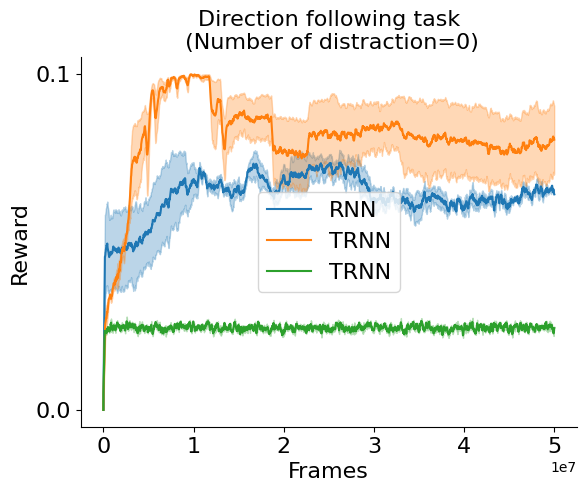

t-value:  -13.323893425434301
p-value:  0.0055830525291537545


In [18]:
def smooth(x, length):
    a = [0]*len(x)
    a[:length] = x[:length]
    for i in range(length):
        a[i] = sum(x[0:i])/length
    for i in range(length, len(x)):
        a[i] = sum(x[i-length:i])/length
    return a

def data(*args):
    path = args
    ACC = []
    length = 100000
    for i in range(len(path)):
        df = pd.read_csv(path[i])
        step = df["Step"].values.tolist()
        reward = df["Value"].values.tolist()
        if len(reward)<length :
            length = len(reward)
        ACC.append(reward)
    for i in range(len(ACC)):
        ACC[i] = ACC[i][:length]
        ACC[i] = smooth(ACC[i], 10)
    step = step[:length]
    reward = np.stack(ACC, axis=0).mean(0)
    reward_std = np.stack(ACC, axis=0).std(0) / np.sqrt(3)
    print(reward.max(), reward_std[np.where(reward==reward.max())[0][0]])
    return step, reward, reward_std

def data2(*args):
    path = args
    ACC = []
    STEP = []
    length = 1e8
    for i in range(len(path)):
        ea = event_accumulator.EventAccumulator(path[i])
        ea.Reload()
        val = ea.scalars.Items("reward/reward")
        k = 0
        step = []
        reward = []
        for j in val:
            if j.step<=5e7:
                step.append(j.step)
                reward.append(j.value)
            else:
                break
        ACC.append(reward)
        print(step[-1])
        if len(step)<= length:
            STEP = step
            length = len(STEP)
    for i in range(len(ACC)):
        ACC[i] = ACC[i][-1*length:]
        ACC[i] = smooth(ACC[i], 10)
    step = STEP[-1*length:]
    reward = np.stack(ACC, axis=0).mean(0)
    reward_std = np.stack(ACC, axis=0).std(0) / np.sqrt(3)
    print(reward.max(), reward_std[np.where(reward==reward.max())[0][0]])
    return step, reward, reward_std

lambda_ = 1
step, reward0_rnn, reward_std0_rnn = data2(
"/home/jiashuncheng/code/Trasient/RL/train_dir/df/20240116_MortarMayhemOA_v14_myrnn_alpha0.98_gate0_0.1_2.0_distribution0_lr3e-4_seed1/.summary/0/events.out.tfevents.1705433674.amax",
"/home/jiashuncheng/code/Trasient/RL/train_dir/df/20240116_MortarMayhemOA_v14_myrnn_alpha0.98_gate0_0.1_2.0_distribution0_lr3e-4_seed2/.summary/0/events.out.tfevents.1705433675.amax",
"/home/jiashuncheng/code/Trasient/RL/train_dir/df/20240116_MortarMayhemOA_v14_myrnn_alpha0.98_gate0_0.1_2.0_distribution0_lr3e-4_seed3/.summary/0/events.out.tfevents.1705433675.amax")
fig, ax = plt.subplots()
plt.plot(step,reward0_rnn, label='RNN',color='C0')
plt.fill_between(step, reward0_rnn+lambda_*reward_std0_rnn, reward0_rnn-lambda_*reward_std0_rnn, alpha=0.3,color='C0')

step, reward0_trnn, reward_std0_trnn = data2(
"/home/jiashuncheng/code/Trasient/RL/train_dir/df/20240115_MortarMayhemOA_v13_myrnn_alpha0.98_gate1_0.1_2.0_distribution0_lr3e-4_seed1/.summary/0/events.out.tfevents.1705432789.titanX",
"/home/jiashuncheng/code/Trasient/RL/train_dir/df/20240115_MortarMayhemOA_v13_myrnn_alpha0.98_gate1_0.1_2.0_distribution0_lr3e-4_seed2/.summary/0/events.out.tfevents.1705432789.titanX",
"/home/jiashuncheng/code/Trasient/RL/train_dir/df/20240115_MortarMayhemOA_v13_myrnn_alpha0.98_gate1_0.1_2.0_distribution0_lr3e-4_seed3/.summary/0/events.out.tfevents.1705432790.titanX")
plt.plot(step,reward0_trnn, label='TRNN',color='C1')
plt.fill_between(step, reward0_trnn+lambda_*reward_std0_trnn, reward0_trnn-lambda_*reward_std0_trnn, alpha=0.3,color='C1')

step, reward0_nn, reward_std0_nn = data2(
"/home/jiashuncheng/code/Trasient/RL/train_dir/df/20240115_MortarMayhemOA_v13_myrnn_alpha0.98_gate0_0.1_2.0_distribution0_lr3e-4_seed1_no_history/.summary/0/events.out.tfevents.1705598078.snn-ESC4000-G3-Series",
"/home/jiashuncheng/code/Trasient/RL/train_dir/df/20240115_MortarMayhemOA_v13_myrnn_alpha0.98_gate0_0.1_2.0_distribution0_lr3e-4_seed2_no_history/.summary/0/events.out.tfevents.1705598079.snn-ESC4000-G3-Series",
"/home/jiashuncheng/code/Trasient/RL/train_dir/df/20240115_MortarMayhemOA_v13_myrnn_alpha0.98_gate0_0.1_2.0_distribution0_lr3e-4_seed3_no_history/.summary/0/events.out.tfevents.1705598079.snn-ESC4000-G3-Series")
plt.plot(step,reward0_nn, label='TRNN',color='C2')
plt.fill_between(step, reward0_nn+lambda_*reward_std0_nn, reward0_nn-lambda_*reward_std0_nn, alpha=0.3,color='C2')

plt.title("Direction following task\n (Number of distraction=0)",fontsize=16)
plt.yticks([0,0.1],fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel('Reward', fontsize=16)
plt.xlabel('Frames', fontsize=16)
plt.legend(fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('figure/mortar2_0.svg')
# plt.xlim([0, 2e8])
plt.show()

P_value([reward0_rnn.max(), reward_std0_rnn[np.where(reward0_rnn==reward0_rnn.max())[0][0]]], 
        [reward0_trnn.max(), reward_std0_trnn[np.where(reward0_trnn==reward0_trnn.max())[0][0]]], 3)

### TI

In [20]:
dis0_trnn = sumTI("/home/jiashuncheng/code/Trasient/RL/train_dir/df/20240115_MortarMayhemOA_v13_myrnn_alpha0.98_gate1_0.1_2.0_distribution0_lr3e-4_seed1/20240117_215001_sf_hidden_act_log.npy",
"/home/jiashuncheng/code/Trasient/RL/train_dir/df/20240115_MortarMayhemOA_v13_myrnn_alpha0.98_gate1_0.1_2.0_distribution0_lr3e-4_seed2/20240117_215007_sf_hidden_act_log.npy",
"/home/jiashuncheng/code/Trasient/RL/train_dir/df/20240115_MortarMayhemOA_v13_myrnn_alpha0.98_gate1_0.1_2.0_distribution0_lr3e-4_seed3/20240117_215013_sf_hidden_act_log.npy")
dis0_rnn = sumTI("/home/jiashuncheng/code/Trasient/RL/train_dir/df/20240116_MortarMayhemOA_v14_myrnn_alpha0.98_gate0_0.1_2.0_distribution0_lr3e-4_seed1/20240117_214853_sf_hidden_act_log.npy",
"/home/jiashuncheng/code/Trasient/RL/train_dir/df/20240116_MortarMayhemOA_v14_myrnn_alpha0.98_gate0_0.1_2.0_distribution0_lr3e-4_seed2/20240117_214859_sf_hidden_act_log.npy",
"/home/jiashuncheng/code/Trasient/RL/train_dir/df/20240116_MortarMayhemOA_v14_myrnn_alpha0.98_gate0_0.1_2.0_distribution0_lr3e-4_seed3/20240117_214905_sf_hidden_act_log.npy")
print(dis0_trnn, dis0_rnn)
P_value(dis0_trnn,dis0_rnn,3)

(22, 600)
2.006
(22, 600)
1.787
(22, 600)
1.689
(22, 600)
0.287
(22, 600)
0.419
(22, 600)
0.702
(1.827333333333333, 0.07651046890362026) (0.4693333333333333, 0.09995146970553408)
t-value:  18.686413292547904
p-value:  7.789198929687172e-05


(22, 600)


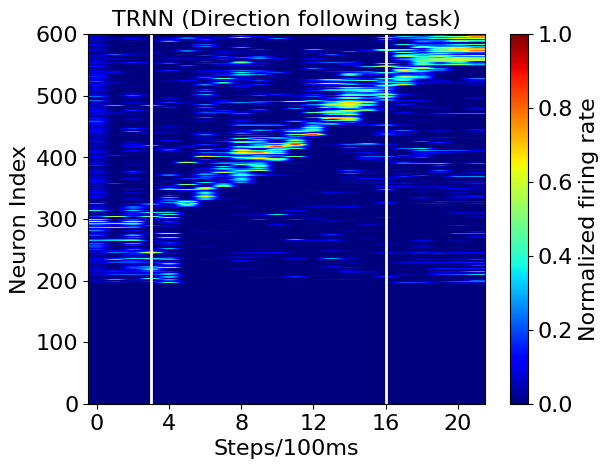

(22, 600)


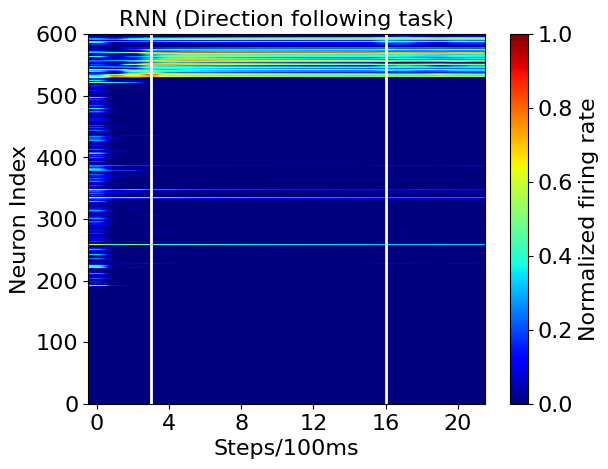

In [19]:
netdir  = "/home/jiashuncheng/code/Trasient/RL/train_dir/df/20240115_MortarMayhemOA_v13_myrnn_alpha0.98_gate1_0.1_2.0_distribution0_lr3e-4_seed1/20240117_215001_sf_hidden_act_log.npy"
results = np.load(netdir)
hidden_act = results
print(hidden_act.shape)
data0 = hidden_act
cal_TI(data0,4,19)[0] 
data0 = normalization1(data0).T
B_mylstm = sorting(data0)
data0 = data0[B_mylstm,:]
num = len(data0)
fig=plt.imshow(data0, aspect='auto',cmap='jet')
plt.vlines(x=3,ymin=0,ymax=600,linewidth=2,color='white')
plt.vlines(x=16,ymin=0,ymax=600,linewidth=2,color='white')
plt.ylim([0,600])
plt.yticks(fontsize=16)
plt.xticks([0,4,8,12,16,20],fontsize=16)
plt.xlabel('Steps/100ms',fontsize=16)
plt.ylabel('Neuron Index',fontsize=16)
plt.title('TRNN (Direction following task)',fontsize=16)#+ str(epoch) +'\n' +'ACC:' + str(acc))
cb=plt.colorbar(fig)
cb.set_label("Normalized firing rate",fontdict={'size':16})
cb.set_ticks([0,0.2,0.4,0.6,0.8,1])
cb.ax.tick_params(labelsize=16)
plt.savefig('figure/suppfig4b1.svg')
plt.show()

netdir  = "/home/jiashuncheng/code/Trasient/RL/train_dir/df/20240116_MortarMayhemOA_v14_myrnn_alpha0.98_gate0_0.1_2.0_distribution0_lr3e-4_seed1/20240117_214853_sf_hidden_act_log.npy"
results = np.load(netdir)
hidden_act = results
print(hidden_act.shape)
data0 = hidden_act
cal_TI(data0,4,19)[0] 
data0 = normalization1(data0).T
B_mylstm = sorting(data0)
data0 = data0[B_mylstm,:]
num = len(data0)
fig=plt.imshow(data0, aspect='auto',cmap='jet')
plt.vlines(x=3,ymin=0,ymax=600,linewidth=2,color='white')
plt.vlines(x=16,ymin=0,ymax=600,linewidth=2,color='white')
plt.ylim([0,600])
plt.yticks(fontsize=16)
plt.xticks([0,4,8,12,16,20],fontsize=16)
plt.xlabel('Steps/100ms',fontsize=16)
plt.ylabel('Neuron Index',fontsize=16)
plt.title('RNN (Direction following task)',fontsize=16)#+ str(epoch) +'\n' +'ACC:' + str(acc))
cb=plt.colorbar(fig)
cb.set_label("Normalized firing rate",fontdict={'size':16})
cb.set_ticks([0,0.2,0.4,0.6,0.8,1])
cb.ax.tick_params(labelsize=16)
plt.savefig('figure/suppfig4b2.svg')
plt.show()

## 1 distraction

### Line

49972560
49988752
49984704
0.08983333433667817 0.007111545190289586
49996848
49984704
49988752
0.09323333352804185 0.002663470160389331
49980656
49992800
49984704
0.027266666914025944 0.0004009248570563523


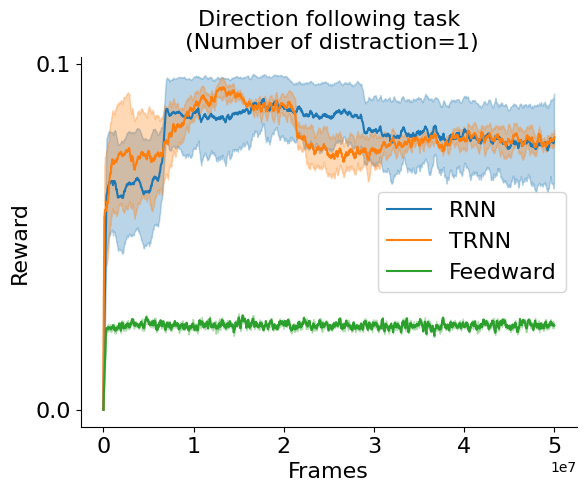

t-value:  -0.7754814931481924
p-value:  0.5035322221104322


In [3]:
def smooth(x, length):
    a = [0]*len(x)
    a[:length] = x[:length]
    for i in range(length):
        a[i] = sum(x[0:i])/length
    for i in range(length, len(x)):
        a[i] = sum(x[i-length:i])/length
    return a

def data(*args):
    path = args
    ACC = []
    length = 100000
    for i in range(len(path)):
        df = pd.read_csv(path[i])
        step = df["Step"].values.tolist()
        reward = df["Value"].values.tolist()
        if len(reward)<length :
            length = len(reward)
        ACC.append(reward)
    for i in range(len(ACC)):
        ACC[i] = ACC[i][:length]
        ACC[i] = smooth(ACC[i], 10)
    step = step[:length]
    reward = np.stack(ACC, axis=0).mean(0)
    reward_std = np.stack(ACC, axis=0).std(0) / np.sqrt(3)
    print(reward.max(), reward_std[np.where(reward==reward.max())[0][0]])
    return step, reward, reward_std

def data2(*args):
    path = args
    ACC = []
    STEP = []
    length = 1e8
    for i in range(len(path)):
        ea = event_accumulator.EventAccumulator(path[i])
        ea.Reload()
        val = ea.scalars.Items("reward/reward")
        k = 0
        step = []
        reward = []
        for j in val:
            if j.step<=5e7:
                step.append(j.step)
                reward.append(j.value)
            else:
                break
        ACC.append(reward)
        print(step[-1])
        if len(step)<= length:
            STEP = step
            length = len(STEP)
    for i in range(len(ACC)):
        ACC[i] = ACC[i][-1*length:]
        ACC[i] = smooth(ACC[i], 10)
    step = STEP[-1*length:]
    reward = np.stack(ACC, axis=0).mean(0)
    reward_std = np.stack(ACC, axis=0).std(0) / np.sqrt(3)
    print(reward.max(), reward_std[np.where(reward==reward.max())[0][0]])
    return step, reward, reward_std

lambda_ = 1
step, reward1_rnn, reward_std1_rnn = data2("/home/jiashuncheng/code/Trasient/RL/train_dir/df/20240116_MortarMayhemOA_v14_myrnn_alpha0.98_gate0_0.1_2.0_distribution1_lr3e-4_seed1/.summary/0/events.out.tfevents.1705392780.amax",
"/home/jiashuncheng/code/Trasient/RL/train_dir/df/20240116_MortarMayhemOA_v14_myrnn_alpha0.98_gate0_0.1_2.0_distribution1_lr3e-4_seed2/.summary/0/events.out.tfevents.1705392873.amax",
"/home/jiashuncheng/code/Trasient/RL/train_dir/df_116/20240116_MortarMayhemOA_v14_myrnn_alpha0.98_gate0_0.1_2.0_distribution1_lr3e-4_seed3/.summary/0/events.out.tfevents.1705419899.snn-ESC4000-G3-Series")
fig, ax = plt.subplots()
plt.plot(step,reward1_rnn, label='RNN',color='C0')
plt.fill_between(step, reward1_rnn+lambda_*reward_std1_rnn, reward1_rnn-lambda_*reward_std1_rnn, alpha=0.3,color='C0')

step, reward1_trnn, reward_std1_trnn = data2("/home/jiashuncheng/code/Trasient/RL/train_dir/df/20240115_MortarMayhemOA_v13_myrnn_alpha0.98_gate1_0.1_2.0_distribution1_lr3e-4_seed1/.summary/0/events.out.tfevents.1705402929.amax",
"/home/jiashuncheng/code/Trasient/RL/train_dir/df/20240115_MortarMayhemOA_v13_myrnn_alpha0.98_gate1_0.1_2.0_distribution1_lr3e-4_seed2/.summary/0/events.out.tfevents.1705402929.amax",
"/home/jiashuncheng/code/Trasient/RL/train_dir/df_116/20240116_MortarMayhemOA_v13_myrnn_alpha0.98_gate1_0.1_2.0_distribution1_lr3e-4_seed3/.summary/0/events.out.tfevents.1705419899.snn-ESC4000-G3-Series")
plt.plot(step,reward1_trnn, label='TRNN',color='C1')
plt.fill_between(step, reward1_trnn+lambda_*reward_std1_trnn, reward1_trnn-lambda_*reward_std1_trnn, alpha=0.3,color='C1')

step, reward1_nn, reward_std1_nn = data2("/home/jiashuncheng/code/Trasient/RL/train_dir/df/df/20240115_MortarMayhemOA_v13_myrnn_alpha0.98_gate0_0.1_2.0_distribution1_lr3e-4_seed1_no_history/.summary/0/events.out.tfevents.1705629892.titanX",
"/home/jiashuncheng/code/Trasient/RL/train_dir/df/df/20240115_MortarMayhemOA_v13_myrnn_alpha0.98_gate0_0.1_2.0_distribution1_lr3e-4_seed2_no_history/.summary/0/events.out.tfevents.1705629893.titanX",
"/home/jiashuncheng/code/Trasient/RL/train_dir/df/df/20240115_MortarMayhemOA_v13_myrnn_alpha0.98_gate0_0.1_2.0_distribution1_lr3e-4_seed3_no_history/.summary/0/events.out.tfevents.1705629893.titanX")
plt.plot(step,reward1_nn, label='Feedward',color='C2')
plt.fill_between(step, reward1_nn+lambda_*reward_std1_nn, reward1_nn-lambda_*reward_std1_nn, alpha=0.3,color='C2')

plt.title("Direction following task\n (Number of distraction=1)",fontsize=16)
plt.yticks([0,0.1],fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel('Reward', fontsize=16)
plt.xlabel('Frames', fontsize=16)
plt.legend(fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('figure/mortar2_1.svg')
# plt.xlim([0, 2e8])
plt.show()

P_value([reward1_rnn.max(), reward_std1_rnn[np.where(reward1_rnn==reward1_rnn.max())[0][0]]], 
        [reward1_trnn.max(), reward_std1_trnn[np.where(reward1_trnn==reward1_trnn.max())[0][0]]], 3)

### TI

In [21]:
dis1_trnn = sumTI("/home/jiashuncheng/code/Trasient/RL/train_dir/df/20240115_MortarMayhemOA_v13_myrnn_alpha0.98_gate1_0.1_2.0_distribution1_lr3e-4_seed1/20240117_214721_sf_hidden_act_log.npy",
"/home/jiashuncheng/code/Trasient/RL/train_dir/df/20240115_MortarMayhemOA_v13_myrnn_alpha0.98_gate1_0.1_2.0_distribution1_lr3e-4_seed2/20240117_214727_sf_hidden_act_log.npy",
"/home/jiashuncheng/code/Trasient/RL/train_dir/df/20240115_MortarMayhemOA_v13_myrnn_alpha0.98_gate1_0.1_2.0_distribution1_lr3e-4_seed2/20240117_214727_sf_hidden_act_log.npy")
dis1_rnn = sumTI("/home/jiashuncheng/code/Trasient/RL/train_dir/df/20240116_MortarMayhemOA_v14_myrnn_alpha0.98_gate0_0.1_2.0_distribution1_lr3e-4_seed1/20240117_214559_sf_hidden_act_log.npy",
"/home/jiashuncheng/code/Trasient/RL/train_dir/df/20240116_MortarMayhemOA_v14_myrnn_alpha0.98_gate0_0.1_2.0_distribution1_lr3e-4_seed2/20240117_214605_sf_hidden_act_log.npy",
"/home/jiashuncheng/code/Trasient/RL/train_dir/df_116/20240116_MortarMayhemOA_v14_myrnn_alpha0.98_gate0_0.1_2.0_distribution1_lr3e-4_seed3/20240117_214611_sf_hidden_act_log.npy")
print(dis1_trnn, dis1_rnn)
P_value(dis1_trnn,dis1_rnn,3)

(22, 600)
2.098
(22, 600)
2.215
(22, 600)
2.215
(22, 600)
1.178
(22, 600)
1.129
(22, 600)
1.131
(2.1759999999999997, 0.031843366656181316) (1.146, 0.0130724477007517)
t-value:  51.8273542027848
p-value:  4.565899533724635e-05


(22, 600)
True
0.6598089 0.0


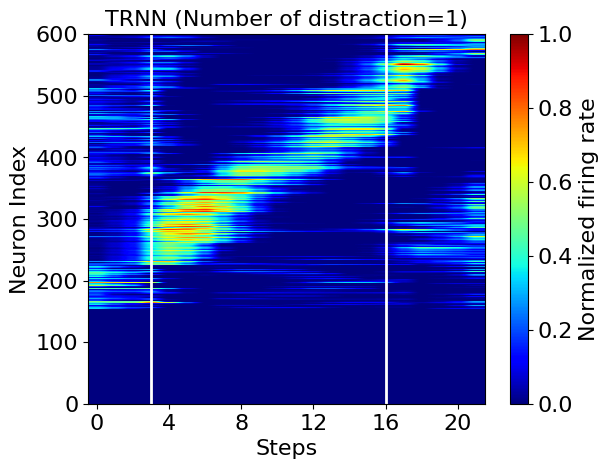

(22, 600)
True
3.1767418 0.0


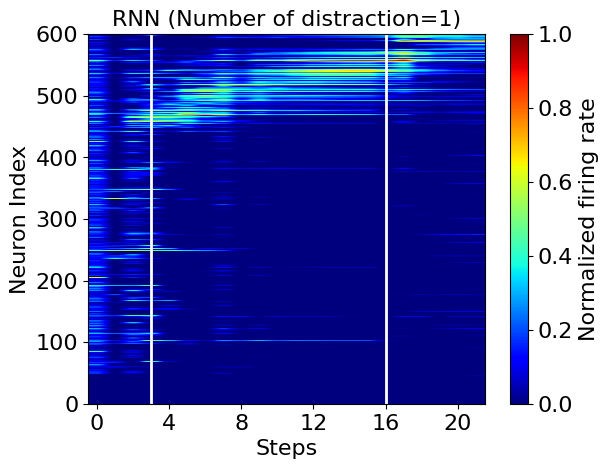

In [ ]:
netdir  = "/home/jiashuncheng/code/Trasient/RL/train_dir/MortarMayhemOA_v13_myrnn_alpha_theta_gate_distribution1_1/20231105_183008_sf_hidden_act_log.npy"
results = np.load(netdir)
hidden_act = results
print(hidden_act.shape)
data0 = hidden_act
cal_TI(data0,4,19)[0] 
data0 = normalization1(data0).T
B_mylstm = sorting(data0)
data0 = data0[B_mylstm,:]
num = len(data0)
fig=plt.imshow(data0, aspect='auto',cmap='jet')
plt.vlines(x=3,ymin=0,ymax=600,linewidth=2,color='white')
plt.vlines(x=16,ymin=0,ymax=600,linewidth=2,color='white')
plt.ylim([0,600])
plt.yticks(fontsize=16)
plt.xticks([0,4,8,12,16,20],fontsize=16)
plt.xlabel('Steps',fontsize=16)
plt.ylabel('Neuron Index',fontsize=16)
plt.title('TRNN (Number of distraction=1)',fontsize=16)#+ str(epoch) +'\n' +'ACC:' + str(acc))
cb=plt.colorbar(fig)
cb.set_label("Normalized firing rate",fontdict={'size':16})
cb.set_ticks([0,0.2,0.4,0.6,0.8,1])
cb.ax.tick_params(labelsize=16)
plt.show()

netdir  = "/home/jiashuncheng/code/Trasient/RL/train_dir/MortarMayhemOA_v13_myrnn_distribution1_1/20231105_183308_sf_hidden_act_log.npy"
results = np.load(netdir)
hidden_act = results
print(hidden_act.shape)
data0 = hidden_act
cal_TI(data0,4,19)[0] 
data0 = normalization1(data0).T
B_mylstm = sorting(data0)
data0 = data0[B_mylstm,:]
num = len(data0)
fig=plt.imshow(data0, aspect='auto',cmap='jet')
plt.vlines(x=3,ymin=0,ymax=600,linewidth=2,color='white')
plt.vlines(x=16,ymin=0,ymax=600,linewidth=2,color='white')
plt.ylim([0,600])
plt.yticks(fontsize=16)
plt.xticks([0,4,8,12,16,20],fontsize=16)
plt.xlabel('Steps',fontsize=16)
plt.ylabel('Neuron Index',fontsize=16)
plt.title('RNN (Number of distraction=1)',fontsize=16)#+ str(epoch) +'\n' +'ACC:' + str(acc))
cb=plt.colorbar(fig)
cb.set_label("Normalized firing rate",fontdict={'size':16})
cb.set_ticks([0,0.2,0.4,0.6,0.8,1])
cb.ax.tick_params(labelsize=16)
plt.show()

## 2 distractions

### Line

In [4]:
def smooth(x, length):
    a = [0]*len(x)
    a[:length] = x[:length]
    for i in range(length):
        a[i] = sum(x[0:i])/length
    for i in range(length, len(x)):
        a[i] = sum(x[i-length:i])/length
    return a

def data(*args):
    path = args
    ACC = []
    length = 100000
    for i in range(len(path)):
        df = pd.read_csv(path[i])
        step = df["Step"].values.tolist()
        reward = df["Value"].values.tolist()
        if len(reward)<length :
            length = len(reward)
        ACC.append(reward)
    for i in range(len(ACC)):
        ACC[i] = ACC[i][:length]
        ACC[i] = smooth(ACC[i], 10)
    step = step[:length]
    reward = np.stack(ACC, axis=0).mean(0)
    reward_std = np.stack(ACC, axis=0).std(0) / np.sqrt(3)
    print(reward.max(), reward_std[np.where(reward==reward.max())[0][0]])
    return step, reward, reward_std

def data2(*args):
    path = args
    ACC = []
    STEP = []
    length = 1e8
    for i in range(len(path)):
        ea = event_accumulator.EventAccumulator(path[i])
        ea.Reload()
        val = ea.scalars.Items("reward/reward")
        k = 0
        step = []
        reward = []
        for j in val:
            if j.step<=5e7:
                step.append(j.step)
                reward.append(j.value)
            else:
                break
        ACC.append(reward)
        print(step[-1])
        if len(step)<= length:
            STEP = step
            length = len(STEP)
    for i in range(len(ACC)):
        ACC[i] = ACC[i][-1*length:]
        ACC[i] = smooth(ACC[i], 10)
    step = STEP[-1*length:]
    reward = np.stack(ACC, axis=0).mean(0)
    reward_std = np.stack(ACC, axis=0).std(0) / np.sqrt(3)
    print(reward.max(), reward_std[np.where(reward==reward.max())[0][0]])
    return step, reward, reward_std

lambda_ = 1
step, reward2_rnn, reward_std2_rnn = data2("/home/jiashuncheng/code/Trasient/RL/train_dir/df/20240116_MortarMayhemOA_v14_myrnn_alpha0.98_gate0_0.1_2.0_distribution2_lr3e-4_seed1/.summary/0/events.out.tfevents.1705417374.titanX",
"/home/jiashuncheng/code/Trasient/RL/train_dir/df/20240116_MortarMayhemOA_v14_myrnn_alpha0.98_gate0_0.1_2.0_distribution2_lr3e-4_seed2/.summary/0/events.out.tfevents.1705417375.titanX",
"/home/jiashuncheng/code/Trasient/RL/train_dir/df/20240116_MortarMayhemOA_v14_myrnn_alpha0.98_gate0_0.1_2.0_distribution2_lr3e-4_seed3/.summary/0/events.out.tfevents.1705417375.titanX")
fig, ax = plt.subplots()
plt.plot(step,reward2_rnn, label='RNN',color='C0')
plt.fill_between(step, reward2_rnn+lambda_*reward_std2_rnn, reward2_rnn-lambda_*reward_std2_rnn, alpha=0.3,color='C0')

step, reward2_trnn, reward_std2_trnn = data2("/home/jiashuncheng/code/Trasient/RL/train_dir/df/20240115_MortarMayhemOA_v13_myrnn_alpha0.98_gate1_0.1_2.0_distribution2_lr3e-4_seed2/.summary/0/events.out.tfevents.1705417373.titanX",
"/home/jiashuncheng/code/Trasient/RL/train_dir/df/20240115_MortarMayhemOA_v13_myrnn_alpha0.98_gate1_0.1_2.0_distribution2_lr3e-4_seed2_1/.summary/0/events.out.tfevents.1705423315.titanX",
"/home/jiashuncheng/code/Trasient/RL/train_dir/df/20240115_MortarMayhemOA_v13_myrnn_alpha0.98_gate1_0.1_2.0_distribution2_lr3e-4_seed3/.summary/0/events.out.tfevents.1705417374.titanX")
plt.plot(step,reward2_trnn, label='TRNN',color='C1')
plt.fill_between(step, reward2_trnn+lambda_*reward_std2_trnn, reward2_trnn-lambda_*reward_std2_trnn, alpha=0.3,color='C1')

step, reward2_nn, reward_std2_nn = data2("/home/jiashuncheng/code/Trasient/RL/train_dir/df/df/20240115_MortarMayhemOA_v13_myrnn_alpha0.98_gate0_0.1_2.0_distribution2_lr3e-4_seed1_no_history/.summary/0/events.out.tfevents.1705630000.titanX",
"/home/jiashuncheng/code/Trasient/RL/train_dir/df/df/20240115_MortarMayhemOA_v13_myrnn_alpha0.98_gate0_0.1_2.0_distribution2_lr3e-4_seed2_no_history/.summary/0/events.out.tfevents.1705630000.titanX",
"/home/jiashuncheng/code/Trasient/RL/train_dir/df/df/20240115_MortarMayhemOA_v13_myrnn_alpha0.98_gate0_0.1_2.0_distribution2_lr3e-4_seed3_no_history/.summary/0/events.out.tfevents.1705630000.titanX")
plt.plot(step,reward2_nn, label='Feedward',color='C2')
plt.fill_between(step, reward2_nn+lambda_*reward_std2_nn, reward2_nn-lambda_*reward_std2_nn, alpha=0.3,color='C2')

plt.title("Direction following task\n (Number of distraction=2)",fontsize=16)
plt.yticks([0,0.1],fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel('Reward', fontsize=16)
plt.xlabel('Frames', fontsize=16)
plt.legend(fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('figure/mortar2_2.svg')
# plt.xlim([0, 2e8])
plt.show()

P_value([reward2_rnn.max(), reward_std2_rnn[np.where(reward2_rnn==reward2_rnn.max())[0][0]]], 
        [reward2_trnn.max(), reward_std2_trnn[np.where(reward2_trnn==reward2_trnn.max())[0][0]]], 3)

49996848
49984704
49988752
0.08466666763027508 0.003020056958326376
49992800
49964464
49988752
0.0952000007033348 0.0020677418266806537
49984704
49980656
49992800
0.026900000373522442 0.0001247220163048329


t-value:  -4.9846424012596
p-value:  0.010373363343380912


### TI

In [22]:
dis2_trnn = sumTI("/home/jiashuncheng/code/Trasient/RL/train_dir/df/20240115_MortarMayhemOA_v13_myrnn_alpha0.98_gate1_0.1_2.0_distribution2_lr3e-4_seed2/20240117_214323_sf_hidden_act_log.npy",
"/home/jiashuncheng/code/Trasient/RL/train_dir/df/20240115_MortarMayhemOA_v13_myrnn_alpha0.98_gate1_0.1_2.0_distribution2_lr3e-4_seed2_1/20240117_214329_sf_hidden_act_log.npy",
"/home/jiashuncheng/code/Trasient/RL/train_dir/df/20240115_MortarMayhemOA_v13_myrnn_alpha0.98_gate1_0.1_2.0_distribution2_lr3e-4_seed3/20240117_214335_sf_hidden_act_log.npy")
dis2_rnn = sumTI("/home/jiashuncheng/code/Trasient/RL/train_dir/df/20240116_MortarMayhemOA_v14_myrnn_alpha0.98_gate0_0.1_2.0_distribution2_lr3e-4_seed1/20240117_214215_sf_hidden_act_log.npy",
"/home/jiashuncheng/code/Trasient/RL/train_dir/df/20240116_MortarMayhemOA_v14_myrnn_alpha0.98_gate0_0.1_2.0_distribution2_lr3e-4_seed2/20240117_214220_sf_hidden_act_log.npy",
"/home/jiashuncheng/code/Trasient/RL/train_dir/df/20240116_MortarMayhemOA_v14_myrnn_alpha0.98_gate0_0.1_2.0_distribution2_lr3e-4_seed3/20240117_214226_sf_hidden_act_log.npy")
print(dis2_trnn, dis2_rnn)
P_value(dis2_trnn,dis2_rnn,3)

(22, 600)
2.084
(22, 600)
2.052
(22, 600)
2.176
(22, 600)
0.841
(22, 600)
0.583
(22, 600)
1.766
(2.104, 0.03034615113797614) (1.0633333333333332, 0.29323723173238775)
t-value:  6.114204882028223
p-value:  0.024441008359582732


(22, 600)
True
0.7680236 0.0


(22, 600)
True
2.169594 0.0


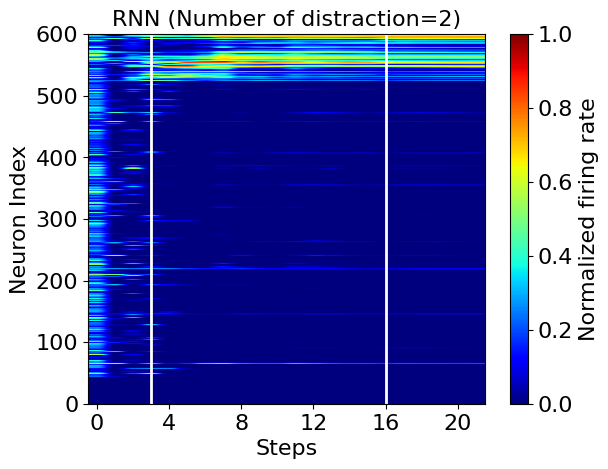

In [ ]:
netdir  = "/home/jiashuncheng/code/Trasient/RL/train_dir/MortarMayhemOA_v13_myrnn_alpha_theta_gate_distribution2_1/20231105_183026_sf_hidden_act_log.npy"
results = np.load(netdir)
hidden_act = results
print(hidden_act.shape)
data0 = hidden_act
cal_TI(data0,4,19)[0] 
data0 = normalization1(data0).T
B_mylstm = sorting(data0)
data0 = data0[B_mylstm,:]
num = len(data0)
fig=plt.imshow(data0, aspect='auto',cmap='jet')
plt.vlines(x=3,ymin=0,ymax=600,linewidth=2,color='white')
plt.vlines(x=16,ymin=0,ymax=600,linewidth=2,color='white')
plt.ylim([0,600])
plt.yticks(fontsize=16)
plt.xticks([0,4,8,12,16,20],fontsize=16)
plt.xlabel('Steps',fontsize=16)
plt.ylabel('Neuron Index',fontsize=16)
plt.title('TRNN (Number of distraction=2)',fontsize=16)#+ str(epoch) +'\n' +'ACC:' + str(acc))
cb=plt.colorbar(fig)
cb.set_label("Normalized firing rate",fontdict={'size':16})
cb.set_ticks([0,0.2,0.4,0.6,0.8,1])
cb.ax.tick_params(labelsize=16)
plt.show()

netdir  = "/home/jiashuncheng/code/Trasient/RL/train_dir/MortarMayhemOA_v13_myrnn_distribution2_1/20231105_183438_sf_hidden_act_log.npy"
results = np.load(netdir)
hidden_act = results
print(hidden_act.shape)
data0 = hidden_act
cal_TI(data0,4,19)[0] 
data0 = normalization1(data0).T
B_mylstm = sorting(data0)
data0 = data0[B_mylstm,:]
num = len(data0)
fig=plt.imshow(data0, aspect='auto',cmap='jet')
plt.vlines(x=3,ymin=0,ymax=600,linewidth=2,color='white')
plt.vlines(x=16,ymin=0,ymax=600,linewidth=2,color='white')
plt.ylim([0,600])
plt.yticks(fontsize=16)
plt.xticks([0,4,8,12,16,20],fontsize=16)
plt.xlabel('Steps',fontsize=16)
plt.ylabel('Neuron Index',fontsize=16)
plt.title('RNN (Number of distraction=2)',fontsize=16)#+ str(epoch) +'\n' +'ACC:' + str(acc))
cb=plt.colorbar(fig)
cb.set_label("Normalized firing rate",fontdict={'size':16})
cb.set_ticks([0,0.2,0.4,0.6,0.8,1])
cb.ax.tick_params(labelsize=16)
plt.show()

## 3 distractions

### Line

49976608
49984704
49992800
0.06966666740675767 0.005651024455915937
49976608
49996848
49980656
0.0911333329975605 0.005485401264698196
49980656
49956368
49964464
0.026966666554411253 0.0005084471156698527


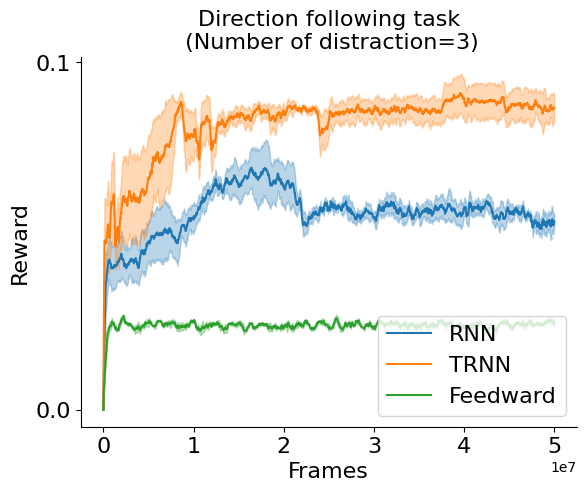

t-value:  -4.72113443852167
p-value:  0.009183696372059744


In [5]:
def smooth(x, length):
    a = [0]*len(x)
    a[:length] = x[:length]
    for i in range(length):
        a[i] = sum(x[0:i])/length
    for i in range(length, len(x)):
        a[i] = sum(x[i-length:i])/length
    return a

def data(*args):
    path = args
    ACC = []
    length = 100000
    for i in range(len(path)):
        df = pd.read_csv(path[i])
        step = df["Step"].values.tolist()
        reward = df["Value"].values.tolist()
        if len(reward)<length :
            length = len(reward)
        ACC.append(reward)
    for i in range(len(ACC)):
        ACC[i] = ACC[i][:length]
        ACC[i] = smooth(ACC[i], 10)
    step = step[:length]
    reward = np.stack(ACC, axis=0).mean(0)
    reward_std = np.stack(ACC, axis=0).std(0) / np.sqrt(3)
    print(reward.max(), reward_std[np.where(reward==reward.max())[0][0]])
    return step, reward, reward_std

def data2(*args):
    path = args
    ACC = []
    STEP = []
    length = 1e8
    for i in range(len(path)):
        ea = event_accumulator.EventAccumulator(path[i])
        ea.Reload()
        val = ea.scalars.Items("reward/reward")
        k = 0
        step = []
        reward = []
        for j in val:
            if j.step<=5e7:
                step.append(j.step)
                reward.append(j.value)
            else:
                break
        ACC.append(reward)
        print(step[-1])
        if len(step)<= length:
            STEP = step
            length = len(STEP)
    for i in range(len(ACC)):
        ACC[i] = ACC[i][-1*length:]
        ACC[i] = smooth(ACC[i], 10)
    step = STEP[-1*length:]
    reward = np.stack(ACC, axis=0).mean(0)
    reward_std = np.stack(ACC, axis=0).std(0) / np.sqrt(3)
    print(reward.max(), reward_std[np.where(reward==reward.max())[0][0]])
    return step, reward, reward_std

lambda_ = 1
step, reward3_rnn, reward_std3_rnn = data2("/home/jiashuncheng/code/Trasient/RL/train_dir/df/20240116_MortarMayhemOA_v14_myrnn_alpha0.98_gate0_0.1_2.0_distribution3_lr3e-4_seed1/.summary/0/events.out.tfevents.1705393513.amax",
"/home/jiashuncheng/code/Trasient/RL/train_dir/df/20240116_MortarMayhemOA_v14_myrnn_alpha0.98_gate0_0.1_2.0_distribution3_lr3e-4_seed2/.summary/0/events.out.tfevents.1705393513.amax",
"/home/jiashuncheng/code/Trasient/RL/train_dir/df/20240116_MortarMayhemOA_v14_myrnn_alpha0.98_gate0_0.1_2.0_distribution3_lr3e-4_seed3/.summary/0/events.out.tfevents.1705402763.amax")
fig, ax = plt.subplots()
plt.plot(step,reward3_rnn, label='RNN',color='C0')
plt.fill_between(step, reward3_rnn+lambda_*reward_std3_rnn, reward3_rnn-lambda_*reward_std3_rnn, alpha=0.3,color='C0')

step, reward3_trnn, reward_std3_trnn = data2("/home/jiashuncheng/code/Trasient/RL/train_dir/df/20240115_MortarMayhemOA_v13_myrnn_alpha0.98_gate1_0.1_2.0_distribution3_lr3e-4_seed1/.summary/0/events.out.tfevents.1705402762.amax",
"/home/jiashuncheng/code/Trasient/RL/train_dir/df/20240115_MortarMayhemOA_v13_myrnn_alpha0.98_gate1_0.1_2.0_distribution3_lr3e-4_seed2/.summary/0/events.out.tfevents.1705402762.amax",
"/home/jiashuncheng/code/Trasient/RL/train_dir/df/20240115_MortarMayhemOA_v13_myrnn_alpha0.98_gate1_0.1_2.0_distribution3_lr3e-4_seed3/.summary/0/events.out.tfevents.1705402763.amax")
plt.plot(step,reward3_trnn, label='TRNN',color='C1')
plt.fill_between(step, reward3_trnn+lambda_*reward_std3_trnn, reward3_trnn-lambda_*reward_std3_trnn, alpha=0.3,color='C1')

step, reward3_nn, reward_std3_nn = data2("/home/jiashuncheng/code/Trasient/RL/train_dir/df/df/20240115_MortarMayhemOA_v13_myrnn_alpha0.98_gate0_0.1_2.0_distribution3_lr3e-4_seed1_no_history/.summary/0/events.out.tfevents.1705633285.amax",
"/home/jiashuncheng/code/Trasient/RL/train_dir/df/df/20240115_MortarMayhemOA_v13_myrnn_alpha0.98_gate0_0.1_2.0_distribution3_lr3e-4_seed2_no_history/.summary/0/events.out.tfevents.1705633285.amax",
"/home/jiashuncheng/code/Trasient/RL/train_dir/df/df/20240115_MortarMayhemOA_v13_myrnn_alpha0.98_gate0_0.1_2.0_distribution3_lr3e-4_seed3_no_history/.summary/0/events.out.tfevents.1705633286.amax")
plt.plot(step,reward3_nn, label='Feedward',color='C2')
plt.fill_between(step, reward3_nn+lambda_*reward_std3_nn, reward3_nn-lambda_*reward_std3_nn, alpha=0.3,color='C2')

plt.title("Direction following task\n (Number of distraction=3)",fontsize=16)
plt.yticks([0,0.1],fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel('Reward', fontsize=16)
plt.xlabel('Frames', fontsize=16)
plt.legend(fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('figure/mortar2_3.svg')
# plt.xlim([0, 2e8])
plt.show()

P_value([reward3_rnn.max(), reward_std3_rnn[np.where(reward3_rnn==reward3_rnn.max())[0][0]]], 
        [reward3_trnn.max(), reward_std3_trnn[np.where(reward3_trnn==reward3_trnn.max())[0][0]]], 3)

### TI

In [23]:
dis3_trnn = sumTI("/home/jiashuncheng/code/Trasient/RL/train_dir/df/20240115_MortarMayhemOA_v13_myrnn_alpha0.98_gate1_0.1_2.0_distribution3_lr3e-4_seed1/20240117_213844_sf_hidden_act_log.npy",
"/home/jiashuncheng/code/Trasient/RL/train_dir/df/20240115_MortarMayhemOA_v13_myrnn_alpha0.98_gate1_0.1_2.0_distribution3_lr3e-4_seed2/20240117_213850_sf_hidden_act_log.npy",
"/home/jiashuncheng/code/Trasient/RL/train_dir/df/20240115_MortarMayhemOA_v13_myrnn_alpha0.98_gate1_0.1_2.0_distribution3_lr3e-4_seed3/20240117_213856_sf_hidden_act_log.npy")
dis3_rnn = sumTI("/home/jiashuncheng/code/Trasient/RL/train_dir/df/20240116_MortarMayhemOA_v14_myrnn_alpha0.98_gate0_0.1_2.0_distribution3_lr3e-4_seed2/20240117_213732_sf_hidden_act_log.npy",
"/home/jiashuncheng/code/Trasient/RL/train_dir/df/20240116_MortarMayhemOA_v14_myrnn_alpha0.98_gate0_0.1_2.0_distribution3_lr3e-4_seed2/20240117_213732_sf_hidden_act_log.npy",
"/home/jiashuncheng/code/Trasient/RL/train_dir/df/20240116_MortarMayhemOA_v14_myrnn_alpha0.98_gate0_0.1_2.0_distribution3_lr3e-4_seed3/20240117_213737_sf_hidden_act_log.npy")
print(dis3_trnn, dis3_rnn)
P_value(dis3_trnn,dis3_rnn,3)

(22, 600)
2.07
(22, 600)
2.045
(22, 600)
1.869
(22, 600)
0.946
(22, 600)
0.946
(22, 600)
0.275
(1.9946666666666666, 0.05164049516358977) (0.7223333333333333, 0.18262306860083471)
t-value:  11.611870460761299
p-value:  0.004188360929739309


(22, 600)


(22, 600)


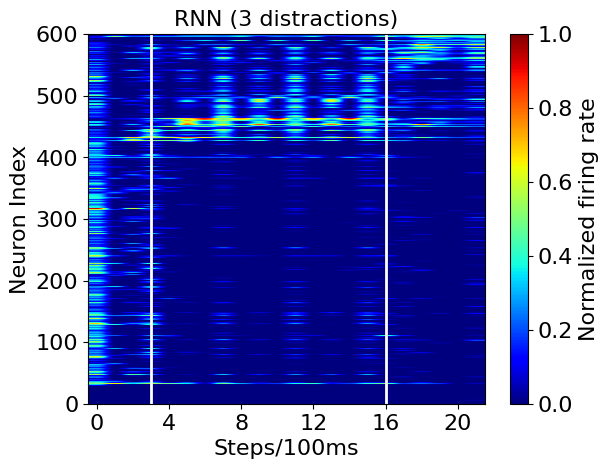

In [24]:
netdir  = "/home/jiashuncheng/code/Trasient/RL/train_dir/df/20240115_MortarMayhemOA_v13_myrnn_alpha0.98_gate1_0.1_2.0_distribution3_lr3e-4_seed1/20240117_213844_sf_hidden_act_log.npy"
results = np.load(netdir)
hidden_act = results
print(hidden_act.shape)
data0 = hidden_act
cal_TI(data0,4,19)[0] 
data0 = normalization1(data0).T
B_mylstm = sorting(data0)
data0 = data0[B_mylstm,:]
num = len(data0)
fig=plt.imshow(data0, aspect='auto',cmap='jet')
plt.vlines(x=3,ymin=0,ymax=600,linewidth=2,color='white')
plt.vlines(x=16,ymin=0,ymax=600,linewidth=2,color='white')
plt.ylim([0,600])
plt.yticks(fontsize=16)
plt.xticks([0,4,8,12,16,20],fontsize=16)
plt.xlabel('Steps/100ms',fontsize=16)
plt.ylabel('Neuron Index',fontsize=16)
plt.title('TRNN (3 distractions)',fontsize=16)#+ str(epoch) +'\n' +'ACC:' + str(acc))
cb=plt.colorbar(fig)
cb.set_label("Normalized firing rate",fontdict={'size':16})
cb.set_ticks([0,0.2,0.4,0.6,0.8,1])
cb.ax.tick_params(labelsize=16)
plt.savefig('figure/suppfig4b3.svg')
plt.show()

netdir  = "/home/jiashuncheng/code/Trasient/RL/train_dir/df/20240116_MortarMayhemOA_v14_myrnn_alpha0.98_gate0_0.1_2.0_distribution3_lr3e-4_seed2/20240117_213732_sf_hidden_act_log.npy"
results = np.load(netdir)
hidden_act = results
print(hidden_act.shape)
data0 = hidden_act
cal_TI(data0,4,19)[0] 
data0 = normalization1(data0).T
B_mylstm = sorting(data0)
data0 = data0[B_mylstm,:]
num = len(data0)
fig=plt.imshow(data0, aspect='auto',cmap='jet')
plt.vlines(x=3,ymin=0,ymax=600,linewidth=2,color='white')
plt.vlines(x=16,ymin=0,ymax=600,linewidth=2,color='white')
plt.ylim([0,600])
plt.yticks(fontsize=16)
plt.xticks([0,4,8,12,16,20],fontsize=16)
plt.xlabel('Steps/100ms',fontsize=16)
plt.ylabel('Neuron Index',fontsize=16)
plt.title('RNN (3 distractions)',fontsize=16)#+ str(epoch) +'\n' +'ACC:' + str(acc))
cb=plt.colorbar(fig)
cb.set_label("Normalized firing rate",fontdict={'size':16})
cb.set_ticks([0,0.2,0.4,0.6,0.8,1])
cb.ax.tick_params(labelsize=16)
plt.savefig('figure/suppfig4b4.svg')
plt.show()

## Reward bar

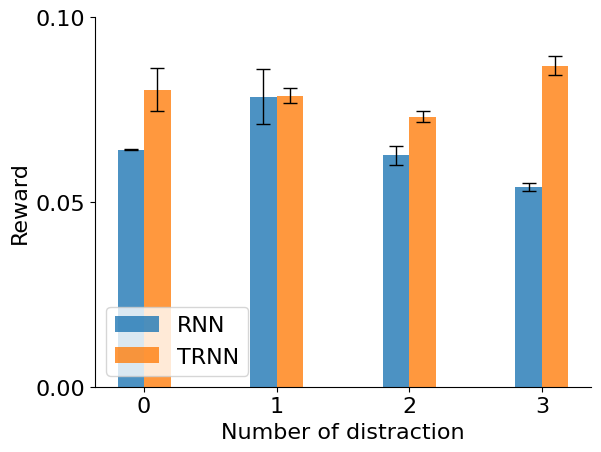

t-value:  -2.7819538050954806
p-value:  0.10854848226237361
t-value:  -0.034540506191176795
p-value:  0.9752126942020074
t-value:  -3.5948787844767036
p-value:  0.03169747123424098
t-value:  -11.936422448646432
p-value:  0.002134059250681678


In [11]:
x = range(4)
error_params=dict(elinewidth=1,capsize=5)              

# value1 = [reward0_rnn.max(), reward1_rnn.max(), reward2_rnn.max(),reward3_rnn.max()]
# value1_std = [reward_std0_rnn[np.where(reward0_rnn==reward0_rnn.max())[0][0]],
#               reward_std1_rnn[np.where(reward1_rnn==reward1_rnn.max())[0][0]],
#               reward_std2_rnn[np.where(reward2_rnn==reward2_rnn.max())[0][0]],
#               reward_std3_rnn[np.where(reward3_rnn==reward3_rnn.max())[0][0]]]
# value2 = [reward0_trnn.max(), reward1_trnn.max(), reward2_trnn.max(),reward3_trnn.max()]
# value2_std = [reward_std0_trnn[np.where(reward0_trnn==reward0_trnn.max())[0][0]],
#               reward_std1_trnn[np.where(reward1_trnn==reward1_trnn.max())[0][0]],
#               reward_std2_trnn[np.where(reward2_trnn==reward2_trnn.max())[0][0]],
#               reward_std3_trnn[np.where(reward3_trnn==reward3_trnn.max())[0][0]]]

value1 = [reward0_rnn[-1], reward1_rnn[-1], reward2_rnn[-1], reward3_rnn[-1]]
value1_std = [reward_std0_rnn[np.where(reward0_rnn==reward0_rnn[-1])[0][0]],
              reward_std1_rnn[np.where(reward1_rnn==reward1_rnn[-1])[0][0]],
              reward_std2_rnn[np.where(reward2_rnn==reward2_rnn[-1])[0][0]],
              reward_std3_rnn[np.where(reward3_rnn==reward3_rnn[-1])[0][0]]]
value2 = [reward0_trnn[-1], reward1_trnn[-1], reward2_trnn[-1],reward3_trnn[-1]]
value2_std = [reward_std0_trnn[np.where(reward0_trnn==reward0_trnn[-1])[0][0]],
              reward_std1_trnn[np.where(reward1_trnn==reward1_trnn[-1])[0][0]],
              reward_std2_trnn[np.where(reward2_trnn==reward2_trnn[-1])[0][0]],
              reward_std3_trnn[np.where(reward3_trnn==reward3_trnn[-1])[0][0]]]
fig, ax = plt.subplots()
bar1 = plt.bar([i - 0.1 for i in x],value1,yerr=value1_std/np.sqrt(3),error_kw=error_params,width = 0.2,
               alpha = 0.8,color = 'C0',label = 'RNN')

bar2 = plt.bar([i + 0.1 for i in x],value2,yerr=value2_std/np.sqrt(3),error_kw=error_params,width = 0.2,
               alpha = 0.8,color = 'C1',label = 'TRNN')

plt.ylabel('Reward',fontsize=16)       #y轴的标签
plt.xlabel('Number of distraction', fontsize=16)  
plt.yticks([0,0.05,0.1],fontsize=16)
plt.xticks([0, 1, 2, 3], [0, 1, 2, 3], fontsize=16)
plt.legend(fontsize=16)            #设置图例
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('figure/distraction.svg')
plt.show()

P_value([reward0_rnn[-1], reward_std0_rnn[np.where(reward0_rnn==reward0_rnn[-1])[0][0]]], 
        [reward0_trnn[-1], reward_std0_trnn[np.where(reward0_trnn==reward0_trnn[-1])[0][0]]], 3)
P_value([reward1_rnn[-1], reward_std1_rnn[np.where(reward1_rnn==reward1_rnn[-1])[0][0]]], 
        [reward1_trnn[-1], reward_std1_trnn[np.where(reward1_trnn==reward1_trnn[-1])[0][0]]], 3)
P_value([reward2_rnn[-1], reward_std2_rnn[np.where(reward2_rnn==reward2_rnn[-1])[0][0]]], 
        [reward2_trnn[-1], reward_std2_trnn[np.where(reward2_trnn==reward2_trnn[-1])[0][0]]], 3)
P_value([reward3_rnn[-1], reward_std3_rnn[np.where(reward3_rnn==reward3_rnn[-1])[0][0]]], 
        [reward3_trnn[-1], reward_std3_trnn[np.where(reward3_trnn==reward3_trnn[-1])[0][0]]], 3)

## TI bar

In [32]:
x = range(4)
error_params=dict(elinewidth=1,capsize=5)              

value1 = [dis0_rnn[0], dis1_rnn[0], dis2_rnn[0], dis3_rnn[0]]
value1_std = [dis0_rnn[1],
              dis1_rnn[1],
              dis2_rnn[1],
              dis3_rnn[1]]
value2 = [dis0_trnn[0], dis1_trnn[0], dis2_trnn[0], dis3_trnn[0]]
value2_std = [dis0_trnn[1],
              dis1_trnn[1],
              dis2_trnn[1],
              dis3_trnn[1]]
fig, ax = plt.subplots()
bar1 = plt.bar([i - 0.1 for i in x],value1,yerr=value1_std/np.sqrt(3),error_kw=error_params,width = 0.2,
               alpha = 0.8,color = 'C0',label = 'RNN')

bar2 = plt.bar([i + 0.1 for i in x],value2,yerr=value2_std/np.sqrt(3),error_kw=error_params,width = 0.2,
               alpha = 0.8,color = 'C1',label = 'TRNN')

plt.ylabel('TI',fontsize=16)       #y轴的标签
plt.xlabel('Number of distraction', fontsize=16)  
plt.yticks(fontsize=16)
plt.xticks([0, 1, 2, 3], [0, 1, 2, 3], fontsize=16)
plt.legend(fontsize=16)            #设置图例
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('figure/supp_distraction_ti1.svg')
plt.show()

t_stat, p_value = scipy.stats.ttest_ind_from_stats(value1[0], value1_std[0], 3, value2[0], value2_std[0], 3, equal_var=False)
print("t-value: ", t_stat)
print("p-value: ", p_value)
t_stat, p_value = scipy.stats.ttest_ind_from_stats(value1[1], value1_std[1], 3, value2[1], value2_std[1], 3, equal_var=False)
print("t-value: ", t_stat)
print("p-value: ", p_value)
t_stat, p_value = scipy.stats.ttest_ind_from_stats(value1[2], value1_std[2], 3, value2[2], value2_std[2], 3, equal_var=False)
print("t-value: ", t_stat)
print("p-value: ", p_value)
t_stat, p_value = scipy.stats.ttest_ind_from_stats(value1[3], value1_std[3], 3, value2[3], value2_std[3], 3, equal_var=False)
print("t-value: ", t_stat)
print("p-value: ", p_value)

t-value:  -18.686413292547904
p-value:  7.789198929687172e-05
t-value:  -51.8273542027848
p-value:  4.565899533724635e-05
t-value:  -6.114204882028223
p-value:  0.024441008359582732
t-value:  -11.611870460761299
p-value:  0.004188360929739309


# MDF task

## Comment=2

### Line

In [13]:
def smooth(x, length):
    a = [0]*len(x)
    a[:length] = x[:length]
    for i in range(length):
        a[i] = sum(x[0:i])/length
    for i in range(length, len(x)):
        a[i] = sum(x[i-length:i])/length
    return a

def data(*args):
    path = args
    ACC = []
    length = 100000
    for i in range(len(path)):
        df = pd.read_csv(path[i])
        step = df["Step"].values.tolist()
        reward = df["Value"].values.tolist()
        if len(reward)<length :
            length = len(reward)
        ACC.append(reward)
    for i in range(len(ACC)):
        ACC[i] = ACC[i][:length]
        ACC[i] = smooth(ACC[i], 10)
    step = step[:length]
    reward = np.stack(ACC, axis=0).mean(0)
    reward_std = np.stack(ACC, axis=0).std(0) / np.sqrt(3)
    print(reward.max(), reward_std[np.where(reward==reward.max())[0][0]])
    return step, reward, reward_std

def data2(*args):
    path = args
    ACC = []
    STEP = []
    length = 2e8
    for i in range(len(path)):
        ea = event_accumulator.EventAccumulator(path[i])
        ea.Reload()
        val = ea.scalars.Items("reward/reward")
        k = 0
        step = []
        reward = []
        for j in val:
            if j.step<=3e7:
                step.append(j.step)
                reward.append(j.value)
            else:
                break
        ACC.append(reward)
        print(step[-1])
        if len(step)<= length:
            STEP = step
            length = len(STEP)
    for i in range(len(ACC)):
        ACC[i] = ACC[i][-1*length:]
        ACC[i] = smooth(ACC[i], 10)
    step = STEP[-1*length:]
    reward = np.stack(ACC, axis=0).mean(0)
    reward_std = np.stack(ACC, axis=0).std(0) / np.sqrt(3)
    print(reward.max(), reward_std[np.where(reward==reward.max())[0][0]])
    return step, reward, reward_std

lambda_ = 1
step, reward_rnn_2, reward_std_rnn_2 = data2("/home/jiashuncheng/code/Trasient/RL/train_dir/mdf/20240116_MortarMayhem_v20_myrnn_alpha0.98_gate0_0.1_8.0_region0_comm2_lr2e-4_seed1/.summary/0/events.out.tfevents.1705431514.amax",
"/home/jiashuncheng/code/Trasient/RL/train_dir/mdf/20240116_MortarMayhem_v20_myrnn_alpha0.98_gate0_0.1_8.0_region0_comm2_lr2e-4_seed2/.summary/0/events.out.tfevents.1705431514.amax",
"/home/jiashuncheng/code/Trasient/RL/train_dir/mdf/20240116_MortarMayhem_v20_myrnn_alpha0.98_gate0_0.1_8.0_region0_comm2_lr2e-4_seed3/.summary/0/events.out.tfevents.1705431515.amax")
fig, ax = plt.subplots()
plt.plot(step,reward_rnn_2, label='RNN',color='C0')
plt.fill_between(step, reward_rnn_2+lambda_*reward_std_rnn_2, reward_rnn_2-lambda_*reward_std_rnn_2, alpha=0.3,color='C0')

step, reward_trnn_2, reward_std_trnn_2 = data2("/home/jiashuncheng/code/Trasient/RL/train_dir/mdf/20240116_MortarMayhem_v20_myrnn_alpha0.98_gate1_0.1_8.0_region1_comm2_lr2e-4_seed1/.summary/0/events.out.tfevents.1705431512.amax",
"/home/jiashuncheng/code/Trasient/RL/train_dir/mdf/20240116_MortarMayhem_v20_myrnn_alpha0.98_gate1_0.1_8.0_region1_comm2_lr2e-4_seed2/.summary/0/events.out.tfevents.1705431513.amax",
"/home/jiashuncheng/code/Trasient/RL/train_dir/mdf/20240116_MortarMayhem_v20_myrnn_alpha0.98_gate1_0.1_8.0_region1_comm2_lr2e-4_seed3/.summary/0/events.out.tfevents.1705431513.amax")
plt.plot(step,reward_trnn_2, label='TRNN',color='C1')
plt.fill_between(step, reward_trnn_2+lambda_*reward_std_trnn_2, reward_trnn_2-lambda_*reward_std_trnn_2, alpha=0.3,color='C1')

step, reward_nn_2, reward_std_nn_2 = data2("/home/jiashuncheng/code/Trasient/RL/train_dir/mdf/20240116_MortarMayhem_v20_myrnn_alpha0.98_gate0_0.1_2.0_region0_comm2_lr2e-4_seed1_no_history/.summary/0/events.out.tfevents.1705597648.amax",
"/home/jiashuncheng/code/Trasient/RL/train_dir/mdf/20240116_MortarMayhem_v20_myrnn_alpha0.98_gate0_0.1_2.0_region0_comm2_lr2e-4_seed2_no_history/.summary/0/events.out.tfevents.1705597649.amax",
"/home/jiashuncheng/code/Trasient/RL/train_dir/mdf/20240116_MortarMayhem_v20_myrnn_alpha0.98_gate0_0.1_2.0_region0_comm2_lr2e-4_seed3_no_history/.summary/0/events.out.tfevents.1705597649.amax")
plt.plot(step,reward_nn_2, label='Feedword',color='C2')
plt.fill_between(step, reward_nn_2+lambda_*reward_std_nn_2, reward_nn_2-lambda_*reward_std_nn_2, alpha=0.3,color='C2')

plt.title("MortarMayhem",fontsize=16)
plt.yticks([0,0.1,0.2],fontsize=16)
plt.xticks([0,3e7],fontsize=16)
plt.ylabel('Reward', fontsize=16)
plt.xlabel('Frames', fontsize=16)
plt.legend(fontsize=24)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.savefig('figure/MortarMayhem.svg')
# plt.xlim([0, 2e8])
plt.show()

P_value([reward_rnn_2.max(), reward_std_rnn_2[np.where(reward_rnn_2==reward_rnn_2.max())[0][0]]], 
        [reward_trnn_2.max(), reward_std_trnn_2[np.where(reward_trnn_2==reward_trnn_2.max())[0][0]]], 3)

29995680
29991632
29991632
0.17396666457255683 0.0011405000004434001
29999728
29983536
29987584
0.19116666515668235 0.003953432149099785
29995680
29971392
29971392
0.051766666769981394 0.00011863429202729589


t-value:  -7.240289231426435
p-value:  0.012031938690787319


### TI

(22, 600)
(2.501, 4.14504767478952, 0.7898446890074559, 0.8196021645637973, 1.609, 0.13233621983251664, 0.8916349809885932)


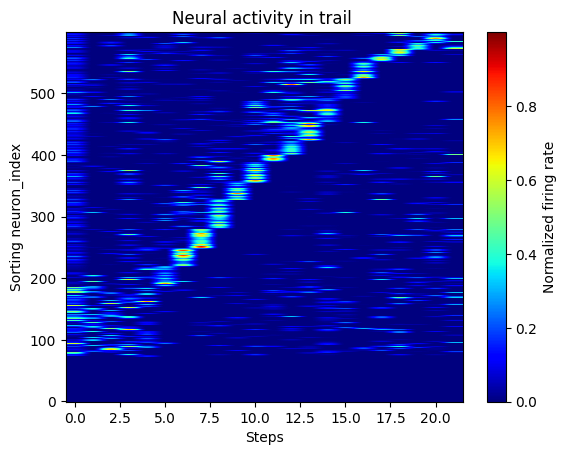

(22, 600)
(1.635, 3.164245869404814, 0.6029515196806708, 0.5997020960056862, 1.203, 0.1300162270717526, 0.43197278911564624)


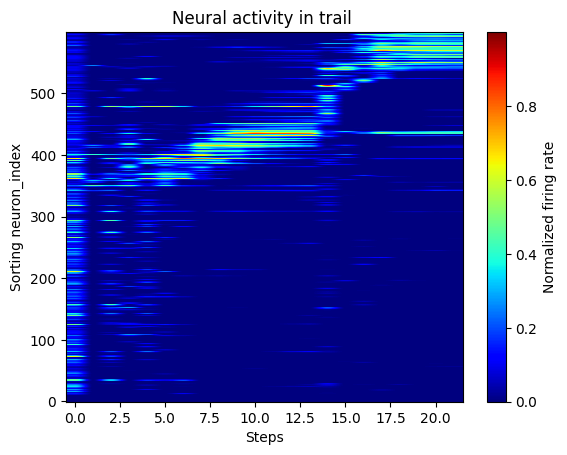

(22, 600)
1.464
(22, 600)
1.338
(22, 600)
1.366
(22, 600)
0.806
(22, 600)
0.751
(22, 600)
0.751
(1.3893333333333333, 0.031188791908965292) (0.7693333333333333, 0.014969103983674991)
t-value:  31.041224059900888
p-value:  0.00010093454610544475


In [27]:
netdir  = "/home/jiashuncheng/code/Trasient/RL/train_dir/mdf/20240116_MortarMayhem_v20_myrnn_alpha0.98_gate1_0.1_8.0_region1_comm2_lr2e-4_seed1/20240117_210614_sf_hidden_act_log.npy"
results = np.load(netdir)
hidden_act = results
print(hidden_act.shape)
data0 = hidden_act
print(cal_TI(data0,2,40))
data0 = normalization1(data0).T
B_mylstm = sorting(data0)
data0 = data0[B_mylstm,:]
num = len(data0)
fig=plt.imshow(data0, aspect='auto',cmap='jet')
plt.xlabel('Steps')
plt.gca().invert_yaxis()
plt.ylabel('Sorting neuron_index')
plt.title('Neural activity in trail ')#+ str(epoch) +'\n' +'ACC:' + str(acc))
plt.colorbar(fig, label="Normalized firing rate")
plt.show()

netdir  = "/home/jiashuncheng/code/Trasient/RL/train_dir/mdf/20240116_MortarMayhem_v20_myrnn_alpha0.98_gate0_0.1_8.0_region0_comm2_lr2e-4_seed1/20240117_205609_sf_hidden_act_log.npy"
results = np.load(netdir)
hidden_act = results
print(hidden_act.shape)
data0 = hidden_act
print(cal_TI(data0,2,40))
data0 = normalization1(data0).T
B_mylstm = sorting(data0)
data0 = data0[B_mylstm,:]
num = len(data0)
fig=plt.imshow(data0, aspect='auto',cmap='jet')
plt.xlabel('Steps')
plt.gca().invert_yaxis()
plt.ylabel('Sorting neuron_index')
plt.title('Neural activity in trail ')#+ str(epoch) +'\n' +'ACC:' + str(acc))
plt.colorbar(fig, label="Normalized firing rate")
plt.show()

comm2_trnn = sumTI("/home/jiashuncheng/code/Trasient/RL/train_dir/mdf/20240116_MortarMayhem_v20_myrnn_alpha0.98_gate1_0.1_8.0_region1_comm2_lr2e-4_seed1/20240117_210614_sf_hidden_act_log.npy",
"/home/jiashuncheng/code/Trasient/RL/train_dir/mdf/20240116_MortarMayhem_v20_myrnn_alpha0.98_gate1_0.1_8.0_region1_comm2_lr2e-4_seed2/20240117_210620_sf_hidden_act_log.npy",
"/home/jiashuncheng/code/Trasient/RL/train_dir/mdf/20240116_MortarMayhem_v20_myrnn_alpha0.98_gate1_0.1_8.0_region1_comm2_lr2e-4_seed3/20240117_210627_sf_hidden_act_log.npy",a=4,b=8)
comm2_rnn = sumTI("/home/jiashuncheng/code/Trasient/RL/train_dir/mdf/20240116_MortarMayhem_v20_myrnn_alpha0.98_gate0_0.1_8.0_region0_comm2_lr2e-4_seed1/20240117_205609_sf_hidden_act_log.npy",
"/home/jiashuncheng/code/Trasient/RL/train_dir/mdf/20240116_MortarMayhem_v20_myrnn_alpha0.98_gate0_0.1_8.0_region0_comm2_lr2e-4_seed2/20240117_205615_sf_hidden_act_log.npy",
"/home/jiashuncheng/code/Trasient/RL/train_dir/mdf/20240116_MortarMayhem_v20_myrnn_alpha0.98_gate0_0.1_8.0_region0_comm2_lr2e-4_seed2/20240117_205615_sf_hidden_act_log.npy",a=4,b=8)
print(comm2_trnn, comm2_rnn)
P_value(comm2_trnn,comm2_rnn,3)

## Comment=3

### Line

39992160
39968496
39984272
0.17843333433071773 0.0043828789151819526
39988216
39996104
39984272
0.25856666763623554 0.014676991600506225
39992160
39996104
39980328
0.06796666656931243 0.0010070123326264523


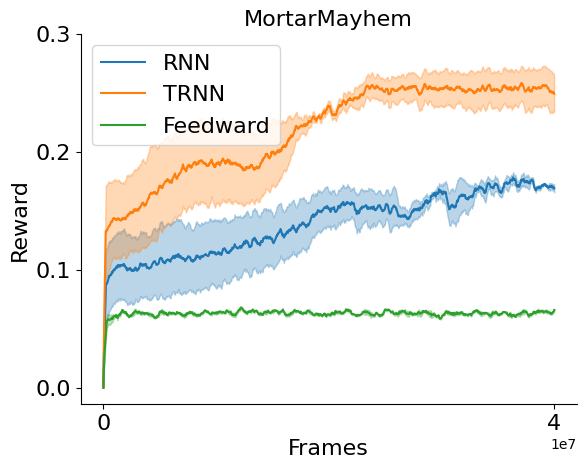

t-value:  -9.061245287357368
p-value:  0.0069890453677630944


In [14]:
def smooth(x, length):
    a = [0]*len(x)
    a[:length] = x[:length]
    for i in range(length):
        a[i] = sum(x[0:i])/length
    for i in range(length, len(x)):
        a[i] = sum(x[i-length:i])/length
    return a

def data(*args):
    path = args
    ACC = []
    length = 100000
    for i in range(len(path)):
        df = pd.read_csv(path[i])
        step = df["Step"].values.tolist()
        reward = df["Value"].values.tolist()
        if len(reward)<length :
            length = len(reward)
        ACC.append(reward)
    for i in range(len(ACC)):
        ACC[i] = ACC[i][:length]
        ACC[i] = smooth(ACC[i], 10)
    step = step[:length]
    reward = np.stack(ACC, axis=0).mean(0)
    reward_std = np.stack(ACC, axis=0).std(0) / np.sqrt(3)
    print(reward.max(), reward_std[np.where(reward==reward.max())[0][0]])
    return step, reward, reward_std

def data2(*args):
    path = args
    ACC = []
    STEP = []
    length = 2e8
    for i in range(len(path)):
        ea = event_accumulator.EventAccumulator(path[i])
        ea.Reload()
        val = ea.scalars.Items("reward/reward")
        k = 0
        step = []
        reward = []
        for j in val:
            if j.step<=4e7:
                step.append(j.step)
                reward.append(j.value)
            else:
                break
        ACC.append(reward)
        print(step[-1])
        if len(step)<= length:
            STEP = step
            length = len(STEP)
    for i in range(len(ACC)):
        ACC[i] = ACC[i][-1*length:]
        ACC[i] = smooth(ACC[i], 10)
    step = STEP[-1*length:]
    reward = np.stack(ACC, axis=0).mean(0)
    reward_std = np.stack(ACC, axis=0).std(0) / np.sqrt(3)
    print(reward.max(), reward_std[np.where(reward==reward.max())[0][0]])
    return step, reward, reward_std

lambda_ = 1
step, reward_rnn_3, reward_std_rnn_3 = data2("/home/jiashuncheng/code/Trasient/RL/train_dir/mdf/20240116_MortarMayhem_v20_myrnn_alpha0.98_gate0_0.1_8.0_region0_comm3_lr2e-4_seed1/.summary/0/events.out.tfevents.1705458925.titanX",
                                             "/home/jiashuncheng/code/Trasient/RL/train_dir/mdf/20240116_MortarMayhem_v20_myrnn_alpha0.98_gate0_0.1_8.0_region0_comm3_lr2e-4_seed2/.summary/0/events.out.tfevents.1705459744.amax",
                                             "/home/jiashuncheng/code/Trasient/RL/train_dir/mdf/20240116_MortarMayhem_v20_myrnn_alpha0.98_gate0_0.1_8.0_region0_comm3_lr2e-4_seed3/.summary/0/events.out.tfevents.1705459745.amax")
fig, ax = plt.subplots()
plt.plot(step,reward_rnn_3, label='RNN',color='C0')
plt.fill_between(step, reward_rnn_3+lambda_*reward_std_rnn_3, reward_rnn_3-lambda_*reward_std_rnn_3, alpha=0.3,color='C0')

step, reward_trnn_3, reward_std_trnn_3 = data2("/home/jiashuncheng/code/Trasient/RL/train_dir/mdf/20240116_MortarMayhem_v20_myrnn_alpha0.98_gate1_0.1_8.0_region1_comm3_lr2e-4_seed1/.summary/0/events.out.tfevents.1705458924.titanX",
"/home/jiashuncheng/code/Trasient/RL/train_dir/mdf/20240116_MortarMayhem_v20_myrnn_alpha0.98_gate1_0.1_8.0_region1_comm3_lr2e-4_seed2/.summary/0/events.out.tfevents.1705459743.amax",
"/home/jiashuncheng/code/Trasient/RL/train_dir/mdf/20240116_MortarMayhem_v20_myrnn_alpha0.98_gate1_0.1_8.0_region1_comm3_lr2e-4_seed3/.summary/0/events.out.tfevents.1705459744.amax")
plt.plot(step,reward_trnn_3, label='TRNN',color='C1')
plt.fill_between(step, reward_trnn_3+lambda_*reward_std_trnn_3, reward_trnn_3-lambda_*reward_std_trnn_3, alpha=0.3,color='C1')

step, reward_nn_3, reward_std_nn_3 = data2("/home/jiashuncheng/code/Trasient/RL/train_dir/mdf/20240116_MortarMayhem_v20_myrnn_alpha0.98_gate0_0.1_2.0_region0_comm3_lr2e-4_seed1_no_history/.summary/0/events.out.tfevents.1705593805.amax",
"/home/jiashuncheng/code/Trasient/RL/train_dir/mdf/20240116_MortarMayhem_v20_myrnn_alpha0.98_gate0_0.1_2.0_region0_comm3_lr2e-4_seed2_no_history/.summary/0/events.out.tfevents.1705593806.amax",
"/home/jiashuncheng/code/Trasient/RL/train_dir/mdf/20240116_MortarMayhem_v20_myrnn_alpha0.98_gate0_0.1_2.0_region0_comm3_lr2e-4_seed3_no_history/.summary/0/events.out.tfevents.1705593806.amax")
plt.plot(step,reward_nn_3, label='Feedward',color='C2')
plt.fill_between(step, reward_nn_3+lambda_*reward_std_nn_3, reward_nn_3-lambda_*reward_std_nn_3, alpha=0.3,color='C2')

plt.title("MortarMayhem",fontsize=16)
plt.yticks([0,0.1,0.2,0.3],fontsize=16)
plt.xticks([0,4e7],fontsize=16)
plt.ylabel('Reward', fontsize=16)
plt.xlabel('Frames', fontsize=16)
plt.legend(fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('figure/MortarMayhem.svg')
# plt.xlim([0, 2e8])
plt.show()

P_value([reward_rnn_3.max(), reward_std_rnn_3[np.where(reward_rnn_3==reward_rnn_3.max())[0][0]]], 
        [reward_trnn_3.max(), reward_std_trnn_3[np.where(reward_trnn_3==reward_trnn_3.max())[0][0]]], 3)

### TI

(34, 600)
(2.411, 4.6933582557015034, 0.894326044648779, 0.5772906041712988, 1.472, 0.13613364160101435, 0.939047619047619)


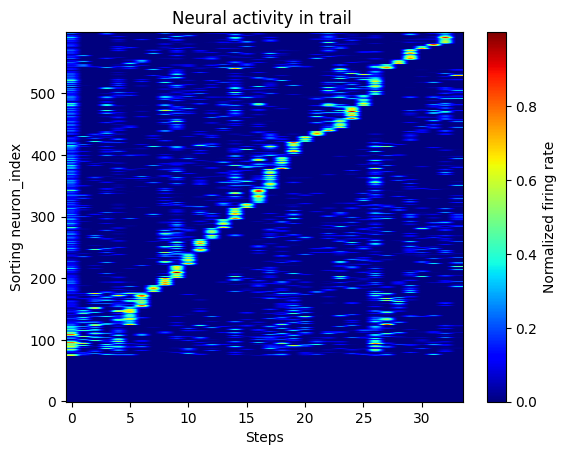

(34, 600)
(2.544, 4.811031437029974, 0.9167488355556708, 0.7764107825978951, 1.693, 0.20586030719029771, 0.8507718696397941)


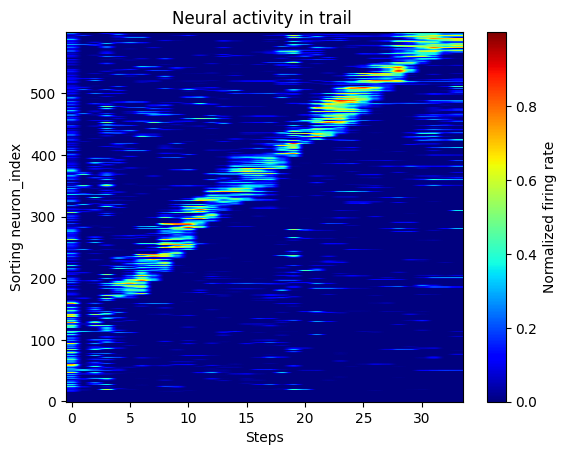

(34, 600)
2.014
(34, 600)
1.956
(34, 600)
2.161
(34, 600)
1.416
(34, 600)
0.979
(34, 600)
1.097
(2.0436666666666667, 0.04981372709813441) (1.164, 0.106571832843184)
t-value:  12.951706353288337
p-value:  0.0013139794733323979


In [26]:
netdir  = "/home/jiashuncheng/code/Trasient/RL/train_dir/mdf/20240116_MortarMayhem_v20_myrnn_alpha0.98_gate1_0.1_8.0_region1_comm3_lr2e-4_seed1/20240117_211124_sf_hidden_act_log.npy"
results = np.load(netdir)
hidden_act = results
print(hidden_act.shape)
data0 = hidden_act
print(cal_TI(data0,2,40))
data0 = normalization1(data0).T
B_mylstm = sorting(data0)
data0 = data0[B_mylstm,:]
num = len(data0)
fig=plt.imshow(data0, aspect='auto',cmap='jet')
plt.xlabel('Steps')
plt.gca().invert_yaxis()
plt.ylabel('Sorting neuron_index')
plt.title('Neural activity in trail ')#+ str(epoch) +'\n' +'ACC:' + str(acc))
plt.colorbar(fig, label="Normalized firing rate")
plt.show()

netdir  = "/home/jiashuncheng/code/Trasient/RL/train_dir/mdf/20240116_MortarMayhem_v20_myrnn_alpha0.98_gate0_0.1_8.0_region0_comm3_lr2e-4_seed1/20240117_211355_sf_hidden_act_log.npy"
results = np.load(netdir)
hidden_act = results
print(hidden_act.shape)
data0 = hidden_act
print(cal_TI(data0,2,40))
data0 = normalization1(data0).T
B_mylstm = sorting(data0)
data0 = data0[B_mylstm,:]
num = len(data0)
fig=plt.imshow(data0, aspect='auto',cmap='jet')
plt.xlabel('Steps')
plt.gca().invert_yaxis()
plt.ylabel('Sorting neuron_index')
plt.title('Neural activity in trail ')#+ str(epoch) +'\n' +'ACC:' + str(acc))
plt.colorbar(fig, label="Normalized firing rate")
plt.show()

comm3_trnn = sumTI("/home/jiashuncheng/code/Trasient/RL/train_dir/mdf/20240116_MortarMayhem_v20_myrnn_alpha0.98_gate1_0.1_8.0_region1_comm3_lr2e-4_seed1/20240117_211124_sf_hidden_act_log.npy",
"/home/jiashuncheng/code/Trasient/RL/train_dir/mdf/20240116_MortarMayhem_v20_myrnn_alpha0.98_gate1_0.1_8.0_region1_comm3_lr2e-4_seed2/20240117_211130_sf_hidden_act_log.npy",
"/home/jiashuncheng/code/Trasient/RL/train_dir/mdf/20240116_MortarMayhem_v20_myrnn_alpha0.98_gate1_0.1_8.0_region1_comm3_lr2e-4_seed3/20240117_211136_sf_hidden_act_log.npy",a=4,b=12)
comm3_rnn = sumTI("/home/jiashuncheng/code/Trasient/RL/train_dir/mdf/20240116_MortarMayhem_v20_myrnn_alpha0.98_gate0_0.1_8.0_region0_comm3_lr2e-4_seed1/20240117_211355_sf_hidden_act_log.npy",
"/home/jiashuncheng/code/Trasient/RL/train_dir/mdf/20240116_MortarMayhem_v20_myrnn_alpha0.98_gate0_0.1_8.0_region0_comm3_lr2e-4_seed2/20240117_211401_sf_hidden_act_log.npy",
"/home/jiashuncheng/code/Trasient/RL/train_dir/mdf/20240116_MortarMayhem_v20_myrnn_alpha0.98_gate0_0.1_8.0_region0_comm3_lr2e-4_seed3/20240117_211406_sf_hidden_act_log.npy",a=4,b=12)
print(comm3_trnn, comm3_rnn)
P_value(comm3_trnn,comm3_rnn,3)

## Comment=4

### Line

In [15]:
def smooth(x, length):
    a = [0]*len(x)
    a[:length] = x[:length]
    for i in range(length):
        a[i] = sum(x[0:i])/length
    for i in range(length, len(x)):
        a[i] = sum(x[i-length:i])/length
    return a

def data(*args):
    path = args
    ACC = []
    length = 100000
    for i in range(len(path)):
        df = pd.read_csv(path[i])
        step = df["Step"].values.tolist()
        reward = df["Value"].values.tolist()
        if len(reward)<length :
            length = len(reward)
        ACC.append(reward)
    for i in range(len(ACC)):
        ACC[i] = ACC[i][:length]
        ACC[i] = smooth(ACC[i], 10)
    step = step[:length]
    reward = np.stack(ACC, axis=0).mean(0)
    reward_std = np.stack(ACC, axis=0).std(0) / np.sqrt(3)
    print(reward.max(), reward_std[np.where(reward==reward.max())[0][0]])
    return step, reward, reward_std

def data2(*args):
    path = args
    ACC = []
    STEP = []
    length = 2e8
    for i in range(len(path)):
        ea = event_accumulator.EventAccumulator(path[i])
        ea.Reload()
        val = ea.scalars.Items("reward/reward")
        k = 0
        step = []
        reward = []
        for j in val:
            if j.step<=1e8:
                step.append(j.step)
                reward.append(j.value)
            else:
                break
        ACC.append(reward)
        print(step[-1])
        if len(step)<= length:
            STEP = step
            length = len(STEP)
    for i in range(len(ACC)):
        ACC[i] = ACC[i][-1*length:]
        ACC[i] = smooth(ACC[i], 10)
    step = STEP[-1*length:]
    reward = np.stack(ACC, axis=0).mean(0)
    reward_std = np.stack(ACC, axis=0).std(0) / np.sqrt(3)
    print(reward.max(), reward_std[np.where(reward==reward.max())[0][0]])
    return step, reward, reward_std

lambda_ = 1
step, reward_rnn_4, reward_std_rnn_4 = data2("/home/jiashuncheng/code/Trasient/RL/train_dir/mdf/20240116_MortarMayhem_v20_myrnn_alpha0.98_gate0_0.1_10.0_region0_comm4_lr2e-4_seed3/.summary/0/events.out.tfevents.1705398634.amax","/home/jiashuncheng/code/Trasient/RL/train_dir/mdf/20240116_MortarMayhem_v20_myrnn_alpha0.98_gate0_0.1_2.0_region0_comm4_lr2e-4_seed2/.summary/0/events.out.tfevents.1705392006.amax","/home/jiashuncheng/code/Trasient/RL/train_dir/mdf/20240116_MortarMayhem_v20_myrnn_alpha0.98_gate0_0.1_2.0_region0_comm4_lr2e-4_seed1/.summary/0/events.out.tfevents.1705392006.amax")
fig, ax = plt.subplots()
plt.plot(step,reward_rnn_4, label='RNN',color='C0')
plt.fill_between(step, reward_rnn_4+lambda_*reward_std_rnn_4, reward_rnn_4-lambda_*reward_std_rnn_4, alpha=0.3,color='C0')

step, reward_trnn_4, reward_std_trnn_4 = data2("/home/jiashuncheng/code/Trasient/RL/train_dir/mdf/20240116_MortarMayhem_v20_myrnn_alpha0.98_gate1_0.1_8.0_region1_comm4_lr2e-4_seed1/.summary/0/events.out.tfevents.1705391327.amax",
                                               "/home/jiashuncheng/code/Trasient/RL/train_dir/mdf/20240116_MortarMayhem_v20_myrnn_alpha0.98_gate1_0.1_8.0_region1_comm4_lr2e-4_seed2/.summary/0/events.out.tfevents.1705413107.amax",
                                               "/home/jiashuncheng/code/Trasient/RL/train_dir/mdf/20240116_MortarMayhem_v20_myrnn_alpha0.98_gate1_0.1_8.0_region1_comm4_lr2e-4_seed3/.summary/0/events.out.tfevents.1705391328.amax")
plt.plot(step,reward_trnn_4, label='TRNN',color='C1')
plt.fill_between(step, reward_trnn_4+lambda_*reward_std_trnn_4, reward_trnn_4-lambda_*reward_std_trnn_4, alpha=0.3,color='C1')

step, reward_nn_4, reward_std_nn_4 = data2("/home/jiashuncheng/code/Trasient/RL/train_dir/mdf/20240116_MortarMayhem_v20_myrnn_alpha0.98_gate0_0.1_2.0_region0_comm4_lr2e-4_seed1_no_history/.summary/0/events.out.tfevents.1705592999.titanX",
                                               "/home/jiashuncheng/code/Trasient/RL/train_dir/mdf/20240116_MortarMayhem_v20_myrnn_alpha0.98_gate0_0.1_2.0_region0_comm4_lr2e-4_seed2_no_history/.summary/0/events.out.tfevents.1705593000.titanX",
                                               "/home/jiashuncheng/code/Trasient/RL/train_dir/mdf/20240116_MortarMayhem_v20_myrnn_alpha0.98_gate0_0.1_2.0_region0_comm4_lr2e-4_seed3_no_history/.summary/0/events.out.tfevents.1705593000.titanX")
plt.plot(step,reward_nn_4, label='Feedwrad',color='C2')
plt.fill_between(step, reward_nn_4+lambda_*reward_std_nn_4, reward_nn_4-lambda_*reward_std_nn_4, alpha=0.3,color='C2')

plt.title("MortarMayhem",fontsize=16)
plt.yticks([0,0.1,0.2,0.3,0.4],fontsize=16)
plt.xticks([0,1e8],fontsize=16)
plt.ylabel('Reward', fontsize=16)
plt.xlabel('Frames', fontsize=16)
plt.legend(fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('figure/MortarMayhem.svg')
# plt.xlim([0, 2e8])
plt.show()

P_value([reward_rnn_4.max(), reward_std_rnn_4[np.where(reward_rnn_4==reward_rnn_4.max())[0][0]]], 
        [reward_trnn_4.max(), reward_std_trnn_4[np.where(reward_trnn_4==reward_trnn_4.max())[0][0]]], 3)

99989648
99993696
99997744
0.21823333352804183 0.008043538727799244
99993696
99981552
99993696
0.30649999777475995 0.016666600396962356
99989648
99977504
99977504
0.08256666734814644 0.0024066267371934324


t-value:  -8.26120663336557
p-value:  0.004295751121193175


### TI

tensor(0.8851, device='cuda:0') tensor(0.2134, device='cuda:0')
(46, 600)
(2.217, 4.758932621580023, 0.9068213326859208, 0.5242747665026933, 1.431, 0.12611246555130395, 0.7857142857142857)


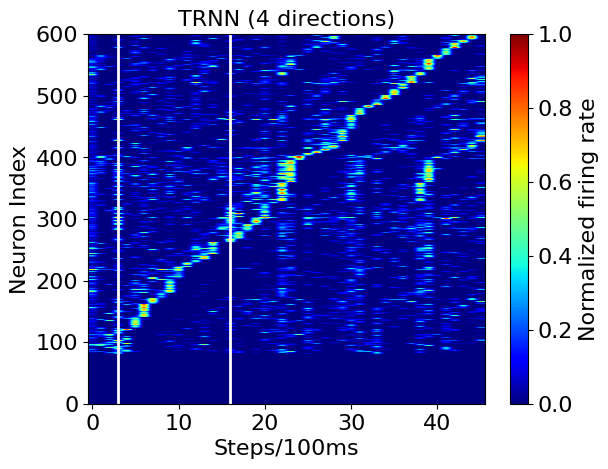

(46, 600)
(2.249, 4.562476382744389, 0.8693863188957393, 0.6797604594021583, 1.549, 0.191438425244493, 0.6998313659359191)


(46, 600)
2.138
(46, 600)
2.151
(46, 600)
2.148
(46, 600)
1.53
(46, 600)
1.729
(46, 600)
1.729
(2.1456666666666666, 0.0032087842395985893) (1.6626666666666667, 0.054160939868205846)
t-value:  15.41915985679769
p-value:  0.004059057752256571


In [28]:
checkpoint = torch.load("/home/jiashuncheng/code/Trasient/RL/train_dir/MortarMayhem_v20_myrnn_alpha_theta_region_comm2_3/checkpoint_p0/checkpoint_000002920_2955040.pth")
print(checkpoint['model']['core.core.w_in'].max(), checkpoint['model']['core.core.m'].min())

netdir  = "/home/jiashuncheng/code/Trasient/RL/train_dir/mdf/20240116_MortarMayhem_v20_myrnn_alpha0.98_gate1_0.1_8.0_region1_comm4_lr2e-4_seed1/20240117_205111_sf_hidden_act_log.npy"
results = np.load(netdir)
hidden_act = results
print(hidden_act.shape)
data0 = hidden_act
print(cal_TI(data0,2,40))
data0 = normalization1(data0).T
B_mylstm = sorting(data0)
data0 = data0[B_mylstm,:]
num = len(data0)
fig=plt.imshow(data0, aspect='auto',cmap='jet')
plt.vlines(x=3,ymin=0,ymax=600,linewidth=2,color='white')
plt.vlines(x=16,ymin=0,ymax=600,linewidth=2,color='white')
plt.ylim([0,600])
plt.xlabel('Steps/100ms', fontsize=16)
plt.ylabel('Neuron Index', fontsize=16)
plt.title('TRNN (4 directions)', fontsize=16)#+ str(epoch) +'\n' +'ACC:' + str(acc))
cb=plt.colorbar(fig)
cb.set_label("Normalized firing rate",fontdict={'size':16})
cb.set_ticks([0,0.2,0.4,0.6,0.8,1])
cb.ax.tick_params(labelsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('figure/suppfig4b5.svg')
plt.show()

netdir  = "/home/jiashuncheng/code/Trasient/RL/train_dir/mdf/20240116_MortarMayhem_v20_myrnn_alpha0.98_gate0_0.1_10.0_region0_comm4_lr2e-4_seed3/20240117_204527_sf_hidden_act_log.npy"
results = np.load(netdir)
hidden_act = results
print(hidden_act.shape)
data0 = hidden_act
print(cal_TI(data0,2,40))
data0 = normalization1(data0).T
B_mylstm = sorting(data0)
data0 = data0[B_mylstm,:]
num = len(data0)
fig=plt.imshow(data0, aspect='auto',cmap='jet')
plt.vlines(x=3,ymin=0,ymax=600,linewidth=2,color='white')
plt.vlines(x=16,ymin=0,ymax=600,linewidth=2,color='white')
plt.ylim([0,600])
plt.xlabel('Steps/100ms', fontsize=16)
plt.ylabel('Neuron Index', fontsize=16)
plt.title('RNN (4 directions)', fontsize=16)#+ str(epoch) +'\n' +'ACC:' + str(acc))
cb=plt.colorbar(fig)
cb.set_label("Normalized firing rate",fontdict={'size':16})
cb.set_ticks([0,0.2,0.4,0.6,0.8,1])
cb.ax.tick_params(labelsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('figure/suppfig4b6.svg')
plt.show()

comm4_trnn = sumTI("/home/jiashuncheng/code/Trasient/RL/train_dir/mdf/20240116_MortarMayhem_v20_myrnn_alpha0.98_gate1_0.1_8.0_region1_comm4_lr2e-4_seed1/20240117_205111_sf_hidden_act_log.npy",
"/home/jiashuncheng/code/Trasient/RL/train_dir/mdf/20240116_MortarMayhem_v20_myrnn_alpha0.98_gate1_0.1_8.0_region1_comm4_lr2e-4_seed2/20240117_205117_sf_hidden_act_log.npy",
"/home/jiashuncheng/code/Trasient/RL/train_dir/mdf/20240116_MortarMayhem_v20_myrnn_alpha0.98_gate1_0.1_8.0_region1_comm4_lr2e-4_seed3/20240117_205123_sf_hidden_act_log.npy")
comm4_rnn = sumTI("/home/jiashuncheng/code/Trasient/RL/train_dir/mdf/20240116_MortarMayhem_v20_myrnn_alpha0.98_gate0_0.1_10.0_region0_comm4_lr2e-4_seed3/20240117_204527_sf_hidden_act_log.npy",
"/home/jiashuncheng/code/Trasient/RL/train_dir/mdf/20240116_MortarMayhem_v20_myrnn_alpha0.98_gate0_0.1_2.0_region0_comm4_lr2e-4_seed1/20240117_204539_sf_hidden_act_log.npy",
"/home/jiashuncheng/code/Trasient/RL/train_dir/mdf/20240116_MortarMayhem_v20_myrnn_alpha0.98_gate0_0.1_2.0_region0_comm4_lr2e-4_seed1/20240117_204539_sf_hidden_act_log.npy")
print(comm4_trnn, comm4_rnn)
P_value(comm4_trnn,comm4_rnn,3)

### Success bar

In [30]:
error_params=dict(elinewidth=1,capsize=5)   
from matplotlib import ticker
def data(*args):
    ACC = []
    for j in range(len(args)):
        filepath = args[j]
        file = open(filepath, 'r')
        string = file.readlines()
        file.close()
        y = []
        for i in range(len(string)):
            x = string[i].split('\n')[0]
            x = x.split('[')[1].split(']')[0].split(', ')
            x1 = []
            for k in range(4):
                x1.append(float(x[k]))
            y.append(x1)
        ACC = y[:100]
    mean_ = np.mean(ACC, axis=0)
    std_ = np.std(ACC, axis=0)
    print(mean_, std_)
    return mean_, std_/np.sqrt(100)
value1, value1_std = data("/home/jiashuncheng/code/Trasient/RL/train_dir/mdf/20240116_MortarMayhem_v20_myrnn_alpha0.98_gate0_0.1_10.0_region0_comm4_lr2e-4_seed3/20240117_212104_sf_success_list_log.txt")

value2, value2_std = data("/home/jiashuncheng/code/Trasient/RL/train_dir/mdf/20240116_MortarMayhem_v20_myrnn_alpha0.98_gate1_0.1_8.0_region1_comm4_lr2e-4_seed1/20240117_211855_sf_success_list_log.txt")

x = range(4)
fig, ax = plt.subplots()
bar1 = plt.bar([i - 0.1 for i in x],value1,yerr=value1_std,error_kw=error_params,width = 0.2,
               alpha = 0.8,color = 'C0',label = 'RNN')

bar3 = plt.bar([i + 0.1 for i in x],value2,yerr=value2_std,error_kw=error_params,width = 0.2,
               alpha = 0.8,color = 'C1',label = 'TRNN')
plt.ylabel('Accuracy',fontsize=16)       #y轴的标签
plt.xlabel('Number', fontsize=16)  
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
plt.yticks(fontsize=16)
plt.xticks(range(4), ['1st','2nd','3rd','4th'], fontsize=16)
plt.legend(fontsize=16)            #设置图例
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('figure/4accuracy.svg')
plt.show()
for i in range(4):
    print(i,':')
    P_value([value1[i], value1_std[i]], [value2[i], value2_std[i]], 100)

[0.68 0.72 0.6  0.29] [0.46647615 0.44899889 0.48989795 0.45376205]
[1.   0.83 0.74 0.84] [0.         0.3756328  0.43863424 0.36660606]


0 :
t-value:  -68.59943405700358
p-value:  2.806091316228273e-85
1 :
t-value:  -18.79038302722677
p-value:  2.2299992969080197e-45
2 :
t-value:  -21.29046726353658
p-value:  7.859278535175179e-53
3 :
t-value:  -94.28263571929925
p-value:  2.929827112181097e-161


## Comment=6

### Line

99991360
99983520
99991360
0.17199999888737993 0.003919467131843184
99991360
99991360
99999200
0.2405333330233892 0.01716562001568119


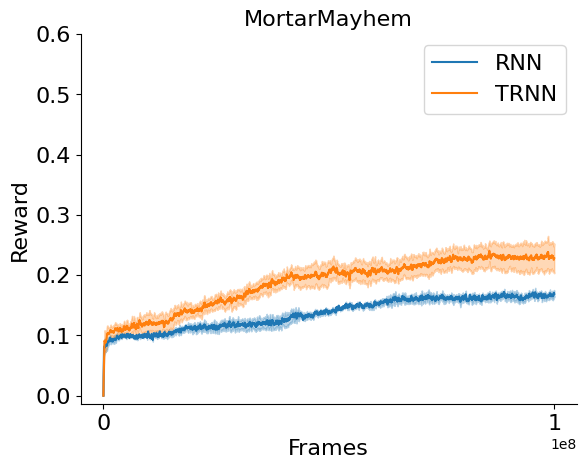

t-value:  -6.741664229855486
p-value:  0.016393389093638838


In [9]:
def smooth(x, length):
    a = [0]*len(x)
    a[:length] = x[:length]
    for i in range(length):
        a[i] = sum(x[0:i])/length
    for i in range(length, len(x)):
        a[i] = sum(x[i-length:i])/length
    return a

def data(*args):
    path = args
    ACC = []
    length = 100000
    for i in range(len(path)):
        df = pd.read_csv(path[i])
        step = df["Step"].values.tolist()
        reward = df["Value"].values.tolist()
        if len(reward)<length :
            length = len(reward)
        ACC.append(reward)
    for i in range(len(ACC)):
        ACC[i] = ACC[i][:length]
        ACC[i] = smooth(ACC[i], 10)
    step = step[:length]
    reward = np.stack(ACC, axis=0).mean(0)
    reward_std = np.stack(ACC, axis=0).std(0) / np.sqrt(3)
    print(reward.max(), reward_std[np.where(reward==reward.max())[0][0]])
    return step, reward, reward_std

def data2(*args):
    path = args
    ACC = []
    STEP = []
    length = 2e8
    for i in range(len(path)):
        ea = event_accumulator.EventAccumulator(path[i])
        ea.Reload()
        val = ea.scalars.Items("reward/reward")
        k = 0
        step = []
        reward = []
        for j in val:
            if j.step<=1e8:
                step.append(j.step)
                reward.append(j.value)
            else:
                break
        ACC.append(reward)
        print(step[-1])
        if len(step)<= length:
            STEP = step
            length = len(STEP)
    for i in range(len(ACC)):
        ACC[i] = ACC[i][-1*length:]
        ACC[i] = smooth(ACC[i], 10)
    step = STEP[-1*length:]
    reward = np.stack(ACC, axis=0).mean(0)
    reward_std = np.stack(ACC, axis=0).std(0) / np.sqrt(3)
    print(reward.max(), reward_std[np.where(reward==reward.max())[0][0]])
    return step, reward, reward_std


lambda_ = 1
step, reward_rnn_6, reward_std_rnn_6 = data2("/home/jiashuncheng/code/Trasient/RL/train_dir/mdf/20240116_MortarMayhem_v20_myrnn_alpha0.98_gate0_0.1_8.0_region0_comm6_lr2e-4_seed1/.summary/0/events.out.tfevents.1705433372.amax",
"/home/jiashuncheng/code/Trasient/RL/train_dir/mdf/20240116_MortarMayhem_v20_myrnn_alpha0.98_gate0_0.1_8.0_region0_comm6_lr2e-4_seed2/.summary/0/events.out.tfevents.1705433372.amax",
"/home/jiashuncheng/code/Trasient/RL/train_dir/mdf/20240116_MortarMayhem_v20_myrnn_alpha0.98_gate0_0.1_8.0_region0_comm6_lr2e-4_seed3/.summary/0/events.out.tfevents.1705433373.amax")
fig, ax = plt.subplots()
plt.plot(step,reward_rnn_6, label='RNN',color='C0')
plt.fill_between(step, reward_rnn_6+lambda_*reward_std_rnn_6, reward_rnn_6-lambda_*reward_std_rnn_6, alpha=0.3,color='C0')

step, reward_trnn_6, reward_std_trnn_6 = data2("/home/jiashuncheng/code/Trasient/RL/train_dir/mdf/20240116_MortarMayhem_v20_myrnn_alpha0.98_gate1_0.1_8.0_region1_comm6_lr2e-4_seed1/.summary/0/events.out.tfevents.1705433252.amax",
"/home/jiashuncheng/code/Trasient/RL/train_dir/mdf/20240116_MortarMayhem_v20_myrnn_alpha0.98_gate1_0.1_8.0_region1_comm6_lr2e-4_seed2/.summary/0/events.out.tfevents.1705433252.amax",
"/home/jiashuncheng/code/Trasient/RL/train_dir/mdf/20240116_MortarMayhem_v20_myrnn_alpha0.98_gate1_0.1_8.0_region1_comm6_lr2e-4_seed3/.summary/0/events.out.tfevents.1705433253.amax")
plt.plot(step,reward_trnn_6, label='TRNN',color='C1')
plt.fill_between(step, reward_trnn_6+lambda_*reward_std_trnn_6, reward_trnn_6-lambda_*reward_std_trnn_6, alpha=0.3,color='C1')

plt.title("MortarMayhem",fontsize=16)
plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6],fontsize=16)
plt.xticks([0,1e8],fontsize=16)
plt.ylabel('Reward', fontsize=16)
plt.xlabel('Frames', fontsize=16)
plt.legend(fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.savefig('figure/MortarMayhem2.svg')
# plt.xlim([0, 2e8])
plt.show()

P_value([reward_rnn_6.max(), reward_std_rnn_6[np.where(reward_rnn_6==reward_rnn_6.max())[0][0]]], 
        [reward_trnn_6.max(), reward_std_trnn_6[np.where(reward_trnn_6==reward_trnn_6.max())[0][0]]], 3)

### TI

In [ ]:
comm6_trnn = sumTI("/home/jiashuncheng/code/Trasient/RL/train_dir/MortarMayhem_v20_myrnn_alpha_theta_region_comm6_1_1/20231030_170540_sf_hidden_act_log.npy",
"/home/jiashuncheng/code/Trasient/RL/train_dir/MortarMayhem_v20_myrnn_alpha_theta_region_comm6_2_1/20231030_170611_sf_hidden_act_log.npy",
"/home/jiashuncheng/code/Trasient/RL/train_dir/MortarMayhem_v20_myrnn_alpha_theta_region_comm6_3_2/20231030_170620_sf_hidden_act_log.npy",a=4,b=24)
comm6_rnn = sumTI("/home/jiashuncheng/code/Trasient/RL/train_dir/MortarMayhem_v20_myrnn_comm6_1_1/20231030_170643_sf_hidden_act_log.npy",
"/home/jiashuncheng/code/Trasient/RL/train_dir/MortarMayhem_v20_myrnn_comm6_2_1/20231030_170652_sf_hidden_act_log.npy",
"/home/jiashuncheng/code/Trasient/RL/train_dir/MortarMayhem_v20_myrnn_comm6_3_1/20231030_170702_sf_hidden_act_log.npy",a=4,b=24)
print(comm6_trnn, comm6_rnn)
P_value(comm6_trnn,comm6_rnn,3)

(70, 600)
True
1.893
(70, 600)
True
1.983
(70, 600)
True
1.928
(70, 600)
True
0.962
(70, 600)
True
1.395
(70, 600)
True
1.07
(1.9346666666666668, 0.021387085061022423) (1.1423333333333334, 0.10624534848205862)
t-value:  12.662898976702975
p-value:  0.004565054771273427


### Success bar

[0.29 0.29 0.18 0.14 0.07 0.11] [0.45376205 0.45376205 0.38418745 0.34698703 0.25514702 0.31288976]
[0.8  0.93 0.77 0.5  0.27 0.2 ] [0.4        0.25514702 0.42083251 0.5        0.44395946 0.4       ]


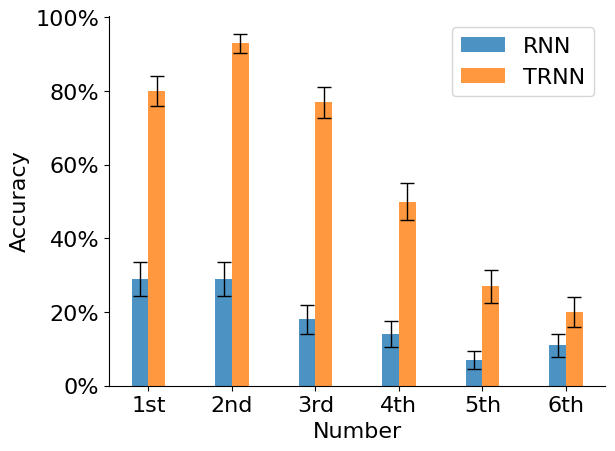

0 :
t-value:  -84.31191843418065
p-value:  2.4277221923892895e-155
1 :
t-value:  -122.94060006324786
p-value:  3.966216973010782e-157
2 :
t-value:  -103.54064530145905
p-value:  2.6125132982211763e-173
3 :
t-value:  -59.151670191069734
p-value:  2.944572962481832e-118
4 :
t-value:  -39.058328343225334
p-value:  4.531673924949652e-83
5 :
t-value:  -17.722167558022747
p-value:  6.761849762219257e-42


In [ ]:
error_params=dict(elinewidth=1,capsize=5)   
from matplotlib import ticker
def data(*args):
    ACC = []
    for j in range(len(args)):
        filepath = args[j]
        file = open(filepath, 'r')
        string = file.readlines()
        file.close()
        y = []
        for i in range(len(string)):
            x = string[i].split('\n')[0]
            x = x.split('[')[1].split(']')[0].split(', ')
            x1 = []
            for k in range(6):
                x1.append(float(x[k]))
            y.append(x1)
        ACC = y[:100]
    mean_ = np.mean(ACC, axis=0)
    std_ = np.std(ACC, axis=0)
    print(mean_, std_)
    return mean_, std_/np.sqrt(100)
value1, value1_std = data("/home/jiashuncheng/code/Trasient/RL/train_dir/MortarMayhem_v20_myrnn_comm6_1_1/20231030_195758_sf_success_list_log.txt")

value2, value2_std = data("/home/jiashuncheng/code/Trasient/RL/train_dir/MortarMayhem_v20_myrnn_alpha_theta_region_comm6_1_1/20231030_195652_sf_success_list_log.txt")

x = range(6)
fig, ax = plt.subplots()
bar1 = plt.bar([i - 0.1 for i in x],value1,yerr=value1_std,error_kw=error_params,width = 0.2,
               alpha = 0.8,color = 'C0',label = 'RNN')

bar3 = plt.bar([i + 0.1 for i in x],value2,yerr=value2_std,error_kw=error_params,width = 0.2,
               alpha = 0.8,color = 'C1',label = 'TRNN')
plt.ylabel('Accuracy',fontsize=16)       #y轴的标签
plt.xlabel('Number', fontsize=16)  
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
plt.yticks(fontsize=16)
plt.xticks(range(6), ['1st','2nd','3rd','4th','5th','6th'], fontsize=16)
plt.legend(fontsize=16)            #设置图例
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('figure/6accuracy.svg')
plt.show()
for i in range(6):
    print(i,':')
    P_value([value1[i], value1_std[i]], [value2[i], value2_std[i]], 100)

## Reward bar

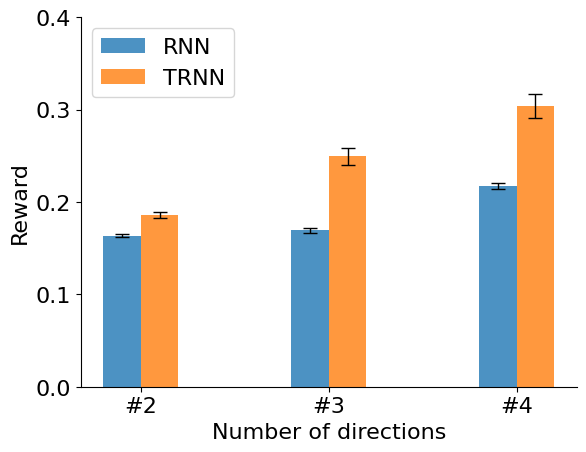

t-value:  -6.036525846573704
p-value:  0.009265645645712627
t-value:  -8.602233370019103
p-value:  0.008238764144007508
t-value:  -6.430204585461998
p-value:  0.017666557511654347


In [17]:
x = range(3) 
error_params=dict(elinewidth=1,capsize=5)              

# value1 = [reward_rnn_2.max(), reward_rnn_3.max(), reward_rnn_4.max()]
# value1_std = [reward_std_rnn_2[np.where(reward_rnn_2==reward_rnn_2.max())[0][0]],
#               reward_std_rnn_3[np.where(reward_rnn_3==reward_rnn_3.max())[0][0]],
#               reward_std_rnn_4[np.where(reward_rnn_4==reward_rnn_4.max())[0][0]]]
# value3 = [reward_trnn_2.max(), reward_trnn_3.max(), reward_trnn_4.max()]
# value3_std = [reward_std_trnn_2[np.where(reward_trnn_2==reward_trnn_2.max())[0][0]],
#               reward_std_trnn_3[np.where(reward_trnn_3==reward_trnn_3.max())[0][0]],
#               reward_std_trnn_4[np.where(reward_trnn_4==reward_trnn_4.max())[0][0]]]

value1 = [reward_rnn_2[-1], reward_rnn_3[-1], reward_rnn_4[-1]]
value1_std = [reward_std_rnn_2[np.where(reward_rnn_2==reward_rnn_2[-1])[0][0]],
              reward_std_rnn_3[np.where(reward_rnn_3==reward_rnn_3[-1])[0][0]],
              reward_std_rnn_4[np.where(reward_rnn_4==reward_rnn_4[-1])[0][0]]]
value3 = [reward_trnn_2[-1], reward_trnn_3[-1], reward_trnn_4[-1]]
value3_std = [reward_std_trnn_2[np.where(reward_trnn_2==reward_trnn_2[-1])[0][0]],
              reward_std_trnn_3[np.where(reward_trnn_3==reward_trnn_3[-1])[0][0]],
              reward_std_trnn_4[np.where(reward_trnn_4==reward_trnn_4[-1])[0][0]]]
fig, ax = plt.subplots()
bar1 = plt.bar([i - 0.1 for i in x],value1,yerr=value1_std/np.sqrt(3),error_kw=error_params,width = 0.2,
               alpha = 0.8,color = 'C0',label = 'RNN')

bar3 = plt.bar([i + 0.1 for i in x],value3,yerr=value3_std/np.sqrt(3),error_kw=error_params,width = 0.2,
               alpha = 0.8,color = 'C1',label = 'TRNN')

plt.ylabel('Reward',fontsize=16)       #y轴的标签
plt.xlabel('Number of directions', fontsize=16)  
plt.yticks([0,0.1,0.2,0.3,0.4],fontsize=16)
plt.xticks([0, 1, 2], ['#2', '#3', '#4'], fontsize=16)
plt.legend(fontsize=16)            #设置图例
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('figure/direction.svg')
plt.show()

t_stat, p_value = scipy.stats.ttest_ind_from_stats(value1[0], value1_std[0], 3, value3[0], value3_std[0], 3, equal_var=False)
print("t-value: ", t_stat)
print("p-value: ", p_value)
t_stat, p_value = scipy.stats.ttest_ind_from_stats(value1[1], value1_std[1], 3, value3[1], value3_std[1], 3, equal_var=False)
print("t-value: ", t_stat)
print("p-value: ", p_value)
t_stat, p_value = scipy.stats.ttest_ind_from_stats(value1[2], value1_std[2], 3, value3[2], value3_std[2], 3, equal_var=False)
print("t-value: ", t_stat)
print("p-value: ", p_value)

## TI bar

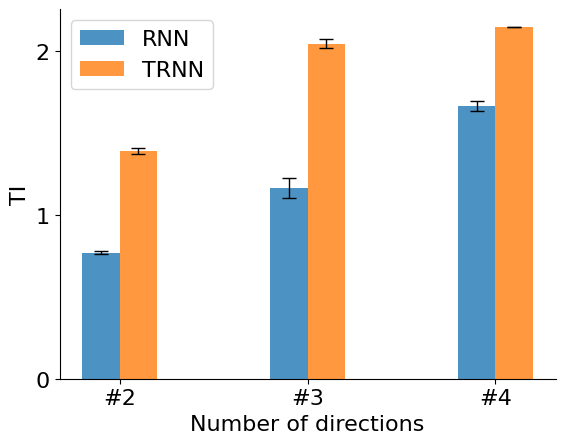

t-value:  -31.041224059900888
p-value:  0.00010093454610544475
t-value:  -12.951706353288337
p-value:  0.0013139794733323979
t-value:  -15.41915985679769
p-value:  0.004059057752256571


In [31]:
x = range(3) 
error_params=dict(elinewidth=1,capsize=5)              

value1 = [comm2_rnn[0], comm3_rnn[0], comm4_rnn[0]]
value1_std = [comm2_rnn[1],
              comm3_rnn[1],
              comm4_rnn[1]]
value3 = [comm2_trnn[0].max(), comm3_trnn[0].max(), comm4_trnn[0].max()]
value3_std = [comm2_trnn[1],
              comm3_trnn[1],
              comm4_trnn[1]]
fig, ax = plt.subplots()
bar1 = plt.bar([i - 0.1 for i in x],value1,yerr=value1_std/np.sqrt(3),error_kw=error_params,width = 0.2,
               alpha = 0.8,color = 'C0',label = 'RNN')

# bar2 = plt.bar([i + 0 for i in x],value2,yerr=value2_std/np.sqrt(3),error_kw=error_params,width = 0.2,
#                alpha = 0.8,color = 'C1',label = 'RNN with transient neuron')

bar3 = plt.bar([i + 0.1 for i in x],value3,yerr=value3_std/np.sqrt(3),error_kw=error_params,width = 0.2,
               alpha = 0.8,color = 'C1',label = 'TRNN')

plt.ylabel('TI',fontsize=16)       #y轴的标签
plt.xlabel('Number of directions', fontsize=16)  
plt.yticks([0,1,2],fontsize=16)
plt.xticks([0, 1, 2], ['#2', '#3', '#4'], fontsize=16)
plt.legend(fontsize=16)            #设置图例
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('figure/supp_direction_ti2.svg')
plt.show()

t_stat, p_value = scipy.stats.ttest_ind_from_stats(value1[0], value1_std[0], 3, value3[0], value3_std[0], 3, equal_var=False)
print("t-value: ", t_stat)
print("p-value: ", p_value)
t_stat, p_value = scipy.stats.ttest_ind_from_stats(value1[1], value1_std[1], 3, value3[1], value3_std[1], 3, equal_var=False)
print("t-value: ", t_stat)
print("p-value: ", p_value)
t_stat, p_value = scipy.stats.ttest_ind_from_stats(value1[2], value1_std[2], 3, value3[2], value3_std[2], 3, equal_var=False)
print("t-value: ", t_stat)
print("p-value: ", p_value)

# Watermaze2d

In [27]:
for kk in range(14, 12, -1):
    size=kk
    y = []
    for i in range(size):
        x = (np.random.randint(1,size-1), np.random.randint(1,size-1))
        y.append(x)
    print(kk, y)

14 [(1, 9), (1, 11), (6, 6), (3, 7), (4, 5), (4, 4), (6, 7), (8, 3), (2, 9), (6, 11), (7, 5), (7, 8), (12, 1), (3, 7)]
13 [(7, 8), (6, 3), (6, 3), (1, 2), (7, 3), (1, 6), (10, 6), (9, 3), (9, 10), (4, 3), (10, 2), (9, 2), (4, 6)]


### Line

9994240
9998336
9998336
34.0426664352417 1.4929846493064096
9994240
9998336
9994240
127.29133173624673 6.639193526566354
9998336
9998336
9998336
35.12200012207031 1.0682231591826448


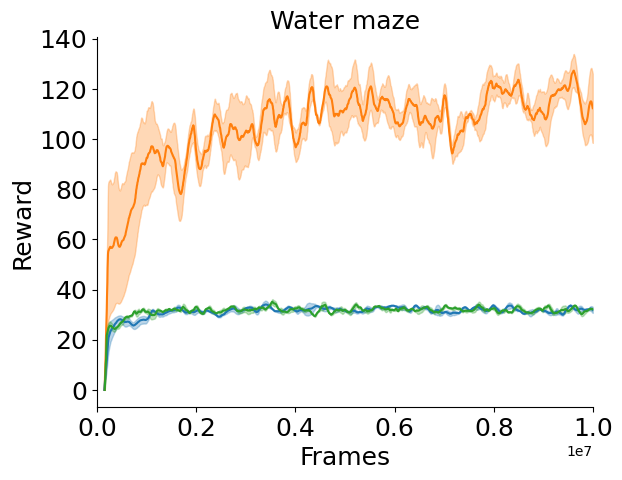

In [7]:
def smooth(x, length):
    a = [0]*len(x)
    a[:length] = x[:length]
    for i in range(length):
        a[i] = sum(x[0:i])/length
    for i in range(length, len(x)):
        a[i] = sum(x[i-length:i])/length
    return a

def data(*args):
    path = args
    ACC = []
    length = 100000
    for i in range(len(path)):
        df = pd.read_csv(path[i])
        step = df["Step"].values.tolist()
        reward = df["Value"].values.tolist()
        if len(reward)<length :
            length = len(reward)
        ACC.append(reward)
    for i in range(len(ACC)):
        ACC[i] = ACC[i][:length]
        ACC[i] = smooth(ACC[i], 10)
    step = step[:length]
    reward = np.stack(ACC, axis=0).mean(0)
    reward_std = np.stack(ACC, axis=0).std(0) / np.sqrt(3)
    print(reward.max(), reward_std[np.where(reward==reward.max())[0][0]])
    return step, reward, reward_std

def data2(*args):
    path = args
    ACC = []
    STEP = []
    length = 1.2e7
    for i in range(len(path)):
        ea = event_accumulator.EventAccumulator(path[i])
        ea.Reload()
        val = ea.scalars.Items("reward/reward")
        k = 0
        step = []
        reward = []
        for j in val:
            if j.step<=1e7:
                step.append(j.step)
                reward.append(j.value)
            else:
                break
        ACC.append(reward)
        print(step[-1])
        if len(step)<= length:
            STEP = step
            length = len(STEP)
    for i in range(len(ACC)):
        ACC[i] = ACC[i][-1*length:]
        ACC[i] = smooth(ACC[i], 10)
    step = STEP[-1*length:]
    reward = np.stack(ACC, axis=0).mean(0)
    reward_std = np.stack(ACC, axis=0).std(0) / np.sqrt(3)
    print(reward.max(), reward_std[np.where(reward==reward.max())[0][0]])
    return step, reward, reward_std

lambda_ = 1
step, reward, reward_std = data2("/home/jiashuncheng/code/Trasient/RL/train_dir/watermaze_116/20240117_Watermaze2d_hard_v10_myrnn_alpha0.98_gate0_0.1_2.0_region0_lr_1e-3_seed1_size11/.summary/0/events.out.tfevents.1705501038.snn-ESC4000-G3-Series",
                    "/home/jiashuncheng/code/Trasient/RL/train_dir/watermaze_116/20240117_Watermaze2d_hard_v10_myrnn_alpha0.98_gate0_0.1_2.0_region0_lr_1e-3_seed2_size11/.summary/0/events.out.tfevents.1705501038.snn-ESC4000-G3-Series",
                    "/home/jiashuncheng/code/Trasient/RL/train_dir/watermaze_116/20240117_Watermaze2d_hard_v10_myrnn_alpha0.98_gate0_0.1_2.0_region0_lr_1e-3_seed3_size11/.summary/0/events.out.tfevents.1705504089.titanX")
fig, ax = plt.subplots()
plt.plot(step,reward, label='RNN',color='C0')
plt.fill_between(step, reward+lambda_*reward_std, reward-lambda_*reward_std, alpha=0.3,color='C0')

step, reward, reward_std = data2("/home/jiashuncheng/code/Trasient/RL/train_dir/watermaze_116/20240116_Watermaze2d_hard_v8_myrnn_alpha0.98_gate1_0.1_3.0_region1_lr_1e-3_seed1_size11/.summary/0/events.out.tfevents.1705508335.snn-ESC4000-G3-Series",
                                "/home/jiashuncheng/code/Trasient/RL/train_dir/watermaze_116/20240116_Watermaze2d_hard_v8_myrnn_alpha0.98_gate1_0.1_3.0_region1_lr_1e-3_seed2_size11/.summary/0/events.out.tfevents.1705505025.titanX",
                                "/home/jiashuncheng/code/Trasient/RL/train_dir/watermaze_116/20240116_Watermaze2d_hard_v8_myrnn_alpha0.98_gate1_0.1_3.0_region1_lr_1e-3_seed3_size11/.summary/0/events.out.tfevents.1705508336.snn-ESC4000-G3-Series")
plt.plot(step,reward, label='TRNN',color='C1')
plt.fill_between(step, reward+lambda_*reward_std, reward-lambda_*reward_std, alpha=0.3,color='C1')

step, reward, reward_std = data2("/home/jiashuncheng/code/Trasient/RL/train_dir/watermaze_116/20240116_Watermaze2d_hard_v8_myrnn_alpha0.98_gate0_0.1_3.0_region0_lr_1e-3_seed1_size11_no_history/.summary/0/events.out.tfevents.1705580159.titanX",
                                "/home/jiashuncheng/code/Trasient/RL/train_dir/watermaze_116/20240116_Watermaze2d_hard_v8_myrnn_alpha0.98_gate0_0.1_3.0_region0_lr_1e-3_seed2_size11_no_history/.summary/0/events.out.tfevents.1705580160.titanX",
                                "/home/jiashuncheng/code/Trasient/RL/train_dir/watermaze_116/20240116_Watermaze2d_hard_v8_myrnn_alpha0.98_gate0_0.1_3.0_region0_lr_1e-3_seed3_size11_no_history/.summary/0/events.out.tfevents.1705580868.titanX")
plt.plot(step,reward, label='Feedword',color='C2')
plt.fill_between(step, reward+lambda_*reward_std, reward-lambda_*reward_std, alpha=0.3,color='C2')

plt.title("Water maze",fontsize=18)
plt.yticks([0,20,40,60,80,100,120,140],fontsize=18)
plt.xticks(fontsize=18)
plt.ylabel('Reward', fontsize=18)
plt.xlabel('Frames', fontsize=18)
# plt.legend(fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('figure/Watermaze.svg')
plt.xlim([0, 1e7])
plt.show()

### Bar

In [5]:
def Value(*filepath, index1=200, index2=300):
    Y = []
    ll = 1e8
    for i in range(len(filepath)):
        file = open(filepath[i], 'r')
        string = file.readlines()
        file.close()
        y = []
        l = 0
        for i in range(len(string)):
            if "DeltaFirstR" in string[i]:
                x = string[i].split('[')[1].split(']')[0]
                if x != '':
                    x = x.split(", ")
                    x = [int(j) for j in x]
                    if len(x) >= NUMBER :
                        y.append(x[:NUMBER])
                        l+=1
        if l<=ll:
            ll=l
        y = np.array(y)
        Y.append(y)
    for i in range(len(Y)):
        print(np.array(Y[i][index1:index2,:]).shape)
        Y[i] = np.array(Y[i][index1:index2,:]).mean(0)
        print(Y[i].shape)
    Y = np.array(Y).reshape(-1, NUMBER)
    print(Y.shape)
    return Y

NUMBER = 3

value2 = Value('/home/jiashuncheng/code/Trasient/RL/train_dir/watermaze_116/20240117_Watermaze2d_hard_v10_myrnn_alpha0.98_gate0_0.1_2.0_region0_lr_1e-3_seed1_size11/20240118_014731_sf_test_log.txt',
        '/home/jiashuncheng/code/Trasient/RL/train_dir/watermaze_116/20240117_Watermaze2d_hard_v10_myrnn_alpha0.98_gate0_0.1_2.0_region0_lr_1e-3_seed2_size11/20240118_014752_sf_test_log.txt',
        '/home/jiashuncheng/code/Trasient/RL/train_dir/watermaze_116/20240117_Watermaze2d_hard_v10_myrnn_alpha0.98_gate0_0.1_2.0_region0_lr_1e-3_seed3_size11/20240118_014810_sf_test_log.txt')
value4 = Value('/home/jiashuncheng/code/Trasient/RL/train_dir/watermaze_116/20240116_Watermaze2d_hard_v8_myrnn_alpha0.98_gate1_0.1_3.0_region1_lr_1e-3_seed1_size11/20240118_014558_sf_test_log.txt',
               '/home/jiashuncheng/code/Trasient/RL/train_dir/watermaze_116/20240116_Watermaze2d_hard_v8_myrnn_alpha0.98_gate1_0.1_3.0_region1_lr_1e-3_seed2_size11/20240118_014652_sf_test_log.txt',
               '/home/jiashuncheng/code/Trasient/RL/train_dir/watermaze_116/20240116_Watermaze2d_hard_v8_myrnn_alpha0.98_gate1_0.1_3.0_region1_lr_1e-3_seed3_size11/20240118_014713_sf_test_log.txt')

x = range(NUMBER)
error_params=dict(elinewidth=1,capsize=5)
fig, ax = plt.subplots()
# bar1 = plt.bar([i - 0.2 for i in x],value1.mean(0)/value1.mean(0)[0],yerr=value1.std(0)/np.sqrt(value1.shape[0])/value1.mean(0)[0],error_kw=error_params,width = 0.2,
#                alpha = 0.8,color = 'C2',label = 'Identity')                 

bar2 = plt.bar([i - 0.1 for i in x],value2.mean(0),yerr=value2.std(0)/np.sqrt(value2.shape[0]),error_kw=error_params,width = 0.2,
               alpha = 0.8,color = 'C0',label = 'RNN')

# bar3 = plt.bar([i + 0.1 for i in x],value3.mean(0),yerr=value3.std(0)/np.sqrt(value3.shape[0]),error_kw=error_params,width = 0.2,
#                alpha = 0.8,color = 'C2',label = 'RNN with transient neuron')

bar4 = plt.bar([i + 0.1 for i in x],value4.mean(0),yerr=value4.std(0)/np.sqrt(value4.shape[0]),error_kw=error_params,width = 0.2,
               alpha = 0.8,color = 'C1',label = 'TRNN')
# bar1 = plt.bar([i - 0.2 for i in x],value1.mean(0),width = 0.4,
#                alpha = 0.8,color = 'C0',label = 'LSTM')                 

# bar2 = plt.bar([i + 0.2 for i in x],value2.mean(0),width = 0.4,
#                alpha = 0.8,color = 'C1',label = 'TRNN') 
print(value2.mean(0), value2.std(0)/np.sqrt(value2.shape[0]))
print(value4.mean(0), value4.std(0)/np.sqrt(value4.shape[0]))
# plt.xticks(x,['#1','#2','#3'])
# plt.xlabel('Number')       #x轴的标签
plt.yticks(fontsize=18)
plt.xticks([0,1,2],['1st','2nd','3rd'],fontsize=18)
plt.ylabel('Length', fontsize=18)
plt.xlabel('Number', fontsize=18)
plt.legend(fontsize=18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('figure/Watermazebar.svg',bbox_inches='tight', dpi=600)
# plt.ylim([200, 300])
# plt.legend()            #设置图例
plt.show()

print('trnn')
P_value([value4.mean(0)[0], (value4.std(0)/np.sqrt(value4.shape[0]))[0]], 
        [value4.mean(0)[1], (value4.std(0)/np.sqrt(value4.shape[0]))[1]], 3)
P_value([value4.mean(0)[0], (value4.std(0)/np.sqrt(value4.shape[0]))[0]], 
        [value4.mean(0)[2], (value4.std(0)/np.sqrt(value4.shape[0]))[2]], 3)
print('rnn')
P_value([value2.mean(0)[0], (value2.std(0)/np.sqrt(value2.shape[0]))[0]], 
        [value2.mean(0)[1], (value2.std(0)/np.sqrt(value2.shape[0]))[1]], 3)
P_value([value2.mean(0)[0], (value2.std(0)/np.sqrt(value2.shape[0]))[0]], 
        [value2.mean(0)[2], (value2.std(0)/np.sqrt(value2.shape[0]))[2]], 3)

(100, 3)
(3,)
(100, 3)
(3,)
(100, 3)
(3,)
(3, 3)
(100, 3)
(3,)
(100, 3)
(3,)
(100, 3)
(3,)
(3, 3)
[180.19       177.07333333 170.63666667] [11.17812845  8.89768301  2.60013817]
[96.63       78.95       80.30333333] [2.35777202 4.5937131  5.88571592]


trnn
t-value:  5.930650313721978
p-value:  0.0097138778125831
t-value:  4.460064359321806
p-value:  0.027644554216246342
rnn
t-value:  0.3778408666078276
p-value:  0.7256574900530273
t-value:  1.4417968863373238
p-value:  0.27454889076336436


In [48]:
def P_value_1(value1, value2, num=3):
    t_stat, p_value = scipy.stats.ttest_ind_from_stats(value1[0], value1[1], num, value2[0], value2[1], num, equal_var=False)
    # print("t-value: ", t_stat)
    # print("p-value: ", p_value)
    return p_value

def Value(*filepath, index1=0, index2=100):
    Y = []
    ll = 1e8
    for i in range(len(filepath)):
        file = open(filepath[i], 'r')
        string = file.readlines()
        file.close()
        y = []
        l = 0
        for i in range(len(string)):
            if "DeltaFirstR" in string[i]:
                x = string[i].split('[')[1].split(']')[0]
                if x != '':
                    x = x.split(", ")
                    x = [int(j) for j in x]
                    if len(x) >= NUMBER :
                        y.append(x[:NUMBER])
                        l+=1
        if l<=ll:
            ll=l
        y = np.array(y)
        Y.append(y)
    for i in range(len(Y)):
        # print(np.array(Y[i][index1:index2,:]).shape)
        Y[i] = np.array(Y[i][index1:index2,:]).mean(0)
        # print(Y[i].shape)
    Y = np.array(Y).reshape(-1, NUMBER)
    # print(Y.shape)
    return Y
for i in range(500):
    value2 = Value('/home/jiashuncheng/code/Trasient/RL/train_dir/watermaze_116/20240117_Watermaze2d_hard_v10_myrnn_alpha0.98_gate0_0.1_2.0_region0_lr_1e-3_seed1_size11/20240118_014731_sf_test_log.txt',
            '/home/jiashuncheng/code/Trasient/RL/train_dir/watermaze_116/20240117_Watermaze2d_hard_v10_myrnn_alpha0.98_gate0_0.1_2.0_region0_lr_1e-3_seed2_size11/20240118_014752_sf_test_log.txt',
            '/home/jiashuncheng/code/Trasient/RL/train_dir/watermaze_116/20240117_Watermaze2d_hard_v10_myrnn_alpha0.98_gate0_0.1_2.0_region0_lr_1e-3_seed3_size11/20240118_014810_sf_test_log.txt', index1=i, index2=i+100)
    value4 = Value('/home/jiashuncheng/code/Trasient/RL/train_dir/watermaze_116/20240116_Watermaze2d_hard_v8_myrnn_alpha0.98_gate1_0.1_3.0_region1_lr_1e-3_seed1_size11/20240118_014558_sf_test_log.txt',
                '/home/jiashuncheng/code/Trasient/RL/train_dir/watermaze_116/20240116_Watermaze2d_hard_v8_myrnn_alpha0.98_gate1_0.1_3.0_region1_lr_1e-3_seed2_size11/20240118_014652_sf_test_log.txt',
                '/home/jiashuncheng/code/Trasient/RL/train_dir/watermaze_116/20240116_Watermaze2d_hard_v8_myrnn_alpha0.98_gate1_0.1_3.0_region1_lr_1e-3_seed3_size11/20240118_014713_sf_test_log.txt', index1=i, index2=i+100)

    # print('trnn')
    a = P_value_1([value4.mean(0)[0], (value4.std(0)/np.sqrt(value4.shape[0]))[0]], 
            [value4.mean(0)[1], (value4.std(0)/np.sqrt(value4.shape[0]))[1]], 3)
    b = P_value_1([value4.mean(0)[0], (value4.std(0)/np.sqrt(value4.shape[0]))[0]], 
            [value4.mean(0)[2], (value4.std(0)/np.sqrt(value4.shape[0]))[2]], 3)
    # print('rnn')
    c = P_value_1([value2.mean(0)[0], (value2.std(0)/np.sqrt(value2.shape[0]))[0]], 
            [value2.mean(0)[1], (value2.std(0)/np.sqrt(value2.shape[0]))[1]], 3)
    d = P_value_1([value2.mean(0)[0], (value2.std(0)/np.sqrt(value2.shape[0]))[0]], 
            [value2.mean(0)[2], (value2.std(0)/np.sqrt(value2.shape[0]))[2]], 3)
    
    if a<0.01 and b<0.01 and c>0.1 and d>0.1:
        print(a,b,c,d)
        print(i)

0.00963347871167343 0.0034458628781291797 0.6811968951596598 0.10898683658189187
178
0.006260101190847341 0.002306837496372639 0.7421567100911124 0.11184852303313482
182
0.002451887081454328 0.002893597323692615 0.7245142414696536 0.11876365746884879
183
0.0016377503409041733 0.00443495039817512 0.49416784624644555 0.11932739776992998
184
0.0012513426291983422 0.004878483525363495 0.5183532392934134 0.1499071248334397
185
0.00137454068842436 0.0072170904253331235 0.4398047332126113 0.11541994587196829
186
0.0016850689709460547 0.007458218198991721 0.5467559995441406 0.1129802481646615
189
0.001258417619619322 0.005544139120692628 0.6751516971369658 0.14719990288619356
190
0.0076772698637207325 0.008690972099402195 0.6326862694650957 0.3084634241105521
193
0.005422679735072765 0.00645536833266121 0.7739632248652418 0.24760350229379174
195
0.005612038795145184 0.007021957104924756 0.9046657558947392 0.2562288672453984
196
0.00522871630786009 0.006289285944103364 0.6035976106638915 0.3718

/tmp/ipykernel_826831/2892822963.py:31: RuntimeWarning: Mean of empty slice.
  Y[i] = np.array(Y[i][index1:index2,:]).mean(0)
/home/jiashuncheng/anaconda3/envs/sample-factory/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


In [36]:
0 == False

True

### Trace

#### TRNN

(array([  82,   83,   84,   85,   86,  128,  129,  130,  131,  132,  159,
        160,  161,  162,  163,  179,  180,  181,  182,  183,  207,  208,
        209,  210,  211,  231,  232,  233,  234,  235,  249,  250,  251,
        252,  253,  279,  280,  281,  282,  283,  301,  302,  303,  304,
        305,  327,  328,  329,  330,  331,  348,  349,  350,  351,  352,
        368,  369,  370,  371,  372,  389,  390,  391,  392,  393,  413,
        414,  415,  416,  417,  433,  434,  435,  436,  437,  451,  452,
        453,  454,  455,  472,  473,  474,  475,  476,  494,  495,  496,
        497,  498,  511,  512,  513,  514,  515,  531,  532,  533,  534,
        535,  553,  554,  555,  556,  557,  599,  600,  601,  602,  603,
        624,  625,  626,  627,  628,  646,  647,  648,  649,  650,  670,
        671,  672,  673,  674,  696,  697,  698,  699,  700,  721,  722,
        723,  724,  725,  744,  745,  746,  747,  748,  770,  771,  772,
        773,  774,  788,  789,  790,  791,  792,  

/tmp/ipykernel_1939104/3104414722.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(x=obs_list[a+1:b,0], y=obs_list[a+1:b,1], c=c,cmap=plt.cm.get_cmap('viridis'))


/tmp/ipykernel_1939104/3104414722.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(x=obs_list[a+1:b,0], y=obs_list[a+1:b,1], c=c,cmap=plt.cm.get_cmap('viridis'))


/tmp/ipykernel_1939104/3104414722.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(x=obs_list[a+1:b,0], y=obs_list[a+1:b,1], c=c,cmap=plt.cm.get_cmap('viridis'))


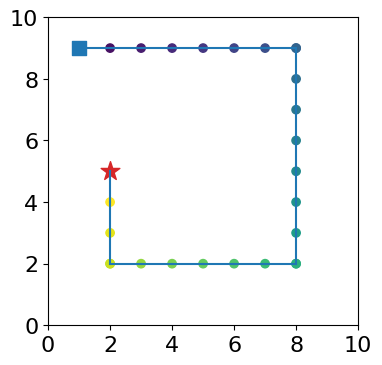

In [ ]:
obs_list = np.load('/home/jiashuncheng/code/Trasient/RL/train_dir/Watermaze2d_v8_myrnn_alpha_theta_region_1/20231030_205607_sf_obs_log.npy')
rew_list = np.load('/home/jiashuncheng/code/Trasient/RL/train_dir/Watermaze2d_v8_myrnn_alpha_theta_region_1/20231030_205607_sf_rew_log.npy')

print(np.where(rew_list == 1.))
plt.figure(figsize=(4,4))
a = 0
b = np.where(rew_list == 1.)[0][0]
for i in range(a+1,b):
    plt.plot([obs_list[i,0],obs_list[i+1,0]],[obs_list[i,1],obs_list[i+1,1]],c='C0')
c = np.linspace(0,1,b-a-1)
plt.scatter(x=obs_list[a+1:b,0], y=obs_list[a+1:b,1], c=c,cmap=plt.cm.get_cmap('viridis'))
loca = np.where(rew_list!=0.)
# print(obs_list[18,0])
plt.scatter(x=obs_list[loca[0][5],0], y=obs_list[loca[0][5],1], color='C3', marker='*', s=200)
plt.scatter(x=obs_list[a+1,0], y=obs_list[a+1,1], color='C0', marker='s', s=100)
plt.ylim([0,10])
plt.xlim([0,10])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('figure/trnn_1.svg')
plt.show()

plt.figure(figsize=(4,4))
a = np.where(rew_list == 1.)[0][0]+4
b = np.where(rew_list == 1.)[0][5]
for i in range(a+1,b):
    plt.plot([obs_list[i,0],obs_list[i+1,0]],[obs_list[i,1],obs_list[i+1,1]],c='C0')
c = np.linspace(0,1,b-a-1)
plt.scatter(x=obs_list[a+1:b,0], y=obs_list[a+1:b,1], c=c,cmap=plt.cm.get_cmap('viridis'))
loca = np.where(rew_list!=0.)
# print(obs_list[18,0])
plt.scatter(x=obs_list[loca[0][5],0], y=obs_list[loca[0][5],1], color='C3', marker='*', s=200)
plt.scatter(x=obs_list[a+1,0], y=obs_list[a+1,1], color='C0', marker='s', s=100)
plt.ylim([0,10])
plt.xlim([0,10])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('figure/trnn_2.svg')
plt.show()

plt.figure(figsize=(4,4))
a = np.where(rew_list == 1.)[0][5]+4
b = np.where(rew_list == 1.)[0][10]
for i in range(a+1,b):
    plt.plot([obs_list[i,0],obs_list[i+1,0]],[obs_list[i,1],obs_list[i+1,1]],c='C0')
c = np.linspace(0,1,b-a-1)
plt.scatter(x=obs_list[a+1:b,0], y=obs_list[a+1:b,1], c=c,cmap=plt.cm.get_cmap('viridis'))
loca = np.where(rew_list!=0.)
# print(obs_list[18,0])
plt.scatter(x=obs_list[loca[0][5],0], y=obs_list[loca[0][5],1], color='C3', marker='*', s=200)
plt.scatter(x=obs_list[a+1,0], y=obs_list[a+1,1], color='C0', marker='s', s=100)
plt.ylim([0,10])
plt.xlim([0,10])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('figure/trnn_3.svg')
plt.show()

#### RNN

(array([ 146,  147,  148,  149,  150,  281,  282,  283,  284,  285,  640,
        641,  642,  643,  644,  700,  701,  702,  703,  704,  914,  915,
        916,  917,  918,  971,  972,  973,  974,  975,  996,  997,  998,
        999, 1000, 1165, 1166, 1167, 1168, 1169]),)


/tmp/ipykernel_1939104/2703009461.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(x=obs_list[a+1:b,0], y=obs_list[a+1:b,1], c=c,cmap=plt.cm.get_cmap('viridis'))


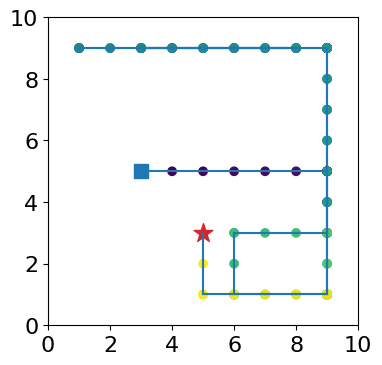

/tmp/ipykernel_1939104/2703009461.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(x=obs_list[a+1:b,0], y=obs_list[a+1:b,1], c=c,cmap=plt.cm.get_cmap('viridis'))


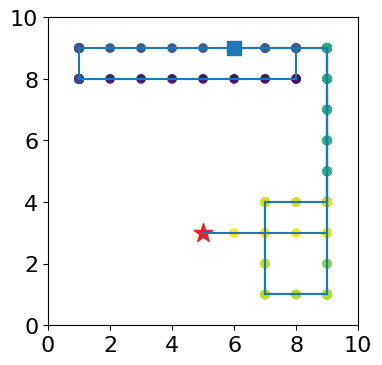

/tmp/ipykernel_1939104/2703009461.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(x=obs_list[a+1:b,0], y=obs_list[a+1:b,1], c=c,cmap=plt.cm.get_cmap('viridis'))


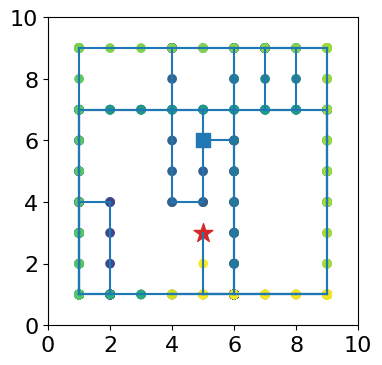

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
obs_list = np.load('/home/jiashuncheng/code/Trasient/RL/train_dir/Watermaze2d_v8_myrnn_1/20231030_211945_sf_obs_log.npy')
rew_list = np.load('/home/jiashuncheng/code/Trasient/RL/train_dir/Watermaze2d_v8_myrnn_1/20231030_211945_sf_rew_log.npy')

print(np.where(rew_list == 1.))
plt.figure(figsize=(4,4))
a = 0
b = np.where(rew_list == 1.)[0][0]
for i in range(a+1,b):
    plt.plot([obs_list[i,0],obs_list[i+1,0]],[obs_list[i,1],obs_list[i+1,1]],c='C0')
c = np.linspace(0,1,b-a-1)
plt.scatter(x=obs_list[a+1:b,0], y=obs_list[a+1:b,1], c=c,cmap=plt.cm.get_cmap('viridis'))
loca = np.where(rew_list!=0.)
# print(obs_list[18,0])
plt.scatter(x=obs_list[loca[0][5],0], y=obs_list[loca[0][5],1], color='C3', marker='*', s=200)
plt.scatter(x=obs_list[a+1,0], y=obs_list[a+1,1], color='C0', marker='s', s=100)
plt.ylim([0,10])
plt.xlim([0,10])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('figure/trnn_1.svg')
plt.show()

plt.figure(figsize=(4,4))
a = np.where(rew_list == 1.)[0][0]+4
b = np.where(rew_list == 1.)[0][5]
for i in range(a+1,b):
    plt.plot([obs_list[i,0],obs_list[i+1,0]],[obs_list[i,1],obs_list[i+1,1]],c='C0')
c = np.linspace(0,1,b-a-1)
plt.scatter(x=obs_list[a+1:b,0], y=obs_list[a+1:b,1], c=c,cmap=plt.cm.get_cmap('viridis'))
loca = np.where(rew_list!=0.)
# print(obs_list[18,0])
plt.scatter(x=obs_list[loca[0][5],0], y=obs_list[loca[0][5],1], color='C3', marker='*', s=200)
plt.scatter(x=obs_list[a+1,0], y=obs_list[a+1,1], color='C0', marker='s', s=100)
plt.ylim([0,10])
plt.xlim([0,10])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('figure/trnn_2.svg')
plt.show()

plt.figure(figsize=(4,4))
a = np.where(rew_list == 1.)[0][5]+4
b = np.where(rew_list == 1.)[0][10]
for i in range(a+1,b):
    plt.plot([obs_list[i,0],obs_list[i+1,0]],[obs_list[i,1],obs_list[i+1,1]],c='C0')
c = np.linspace(0,1,b-a-1)
plt.scatter(x=obs_list[a+1:b,0], y=obs_list[a+1:b,1], c=c,cmap=plt.cm.get_cmap('viridis'))
loca = np.where(rew_list!=0.)
# print(obs_list[18,0])
plt.scatter(x=obs_list[loca[0][5],0], y=obs_list[loca[0][5],1], color='C3', marker='*', s=200)
plt.scatter(x=obs_list[a+1,0], y=obs_list[a+1,1], color='C0', marker='s', s=100)
plt.ylim([0,10])
plt.xlim([0,10])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('figure/trnn_3.svg')
plt.show()

# Proportion

## Bar

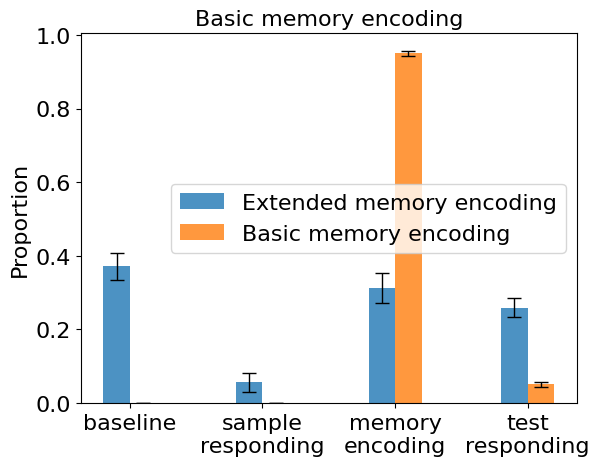

In [43]:
x = range(4)
error_params=dict(elinewidth=1,capsize=5)              

value1 = np.array([[0.3235294117647059,0.029411764705882353,0.38235294117647056,0.2647058823529412],
            [0.3111111111111111,0.13333333333333333,0.35555555555555557,0.2],
            [0.38636363636363635,0.045454545454545456,0.29545454545454547,0.2727272727272727],
            [0.48484848484848486,0.0,0.18181818181818182,0.3333333333333333],
            [0.35,0.075,0.35,0.225]])

value2 = np.array([[0.0,0.0,0.954954954954955,0.04504504504504504],
            [0.0,0.0,0.9596412556053812,0.04035874439461883],
            [0.0,0.0,0.958139534883721,0.04186046511627907],
            [0,0,0.9457013574660633,0.05429864253393665],
            [0,0,0.9288888888888889,0.07111111111111111]])

bar1 = plt.bar([i-0.1 for i in x],value1.mean(0),yerr=value1.std(0)/np.sqrt(3),error_kw=error_params,width = 0.2,
               alpha = 0.8,color = 'C0',label = 'Extended memory encoding')

bar2 = plt.bar([i+0.1 for i in x],value2.mean(0),yerr=value2.std(0)/np.sqrt(3),error_kw=error_params,width = 0.2,
               alpha = 0.8,color = 'C1',label = 'Basic memory encoding')

# plt.ylabel('Reward',fontsize=16)       #y轴的标签
# plt.xlabel('Number of distraction', fontsize=16)  
plt.yticks(fontsize=16)
plt.xticks([0, 1, 2, 3], ['baseline', 'sample\nresponding', 'memory\nencoding', 'test\nresponding'], fontsize=16)
plt.title("Basic memory encoding", fontsize=16)
plt.ylabel("Proportion", fontsize=16)
plt.legend(fontsize=16, loc='best')            #设置图例
plt.savefig('figure/fig3b1.svg')
plt.show()

## TI

(600, 90)
(1.263, 2.04415529415818, 0.511038823539545, 0.7189541732271513, 1.23, 0.2915025345567199, 0.03333333333333333)
8.3517885 0.0
(array([283, 284, 285, 286, 287, 288, 289, 290, 291, 292]),)
(array([513, 514, 515, 516]),)
(array([], dtype=int64),)


(600, 90)
(1.073, 1.9180133805795538, 0.47950334514488846, 0.5931892624923161, 1.073, 0.22927769362937578, 0.0)
8.969304 0.0
(array([348, 349, 350, 351, 352, 353, 354]),)
(array([471]),)
(array([], dtype=int64),)


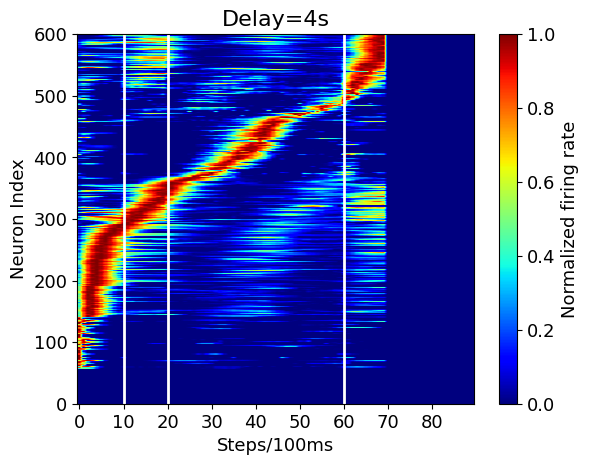

(600, 90)
(1.047, 1.66906072726119, 0.4172651818152975, 0.6298802813515068, 1.047, 0.18707947184642154, 0.0)
11.509054 0.0
(array([352, 353, 354, 355]),)
(array([481, 482]),)
(array([], dtype=int64),)


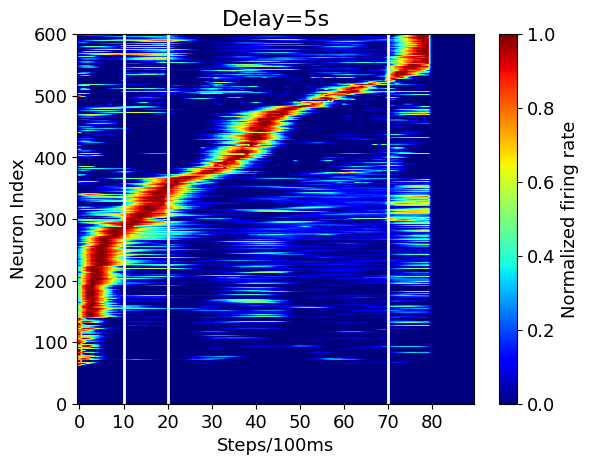

(600, 90)
(1.203, 1.8581283935841195, 0.4645320983960299, 0.7158539086580277, 1.18, 0.27583905709562484, 0.022222222222222223)
8.087517 0.0
(array([276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286]),)
(array([498, 499]),)
(array([532, 533, 534, 535]),)


[276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293
 294 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311
 312 313 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329
 330 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347
 348 349 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365
 366 367 368 369 370 371 372 373 374 375 376 377 378 379 380 381 382 383
 384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401
 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419
 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437
 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455
 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473
 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491
 492 493 494 495 496 497]
[498 499 500 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515
 516 517 518 519 520 521 

[290 287 289 593 286 291 288 283 292 285 284 293 294 295 298 583 559 297
 296 302 305 303 304 300 299 301 310 306 308 307 309 313 312 315 319 318
 317 314 323 325 322 324 327 321 597 326 329 330 335 337 336 334 333 340
 338 343 346 344 345 342 341 350 351 348 349 352 347 354 353 358 356 357
 355 360 362 367 361 368 366 369 359 373 377 374 378 379 372 371 370 375
 387 388 380 384 385 383 386 382 390 392 389 391 394 397 396 398 395 393
 400 399 403 402 404 401 407 405 414 409 411 412 410 408 406 413 416 418
 415 421 417 419 429 431 425 424 427 430 422 426 423 428 440 437 434 432
 439 438 442 436 433 435 441 447 445 443 444 446 448 458 449 453 451 456
 450 455 452 457 465 460 474 463 464 468 470 473 459 510 462 471 469 472
 461 466 467 487 478 482 477 488 491 475 479 490 486 481 489 483 485 484
 480 476 497 492 498 495 503 494 530 493 509 496 511 522 537 508 512 499
 547 504 506 507 541 515]
0-10: 0.0
10-20: 0.0
20-50: 0.954954954954955
50-60: 0.04504504504504504
[516 513 534 521 514 575 

In [44]:
from cProfile import label
from itertools import count
import numpy as np
from torch import arange
# from parameters import *
import pickle
import matplotlib.pyplot as plt
import copy

def normalization1(data):
#     data = data - np.mean(data, axis=1)[:,np.newaxis]
    print(data.max(), data.min())
    data = data - np.min(data)#, axis=1)[:,np.newaxis]
    data = data/(np.max(np.abs(data), axis=1)[:,np.newaxis]+0.00001)
    return data

def normalization2(data):
    data = data - np.mean(data, axis=1)[:,np.newaxis]
    data = data/(np.max(np.abs(data), axis=1)[:,np.newaxis]+0.00001)
    return data


def mean_var(A):
    mean = np.mean(A)
    var = np.var(A)
    std = np.std(A)
    return mean, var, std

def c_mass(data):
    interval = 5
    mass_max = 0
    mass_loc = 0
    for i in range(len(data)-interval):
        if np.sum(data[i:i+interval]) > mass_max:
            mass_max = np.sum(data[i:i+interval])
            mass_loc = i + interval/2
    return (mass_loc, mass_max)

def sorting_2(base):
    loc_all_0 = []
    for i in base[:, :]:
        loc, mass = c_mass(i)
        loc_all_0.append(loc) 
        # mass_all.append(mass)
    B = np.argsort(loc_all_0)  
    print(np.where(np.array(loc_all_0)[B]==20.5))
    print(np.where(np.array(loc_all_0)[B]==50.5))
    print(np.where(np.array(loc_all_0)[B]==80.5))

    return B, np.sort(loc_all_0)

from scipy.stats import entropy

def relu(inX):
    return np.maximum(0,inX)

def cal_TI(h, start=20, end=80):
    hidden_act = h
    hidden_act = hidden_act.T #600,90
    data = relu(normalization2(hidden_act).T) #90,600
    # data = relu(hidden_act.T[20:80,])
    ts = data.shape[0]  # number of time points
    entrpy_bins = end-start
    window_size = 1
    r_threshold = 0

    # selected_indx = np.nonzero(np.mean(data, axis=0) > r_threshold)[0]
    selected_indx = np.where(np.max(data, axis=0) > r_threshold)[0] # 大于平均发放率的神经元下标
    # selected_indx = np.array(selected_indx).squeeze()
    data = data[:, selected_indx]

    peak_times = np.argmax(data, axis=0) # 峰值时刻
    delay_peak_times = np.argmax(data[start:end,:], axis=0) #延迟时间 最大的发放率的下标
    index1 = np.where(data[start:end,:]>0.4) # 大于0.4的下标
    end_times = np.clip(delay_peak_times + window_size + 1, 0, ts)
    start_times = np.clip(delay_peak_times - window_size, 0, ts)
    # entrpy = entropy(np.histogram(delay_peak_times, entrpy_bins)[0]) 
    entrpy = entropy(np.histogram(delay_peak_times, entrpy_bins)[0]) # 延迟时间的能量
    entrpy_ori = entropy(np.histogram(delay_peak_times, entrpy_bins)[0], base=2)
    entrpy_max = entropy(np.ones(entrpy_bins)*data.shape[1]/entrpy_bins)
    # entrpy = entropy(np.histogram(peak_times, entrpy_bins)[0] + 0.1 * np.ones(entrpy_bins))
    r2b_ratio = np.zeros(len(selected_indx)) # 大于平均发放率的神经元比例
    trans_index = 0
    for nind in range(len(selected_indx)):
        # mask = np.zeros(ts)
        # mask[int(start_times[nind]):int(end_times[nind])] = 1
        data0 = data[start:end, nind]
        # ridge = np.mean(data0[int(start_times[nind]):int(end_times[nind])])
        ridge = np.sum(data0[start_times[nind]:end_times[nind]])
        # backgr = np.mean(np.ma.MaskedArray(data0, mask))
        backgr = np.sum(data0)
        # r2b_ratio[nind] = np.log(ridge) - np.log(backgr)
        if backgr == 0:
            r2b_ratio[nind] = 0
        else:
            r2b_ratio[nind] = ridge/backgr #* (end-start)/(end_times[nind]-start_times[nind]) # 窗口期间发放率
        trace_sum = ridge/(end_times[nind]-start_times[nind])
        trans_index += trace_sum

    trans_index /= len(selected_indx)
    entrpy = entrpy / entrpy_max
    r2b_ratio = np.nanmean(r2b_ratio)

    index1 = np.where(peak_times>=start)
    index2 = np.where(peak_times<end)
    index_delay = np.intersect1d(index1[0], index2[0]) # 延迟期间的下标
    trans_len = len(index_delay)/len(selected_indx)
    # transient_index = np.sum(data)/(60*500)
    SI_trial_vec = r2b_ratio + entrpy
    Total = SI_trial_vec + trans_len
    return round(Total, 3), entrpy_ori, entrpy, r2b_ratio, round(SI_trial_vec, 3), trans_index, trans_len

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/3_test.pkl'
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,0,:]
results[60:] = 0
hidden_act = results.T
print(hidden_act.shape)
data0 = hidden_act
print(cal_TI(data0,1,17))
TI = cal_TI(data0,1,17)[0]
newdata0 = data0.copy()
data0 = normalization1(data0)
B_mylstm, local_3 = sorting_2(data0)
data0 = data0[B_mylstm,:]
matrix1 = data0.copy()
num = len(data0)
B3 = B_mylstm
fig=plt.imshow(data0, aspect='auto',cmap='jet')
plt.vlines(x=10,ymin=0,ymax=600,linewidth=2,color='white')
plt.vlines(x=20,ymin=0,ymax=600,linewidth=2,color='white')
plt.vlines(x=50,ymin=0,ymax=600,linewidth=2,color='white')
plt.xlabel('Steps/100ms', fontsize=13)
plt.gca().invert_yaxis()
plt.ylabel('Neuron Index', fontsize=13)
# plt.title('Neural activity in trail TI={}'.format(TI))
font = {"size":13}
cb = plt.colorbar(fig)
cb.set_label('Normalized firing rate',fontdict=font)
cb.set_ticks([0,0.2,0.4,0.6,0.8,1])
cb.ax.tick_params(labelsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylim(0,600)
plt.savefig('figure/fig3a1.svg')
plt.show()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/4_test.pkl'
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,0,:]
results[70:] = 0
hidden_act = results.T
print(hidden_act.shape)
data0 = hidden_act
print(cal_TI(data0,1,17))
TI = cal_TI(data0,1,17)[0]
newdata0 = data0.copy()
data0 = normalization1(data0)
B_mylstm, local_4 = sorting_2(data0)
data0 = data0[B_mylstm,:]
matrix1 = data0.copy()
num = len(data0)
fig=plt.imshow(data0, aspect='auto',cmap='jet')
plt.vlines(x=10,ymin=0,ymax=600,linewidth=2,color='white')
plt.vlines(x=20,ymin=0,ymax=600,linewidth=2,color='white')
plt.vlines(x=60,ymin=0,ymax=600,linewidth=2,color='white')
plt.xlabel('Steps/100ms', fontsize=13)
plt.gca().invert_yaxis()
plt.ylabel('Neuron Index', fontsize=13)
# plt.title('Neural activity in trail TI={}'.format(TI))
font = {"size":13}
cb = plt.colorbar(fig)
cb.set_label('Normalized firing rate',fontdict=font)
cb.set_ticks([0,0.2,0.4,0.6,0.8,1])
cb.ax.tick_params(labelsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylim(0,600)
plt.title("Delay=4s",fontsize=16)
plt.savefig('figure/suppfig2a1.svg')
plt.show()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/5_test.pkl'
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,0,:]
results[80:] = 0
hidden_act = results.T
print(hidden_act.shape)
data0 = hidden_act
print(cal_TI(data0,1,17))
TI = cal_TI(data0,1,17)[0]
newdata0 = data0.copy()
data0 = normalization1(data0)
B_mylstm, local_5 = sorting_2(data0)
data0 = data0[B_mylstm,:]
matrix1 = data0.copy()
num = len(data0)
fig=plt.imshow(data0, aspect='auto',cmap='jet')
plt.vlines(x=10,ymin=0,ymax=600,linewidth=2,color='white')
plt.vlines(x=20,ymin=0,ymax=600,linewidth=2,color='white')
plt.vlines(x=70,ymin=0,ymax=600,linewidth=2,color='white')
plt.xlabel('Steps/100ms', fontsize=13)
plt.gca().invert_yaxis()
plt.ylabel('Neuron Index', fontsize=13)
# plt.title('Neural activity in trail TI={}'.format(TI))
font = {"size":13}
cb = plt.colorbar(fig)
cb.set_label('Normalized firing rate',fontdict=font)
cb.set_ticks([0,0.2,0.4,0.6,0.8,1])
cb.ax.tick_params(labelsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title("Delay=5s",fontsize=16)
plt.ylim(0,600)
plt.savefig('figure/suppfig2a2.svg')
plt.show()


netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/6_test.pkl'
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,0,:]
results[90:] = 0
hidden_act = results.T
print(hidden_act.shape)
data0 = hidden_act
print(cal_TI(data0,1,17))
TI = cal_TI(data0,1,17)[0]
newdata0 = data0.copy()
data0 = normalization1(data0)
B_mylstm, local_6 = sorting_2(data0)
data0 = data0[B_mylstm,:]
matrix1 = data0.copy()
num = len(data0)
B6 = B_mylstm
fig=plt.imshow(data0, aspect='auto',cmap='jet')
plt.vlines(x=10,ymin=0,ymax=600,linewidth=2,color='white')
plt.vlines(x=20,ymin=0,ymax=600,linewidth=2,color='white')
plt.vlines(x=80,ymin=0,ymax=600,linewidth=2,color='white')
plt.xlabel('Steps/100ms', fontsize=13)
plt.gca().invert_yaxis()
plt.ylabel('Neuron Index', fontsize=13)
# plt.title('Neural activity in trail TI={}'.format(TI))
font = {"size":13}
cb = plt.colorbar(fig)
cb.set_label('Normalized firing rate',fontdict=font)
cb.set_ticks([0,0.2,0.4,0.6,0.8,1])
cb.ax.tick_params(labelsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylim(0,600)
plt.savefig('figure/fig3a2.svg')
plt.show()

fig, ax = plt.subplots(1, 1)
x = np.ones((600,10))
# print(B3)
BB = []
for i in range(276,498):
#     print(np.where(B3 == B3[i]))
    BB.append(np.where(B6 == B6[i])[0])
print(np.array(BB).T[0])
x[np.array(BB).T[0]] = 0
BB = []
for i in range(498,532):
#     print(np.where(B3 == B3[i]))
    BB.append(np.where(B6 == B6[i])[0])
print(np.array(BB).T[0])
x[np.array(BB).T[0]] = 2
print(local_6[np.array(BB).T[0]])
plt.imshow(x,cmap='bwr')
ax.invert_yaxis()
plt.xticks()
plt.show()

fig, ax = plt.subplots(1, 1)
x = np.ones((600,10))
# print(B3)
BB = []
for i in range(276,498):
#     print(np.where(B3 == B3[i]))
    BB.append(np.where(B3 == B6[i])[0])
print(np.array(BB).T[0])
x[np.array(BB).T[0]] = 0

ii = 0
for i in range(len(local_3[np.array(BB).T[0]])):
    if local_3[np.array(BB).T[0]][i]>=0 and local_3[np.array(BB).T[0]][i]<10:
        ii+=1
print('0-10:', ii/len(local_3[np.array(BB).T[0]]))
ii = 0
for i in range(len(local_3[np.array(BB).T[0]])):
    if local_3[np.array(BB).T[0]][i]>=10 and local_3[np.array(BB).T[0]][i]<20:
        ii+=1
print('10-20:', ii/len(local_3[np.array(BB).T[0]]))
ii = 0
for i in range(len(local_3[np.array(BB).T[0]])):
    if local_3[np.array(BB).T[0]][i]>=20 and local_3[np.array(BB).T[0]][i]<50:
        ii+=1
print('20-50:', ii/len(local_3[np.array(BB).T[0]]))
ii = 0
for i in range(len(local_3[np.array(BB).T[0]])):
    if local_3[np.array(BB).T[0]][i]>=50 and local_3[np.array(BB).T[0]][i]<60:
        ii+=1
print('50-60:', ii/len(local_3[np.array(BB).T[0]]))

BB = []
for i in range(498,532):
#     print(np.where(B3 == B3[i]))
    BB.append(np.where(B3 == B6[i])[0])
print(np.array(BB).T[0])
x[np.array(BB).T[0]] = 2
ii = 0
for i in range(len(local_3[np.array(BB).T[0]])):
    if local_3[np.array(BB).T[0]][i]>=0 and local_3[np.array(BB).T[0]][i]<10:
        ii+=1
print('0-10:', ii/len(local_3[np.array(BB).T[0]]))
ii = 0
for i in range(len(local_3[np.array(BB).T[0]])):
    if local_3[np.array(BB).T[0]][i]>=10 and local_3[np.array(BB).T[0]][i]<20:
        ii+=1
print('10-20:', ii/len(local_3[np.array(BB).T[0]]))
ii = 0
for i in range(len(local_3[np.array(BB).T[0]])):
    if local_3[np.array(BB).T[0]][i]>=20 and local_3[np.array(BB).T[0]][i]<50:
        ii+=1
print('20-50:', ii/len(local_3[np.array(BB).T[0]]))
ii = 0
for i in range(len(local_3[np.array(BB).T[0]])):
    if local_3[np.array(BB).T[0]][i]>=50 and local_3[np.array(BB).T[0]][i]<60:
        ii+=1
print('50-60:', ii/len(local_3[np.array(BB).T[0]]))
plt.imshow(x,cmap='bwr')
ax.invert_yaxis()
plt.xticks()
plt.show()

## Number of neurons

(600, 90)
8.087517 0.0
(600, 90)
8.142199 0.0
(600, 90)
8.183928 0.0
(600, 90)
8.46487 0.0
(600, 90)
7.9445286 0.0
(600, 90)
8.076038 0.0
(600, 90)
8.827116 0.0
(600, 90)
7.7823153 0.0
(600, 90)
8.537146 0.0
(600, 90)
7.3367257 0.0


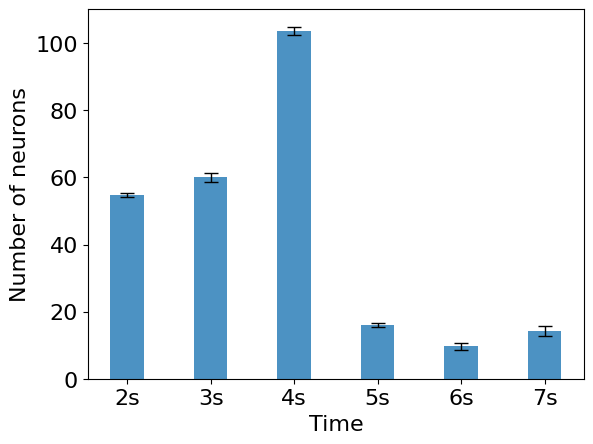

In [45]:
from cProfile import label
from itertools import count
import numpy as np
from torch import arange
# from parameters import *
import pickle
import matplotlib.pyplot as plt
import copy

def normalization1(data):
#     data = data - np.mean(data, axis=1)[:,np.newaxis]
    print(data.max(), data.min())
    data = data - np.min(data)#, axis=1)[:,np.newaxis]
    data = data/(np.max(np.abs(data), axis=1)[:,np.newaxis]+0.00001)
    return data

def normalization2(data):
    data = data - np.mean(data, axis=1)[:,np.newaxis]
    data = data/(np.max(np.abs(data), axis=1)[:,np.newaxis]+0.00001)
    return data


def mean_var(A):
    mean = np.mean(A)
    var = np.var(A)
    std = np.std(A)
    return mean, var, std

def c_mass(data):
    interval = 5
    mass_max = 0
    mass_loc = 0
    for i in range(len(data)-interval):
        if np.sum(data[i:i+interval]) > mass_max:
            mass_max = np.sum(data[i:i+interval])
            mass_loc = i + interval/2
    return (mass_loc, mass_max)

def sorting_3(base):
    loc_all_0 = []
    for i in base[:, :]:
        loc, mass = c_mass(i)
        loc_all_0.append(loc) 
        # mass_all.append(mass)
    B = np.argsort(loc_all_0)  
#     print(np.where(np.array(loc_all_0)[B]==20.5))
#     print(np.where(np.array(loc_all_0)[B]==50.5))
#     print(np.where(np.array(loc_all_0)[B]==80.5))
    global AA, KK
    for i in KK:
        AA.append(np.where(np.array(loc_all_0)[B]>=i)[0][0])
    return B, np.sort(loc_all_0)

from scipy.stats import entropy

def relu(inX):
    return np.maximum(0,inX)

def cal_TI(h, start=20, end=80):
    hidden_act = h
    hidden_act = hidden_act.T #600,90
    data = relu(normalization2(hidden_act).T) #90,600
    # data = relu(hidden_act.T[20:80,])
    ts = data.shape[0]  # number of time points
    entrpy_bins = end-start
    window_size = 1
    r_threshold = 0

    # selected_indx = np.nonzero(np.mean(data, axis=0) > r_threshold)[0]
    selected_indx = np.where(np.max(data, axis=0) > r_threshold)[0] # 大于平均发放率的神经元下标
    # selected_indx = np.array(selected_indx).squeeze()
    data = data[:, selected_indx]

    peak_times = np.argmax(data, axis=0) # 峰值时刻
    delay_peak_times = np.argmax(data[start:end,:], axis=0) #延迟时间 最大的发放率的下标
    index1 = np.where(data[start:end,:]>0.4) # 大于0.4的下标
    end_times = np.clip(delay_peak_times + window_size + 1, 0, ts)
    start_times = np.clip(delay_peak_times - window_size, 0, ts)
    # entrpy = entropy(np.histogram(delay_peak_times, entrpy_bins)[0]) 
    entrpy = entropy(np.histogram(delay_peak_times, entrpy_bins)[0]) # 延迟时间的能量
    entrpy_ori = entropy(np.histogram(delay_peak_times, entrpy_bins)[0], base=2)
    entrpy_max = entropy(np.ones(entrpy_bins)*data.shape[1]/entrpy_bins)
    # entrpy = entropy(np.histogram(peak_times, entrpy_bins)[0] + 0.1 * np.ones(entrpy_bins))
    r2b_ratio = np.zeros(len(selected_indx)) # 大于平均发放率的神经元比例
    trans_index = 0
    for nind in range(len(selected_indx)):
        # mask = np.zeros(ts)
        # mask[int(start_times[nind]):int(end_times[nind])] = 1
        data0 = data[start:end, nind]
        # ridge = np.mean(data0[int(start_times[nind]):int(end_times[nind])])
        ridge = np.sum(data0[start_times[nind]:end_times[nind]])
        # backgr = np.mean(np.ma.MaskedArray(data0, mask))
        backgr = np.sum(data0)
        # r2b_ratio[nind] = np.log(ridge) - np.log(backgr)
        if backgr == 0:
            r2b_ratio[nind] = 0
        else:
            r2b_ratio[nind] = ridge/backgr #* (end-start)/(end_times[nind]-start_times[nind]) # 窗口期间发放率
        trace_sum = ridge/(end_times[nind]-start_times[nind])
        trans_index += trace_sum

    trans_index /= len(selected_indx)
    entrpy = entrpy / entrpy_max
    r2b_ratio = np.nanmean(r2b_ratio)

    index1 = np.where(peak_times>=start)
    index2 = np.where(peak_times<end)
    index_delay = np.intersect1d(index1[0], index2[0]) # 延迟期间的下标
    trans_len = len(index_delay)/len(selected_indx)
    # transient_index = np.sum(data)/(60*500)
    SI_trial_vec = r2b_ratio + entrpy
    Total = SI_trial_vec + trans_len
    return round(Total, 3), entrpy_ori, entrpy, r2b_ratio, round(SI_trial_vec, 3), trans_index, trans_len

Value = np.zeros((10,6))
for cc in range(10):
    AA = []
    KK = [20.5,30.5,40.5,50.5,60.5,70.5,80.5]
    netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/6_test.pkl'
    results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,cc,:]
    results[90:] = 0
    hidden_act = results.T
    print(hidden_act.shape)
    data0 = hidden_act
    # print(cal_TI(data0,1,17))
    TI = cal_TI(data0,1,17)[0]
    newdata0 = data0.copy()
    data0 = normalization1(data0)
    B_mylstm, local_6 = sorting_3(data0)
    data0 = data0[B_mylstm,:]
    matrix1 = data0.copy()
    num = len(data0)
    B6 = B_mylstm

    # print(B3)
    value = []
    for s in range(6):
        BB = []
        for i in range(AA[s],AA[s+1]):
        #     print(np.where(B3 == B3[i]))
            BB.append(np.where(B6 == B6[i])[0])
        # print(np.array(BB).T[0],local_6,AA)
        ii = 0
        for i in range(len(local_6[np.array(BB).T[0]])):
            if local_6[np.array(BB).T[0]][i]>=KK[s] and local_6[np.array(BB).T[0]][i]<KK[s+1]:
                ii+=1
        value.append(ii)
    Value[cc] = value

error_params=dict(elinewidth=1,capsize=5)
plt.bar([i for i in range(len(value))],Value.mean(0),yerr=Value.std(0)/np.sqrt(Value.shape[0]),error_kw=error_params,width = 0.4, alpha = 0.8,color = 'C0')
# plt.ylabel('Reward',fontsize=16)       #y轴的标签
# plt.xlabel('Number of distraction', fontsize=16)  
plt.yticks(fontsize=16)
plt.xticks(range(len(value)), ['2s', '3s', '4s', '5s', '6s', '7s'], fontsize=16)
# plt.title("Extended memory encoding", fontsize=18)
plt.ylabel("Number of neurons",fontsize=16)
plt.xlabel("Time",fontsize=16)
# # plt.legend(fontsize=16)            #设置图例
plt.savefig('figure/suppfig2b.svg')
plt.show()

## Log likehood

In [46]:
# delay=6s
from matplotlib import ticker
from scipy.optimize import minimize
from scipy.optimize import fmin
import scipy.optimize as opt
from matplotlib.ticker import FuncFormatter

fig, ax = plt.subplots()
x = [0,20,40,60,80,100,120,140,160,180]
y = [0.0031,0.0031,0.0125,0.0219,0.0734,0.7781,0.8719,0.8891,0.8969,0.8953]
plt.plot(x, y, marker='o',linestyle=' ',label="Truthful data")
plt.ylim([0,1])

n = 64
I = np.array([0,20,40,60,80,100,120,140,160,180])
R = np.array([0.0031,0.0031,0.0125,0.0219,0.0734,0.7781,0.8719,0.8891,0.8969,0.8953]) * n
def fun(x):
    m=x[0]
    s=x[1]
    L=0
    for num in range(I.shape[0]):
        r=R[num]
        i=I[num]
        P_I = np.exp((i-m)/s)/(1+np.exp((i-m)/s))
        L+=r*np.log(P_I)+(n-r)*np.log(1-P_I)
    return -1 * L

def fun2(x):
    m=x[0]
    s=x[1]
    L=1
    for num in range(I.shape[0]):
        r=R[num]
        i=I[num]
        P_I = np.exp((i-m)/s)/(1+np.exp((i-m)/s))
        L=L*P_I
    return np.log(L)

def funI(I,m=1,s=1):
    P_I = np.exp((I-m)/s)/(1+np.exp((I-m)/s))
    return P_I

res = minimize(fun, np.array([180, 180]),method = 'Powell')
# res = opt.fmin(fun,np.array([1,1]))
print(res)
print("L:",fun2(res.x))
x = np.linspace(0,180,100)
y = funI(x,res.x[0],res.x[1])
plt.plot(x,y,linewidth=2,label='Fitted curve')
plt.xlim([0,183])
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x,_:'{:.0f}%'.format(x*100)))
plt.xticks([0,20,40,60,80,100,120,140,160,180],fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.xlabel('$\Delta \\theta$', fontsize=16)
plt.savefig('figure/suppfig1c.svg')
plt.show()

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 189.6597074480851
       x: [ 1.012e+02  1.841e+01]
     nit: 4
   direc: [[ 1.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00]]
    nfev: 95
L: -18.245378816613535


# $\Delta \theta$

In [47]:
from cProfile import label
from itertools import count
import numpy as np
from torch import arange
# from parameters import *
import pickle
import matplotlib.pyplot as plt
import copy

def normalization1(data):
#     data = data - np.mean(data, axis=1)[:,np.newaxis]
    print(data.max(), data.min())
    data = data - np.min(data)#, axis=1)[:,np.newaxis]
    data = data/(np.max(np.abs(data), axis=1)[:,np.newaxis]+0.00001)
    return data

def normalization2(data):
    data = data - np.mean(data, axis=1)[:,np.newaxis]
    data = data/(np.max(np.abs(data), axis=1)[:,np.newaxis]+0.00001)
    return data


def mean_var(A):
    mean = np.mean(A)
    var = np.var(A)
    std = np.std(A)
    return mean, var, std

def c_mass(data):
    interval = 5
    mass_max = 0
    mass_loc = 0
    for i in range(len(data)-interval):
        if np.sum(data[i:i+interval]) > mass_max:
            mass_max = np.sum(data[i:i+interval])
            mass_loc = i + interval/2
    return (mass_loc, mass_max)

def sorting_4(base):
    loc_all_0 = []
    for i in base[:, :]:
        loc, mass = c_mass(i)
        loc_all_0.append(loc) 
        # mass_all.append(mass)
    B = np.argsort(loc_all_0)  
#     print(np.where(np.array(loc_all_0)[B]==20.5))
#     print(np.where(np.array(loc_all_0)[B]==50.5))
#     print(np.where(np.array(loc_all_0)[B]==80.5))
    global A1,B1,C1
    A1 = np.where(np.array(loc_all_0)[B]>=10.5)
    B1 = np.where(np.array(loc_all_0)[B]>=20.5)
    C1 = np.where(np.array(loc_all_0)[B]>=80.5)
    return B, np.sort(loc_all_0)

from scipy.stats import entropy

def relu(inX):
    return np.maximum(0,inX)

def cal_TI(h, start=20, end=80):
    hidden_act = h
    hidden_act = hidden_act.T #600,90
    data = relu(normalization2(hidden_act).T) #90,600
    # data = relu(hidden_act.T[20:80,])
    ts = data.shape[0]  # number of time points
    entrpy_bins = end-start
    window_size = 1
    r_threshold = 0

    # selected_indx = np.nonzero(np.mean(data, axis=0) > r_threshold)[0]
    selected_indx = np.where(np.max(data, axis=0) > r_threshold)[0] # 大于平均发放率的神经元下标
    # selected_indx = np.array(selected_indx).squeeze()
    data = data[:, selected_indx]

    peak_times = np.argmax(data, axis=0) # 峰值时刻
    delay_peak_times = np.argmax(data[start:end,:], axis=0) #延迟时间 最大的发放率的下标
    index1 = np.where(data[start:end,:]>0.4) # 大于0.4的下标
    end_times = np.clip(delay_peak_times + window_size + 1, 0, ts)
    start_times = np.clip(delay_peak_times - window_size, 0, ts)
    # entrpy = entropy(np.histogram(delay_peak_times, entrpy_bins)[0]) 
    entrpy = entropy(np.histogram(delay_peak_times, entrpy_bins)[0]) # 延迟时间的能量
    entrpy_ori = entropy(np.histogram(delay_peak_times, entrpy_bins)[0], base=2)
    entrpy_max = entropy(np.ones(entrpy_bins)*data.shape[1]/entrpy_bins)
    # entrpy = entropy(np.histogram(peak_times, entrpy_bins)[0] + 0.1 * np.ones(entrpy_bins))
    r2b_ratio = np.zeros(len(selected_indx)) # 大于平均发放率的神经元比例
    trans_index = 0
    for nind in range(len(selected_indx)):
        # mask = np.zeros(ts)
        # mask[int(start_times[nind]):int(end_times[nind])] = 1
        data0 = data[start:end, nind]
        # ridge = np.mean(data0[int(start_times[nind]):int(end_times[nind])])
        ridge = np.sum(data0[start_times[nind]:end_times[nind]])
        # backgr = np.mean(np.ma.MaskedArray(data0, mask))
        backgr = np.sum(data0)
        # r2b_ratio[nind] = np.log(ridge) - np.log(backgr)
        if backgr == 0:
            r2b_ratio[nind] = 0
        else:
            r2b_ratio[nind] = ridge/backgr #* (end-start)/(end_times[nind]-start_times[nind]) # 窗口期间发放率
        trace_sum = ridge/(end_times[nind]-start_times[nind])
        trans_index += trace_sum

    trans_index /= len(selected_indx)
    entrpy = entrpy / entrpy_max
    r2b_ratio = np.nanmean(r2b_ratio)

    index1 = np.where(peak_times>=start)
    index2 = np.where(peak_times<end)
    index_delay = np.intersect1d(index1[0], index2[0]) # 延迟期间的下标
    trans_len = len(index_delay)/len(selected_indx)
    # transient_index = np.sum(data)/(60*500)
    SI_trial_vec = r2b_ratio + entrpy
    Total = SI_trial_vec + trans_len
    return round(Total, 3), entrpy_ori, entrpy, r2b_ratio, round(SI_trial_vec, 3), trans_index, trans_len

A1,B1,C1=0,0,0
netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/6_test_5.pkl'
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,0,:]
results[90:] = 0
hidden_act = results.T
print(hidden_act.shape)
data0 = hidden_act
# print(cal_TI(data0,1,17))
TI = cal_TI(data0,1,17)[0]
newdata0 = data0.copy()
data0 = normalization1(data0)
B_mylstm, local_3 = sorting_4(data0)
data0 = data0[B_mylstm,:]
matrix1 = data0.copy()
num = len(data0)
B3 = B_mylstm
# fig=plt.imshow(data0, aspect='auto',cmap='jet')
# plt.xlabel('Steps')
# plt.gca().invert_yaxis()
# plt.ylabel('Sorting neuron_index')
# plt.title('Neural activity in trail TI={}'.format(TI))
# plt.colorbar(fig, label="Normalized firing rate")
# plt.show()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/6_test_6.pkl'
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,0,:]
results[90:] = 0
hidden_act = results.T
print(hidden_act.shape)
data0 = hidden_act
# print(cal_TI(data0,1,17))
TI = cal_TI(data0,1,17)[0]
newdata0 = data0.copy()
data0 = normalization1(data0)
B_mylstm, local_6 = sorting_4(data0)
data0 = data0[B_mylstm,:]
matrix1 = data0.copy()
num = len(data0)
B6 = B_mylstm

a = A1[0][0]
b = B1[0][0]
c = C1[0][0]

# print(B3)
y = []
BB = []
for i in range(0,a):
#     print(np.where(B3 == B3[i]))
    BB.append(np.where(B3 == B6[i])[0])
ii = 0
for i in range(len(local_3[np.array(BB).T[0]])):
    if local_3[np.array(BB).T[0]][i]>=0 and local_3[np.array(BB).T[0]][i]<10:
        ii+=1
print('0-10:', ii/len(local_3[np.array(BB).T[0]]))
y.append(ii/len(local_3[np.array(BB).T[0]]))

BB = []
for i in range(a,b):
#     print(np.where(B3 == B3[i]))
    BB.append(np.where(B3 == B6[i])[0])
ii = 0
for i in range(len(local_3[np.array(BB).T[0]])):
    if local_3[np.array(BB).T[0]][i]>=10 and local_3[np.array(BB).T[0]][i]<20:
        ii+=1
print('10-20:', ii/len(local_3[np.array(BB).T[0]]))
y.append(ii/len(local_3[np.array(BB).T[0]]))

BB = []
for i in range(b,c):
#     print(np.where(B3 == B3[i]))
    BB.append(np.where(B3 == B6[i])[0])
ii = 0
for i in range(len(local_3[np.array(BB).T[0]])):
    if local_3[np.array(BB).T[0]][i]>=20 and local_3[np.array(BB).T[0]][i]<80:
        ii+=1
print('20-80:', ii/len(local_3[np.array(BB).T[0]]))
y.append(ii/len(local_3[np.array(BB).T[0]]))

BB = []
for i in range(c,600):
#     print(np.where(B3 == B3[i]))
    BB.append(np.where(B3 == B6[i])[0])
ii = 0
for i in range(len(local_3[np.array(BB).T[0]])):
    if local_3[np.array(BB).T[0]][i]>=80 and local_3[np.array(BB).T[0]][i]<90:
        ii+=1
print('80-90:', ii/len(local_3[np.array(BB).T[0]]))
y.append(ii/len(local_3[np.array(BB).T[0]]))

print(np.array(y).mean())

(600, 90)
9.10002 0.0
(600, 90)
9.10002 0.0
0-10: 1.0
10-20: 1.0
20-80: 1.0
80-90: 1.0
1.0


[-0.05291159  1.00327846]


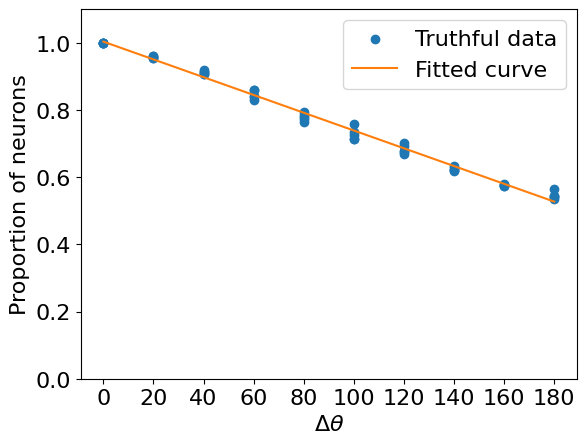

In [48]:
from scipy.interpolate import interp1d
x = np.zeros((5,10))
x[0] = [1,0.9567014809902741,0.9115290557127598,0.86055185721454,0.7944066191493055,0.758421738230997,0.7015847131009413,0.6326578392070389,0.5796418970814132,0.5412123580319937]
x[1] = [1,0.9552844274423852,0.9139233573195837,0.838351732125317,0.7796556876565366,0.7249275573823767,0.6750061807806372,0.620439835845069,0.5727023609120999,0.5437448367855817]
x[2] = [1,0.9531195411468578,0.9056739228381151,0.84100797731677,0.7723083464154893,0.7134761700460519,0.6762771791954671,0.6261077194948061,0.5776154731395232,0.5646477973469801]
x[3] = [1,0.9611510315640981,0.9068729052354028,0.8302695842169527,0.7654241458418916,0.7147341827586491,0.6702972889209102,0.6205979881678837,0.5777759482484215,0.5449149737216005]
x[4] = [1,0.9595888181774552,0.9175766247651381,0.8595490449219835,0.7849876047274703,0.735356847359337,0.6923164219069085,0.6186476676229559,0.5738645559909288,0.5339121566004718]


cubic_interploation_model=interp1d(np.arange(10),x.mean(0),kind="cubic")
xs=np.linspace(0,9,500)
ys=cubic_interploation_model(xs)

poly = np.polyfit(np.arange(10),x.mean(0),deg=1)
print(poly)
y_value = np.polyval(poly,np.arange(10))

plt.scatter(np.arange(10), x[0], color='C0')
plt.scatter(np.arange(10), x[1],color='C0')
plt.scatter(np.arange(10), x[2],color='C0')
plt.scatter(np.arange(10), x[3],color='C0')
plt.scatter(np.arange(10), x[4],color='C0',label="Truthful data")
# plt.plot(xs,ys,color='C1')
plt.plot(np.arange(10),y_value,color='C1',label='Fitted curve')
plt.xticks(np.arange(10),[0,20,40,60,80,100,120,140,160,180],fontsize=16)
plt.yticks(fontsize=16)
plt.ylim([0,1.1])
plt.legend(fontsize=16)
plt.xlabel('$\Delta \\theta$',fontsize=16)
plt.ylabel('Proportion of neurons',fontsize=16)
plt.savefig('figure/suppfig2c.svg')
plt.show()

# Acc

In [49]:
def acc(netdir):
    results = pickle.load(open(netdir, 'rb'))
    accuracy = np.array(results['accuracy']).max()
    print(accuracy)
netdir = "/home/jiashuncheng/code/Trasient/ODPA/savedir/6new_delay3s.pkl.pkl"
acc1 = acc(netdir)
netdir = "/home/jiashuncheng/code/Trasient/ODPA/savedir/6new_delay3s.pkl.pkl"
acc2 = acc(netdir)
netdir = "/home/jiashuncheng/code/Trasient/ODPA/savedir/6new_delay3s.pkl.pkl"
acc3 = acc(netdir)

acc1 = 0.9859
acc2 = 0.9828
acc3 = 0.9953
ACC = np.array([acc1,acc2,acc3]).mean()
STD = np.array([acc1,acc2,acc3]).std()
print(ACC, STD)

1.0
1.0
1.0
0.988 0.0053147593234940055


# Hidden weight

## Weight

(600, 90)
(1.294, 2.22957427937079, 0.5573935698426975, 0.6865937113761902, 1.244, 0.16564942639735009, 0.05)
7.1989126 0.0
比例: 0.8807972222222222


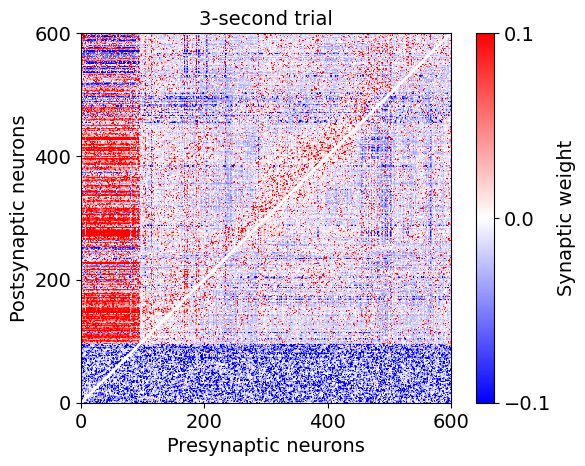

(600, 90)
(1.363, 2.456477416716515, 0.6141193541791288, 0.7155238717794419, 1.33, 0.13964374075402267, 0.03333333333333333)
8.235213 0.0
比例: 0.8807972222222222


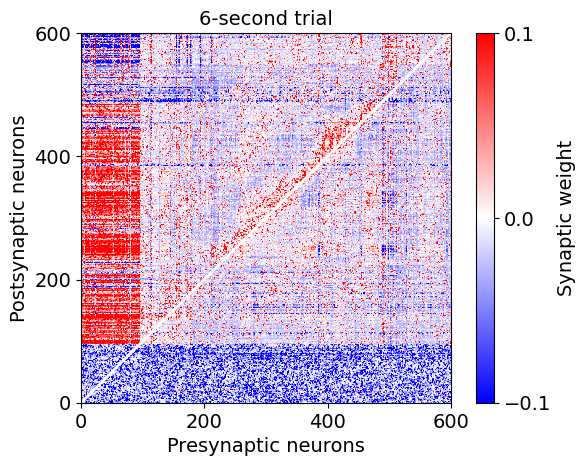

In [50]:
from cProfile import label
from itertools import count
import numpy as np
from torch import arange
# from parameters import *
import pickle
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

def normalization1(data):
#     data = data - np.mean(data, axis=1)[:,np.newaxis]
    print(data.max(), data.min())
    data = data - np.min(data)#, axis=1)[:,np.newaxis]
    data = data/(np.max(np.abs(data), axis=1)[:,np.newaxis]+0.00001)
    return data

def normalization2(data):
    data = data - np.mean(data, axis=1)[:,np.newaxis]
    data = data/(np.max(np.abs(data), axis=1)[:,np.newaxis]+0.00001)
    return data


def mean_var(A):
    mean = np.mean(A)
    var = np.var(A)
    std = np.std(A)
    return mean, var, std

def c_mass(data):
    interval = 5
    mass_max = 0
    mass_loc = 0
    for i in range(len(data)-interval):
        if np.sum(data[i:i+interval]) > mass_max:
            mass_max = np.sum(data[i:i+interval])
            mass_loc = i + interval/2
    return (mass_loc, mass_max)

def sorting_2(base):
    loc_all_0 = []
    for i in base[:, :]:
        loc, mass = c_mass(i)
        loc_all_0.append(loc) 
        # mass_all.append(mass)
    B = np.argsort(loc_all_0)  

    return B, np.sort(loc_all_0)

from scipy.stats import entropy

def relu(inX):
    return np.maximum(0,inX)

def cal_TI(h, start=20, end=80):
    hidden_act = h
    hidden_act = hidden_act.T #600,90
    data = relu(normalization2(hidden_act).T) #90,600
    # data = relu(hidden_act.T[20:80,])
    ts = data.shape[0]  # number of time points
    entrpy_bins = end-start
    window_size = 1
    r_threshold = 0

    # selected_indx = np.nonzero(np.mean(data, axis=0) > r_threshold)[0]
    selected_indx = np.where(np.max(data, axis=0) > r_threshold)[0] # 大于平均发放率的神经元下标
    # selected_indx = np.array(selected_indx).squeeze()
    data = data[:, selected_indx]

    peak_times = np.argmax(data, axis=0) # 峰值时刻
    delay_peak_times = np.argmax(data[start:end,:], axis=0) #延迟时间 最大的发放率的下标
    index1 = np.where(data[start:end,:]>0.4) # 大于0.4的下标
    end_times = np.clip(delay_peak_times + window_size + 1, 0, ts)
    start_times = np.clip(delay_peak_times - window_size, 0, ts)
    # entrpy = entropy(np.histogram(delay_peak_times, entrpy_bins)[0]) 
    entrpy = entropy(np.histogram(delay_peak_times, entrpy_bins)[0]) # 延迟时间的能量
    entrpy_ori = entropy(np.histogram(delay_peak_times, entrpy_bins)[0], base=2)
    entrpy_max = entropy(np.ones(entrpy_bins)*data.shape[1]/entrpy_bins)
    # entrpy = entropy(np.histogram(peak_times, entrpy_bins)[0] + 0.1 * np.ones(entrpy_bins))
    r2b_ratio = np.zeros(len(selected_indx)) # 大于平均发放率的神经元比例
    trans_index = 0
    for nind in range(len(selected_indx)):
        # mask = np.zeros(ts)
        # mask[int(start_times[nind]):int(end_times[nind])] = 1
        data0 = data[start:end, nind]
        # ridge = np.mean(data0[int(start_times[nind]):int(end_times[nind])])
        ridge = np.sum(data0[start_times[nind]:end_times[nind]])
        # backgr = np.mean(np.ma.MaskedArray(data0, mask))
        backgr = np.sum(data0)
        # r2b_ratio[nind] = np.log(ridge) - np.log(backgr)
        if backgr == 0:
            r2b_ratio[nind] = 0
        else:
            r2b_ratio[nind] = ridge/backgr #* (end-start)/(end_times[nind]-start_times[nind]) # 窗口期间发放率
        trace_sum = ridge/(end_times[nind]-start_times[nind])
        trans_index += trace_sum

    trans_index /= len(selected_indx)
    entrpy = entrpy / entrpy_max
    r2b_ratio = np.nanmean(r2b_ratio)

    index1 = np.where(peak_times>=start)
    index2 = np.where(peak_times<end)
    index_delay = np.intersect1d(index1[0], index2[0]) # 延迟期间的下标
    trans_len = len(index_delay)/len(selected_indx)
    # transient_index = np.sum(data)/(60*500)
    SI_trial_vec = r2b_ratio + entrpy
    Total = SI_trial_vec + trans_len
    return round(Total, 3), entrpy_ori, entrpy, r2b_ratio, round(SI_trial_vec, 3), trans_index, trans_len

with open('/home/jiashuncheng/code/Trasient/ODPA/savedir/w_1output.pkl', 'rb') as handle:
    w_out = pickle.load(handle).detach().cpu().numpy()
with open('/home/jiashuncheng/code/Trasient/ODPA/savedir/b_1output.pkl', 'rb') as handle:
    b_out = pickle.load(handle).detach().cpu().numpy()
with open('/home/jiashuncheng/code/Trasient/ODPA/savedir/w_2rnn.pkl', 'rb') as handle:
    w_hidden = pickle.load(handle).detach().cpu().numpy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/3_1test_7.pkl'
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,0,:]
results[60:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
hidden_act = results.T
print(hidden_act.shape)
data0 = hidden_act
print(cal_TI(data0,1,17))
TI = cal_TI(data0,1,17)[0]
newdata0 = data0.copy()
data0 = normalization1(data0)
B_mylstm, local_3 = sorting_2(data0)
data0 = data0[B_mylstm,:]
matrix1 = data0.copy()
num = len(data0)

new_matrix = w_hidden[B_mylstm, :]
new_matrix = new_matrix[:, B_mylstm]
# print(new_matrix[100:200, 500:600])
aaa = np.zeros_like(new_matrix)
aaa[np.logical_and(new_matrix<=0.1, new_matrix>=-0.1)] = 1
print("比例:",sum(sum(aaa))/aaa.shape[0]/aaa.shape[1])
plt.imshow(new_matrix.T,vmin=-0.1,vmax=0.1,cmap='bwr')
cb = plt.colorbar()
cb.set_ticks([-0.1,0,0.1])
cb.set_label('Synaptic weight', font={'size':14})
cb.ax.tick_params(labelsize=14)
plt.plot([0,600],[0,600],color='white',linewidth=2)
plt.yticks([0,200,400,600],fontsize=14)
plt.xticks([0,200,400,600],fontsize=14)
plt.ylabel('Postsynaptic neurons', fontsize=14)
plt.xlabel('Presynaptic neurons',fontsize=14)
plt.gca().invert_yaxis()
plt.title('3-second trial', fontsize=14)
plt.ylim([0,600])
plt.xlim([0,600])
plt.savefig('figure/fige1.svg')
plt.show()
matrix_3 = new_matrix.T

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/6_1test_7.pkl'
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,0,:]
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
hidden_act = results.T
print(hidden_act.shape)
data0 = hidden_act
print(cal_TI(data0,1,17))
TI = cal_TI(data0,1,17)[0]
newdata0 = data0.copy()
data0 = normalization1(data0)
B_mylstm, local_3 = sorting_2(data0)
data0 = data0[B_mylstm,:]
matrix1 = data0.copy()
num = len(data0)

new_matrix = w_hidden[B_mylstm, :]
new_matrix = new_matrix[:, B_mylstm]
# print(new_matrix)
aaa = np.zeros_like(new_matrix)
aaa[np.logical_and(new_matrix<=0.1, new_matrix>=-0.1)] = 1
print("比例:",sum(sum(aaa))/aaa.shape[0]/aaa.shape[1])
plt.imshow(new_matrix.T,vmin=-0.1,vmax=0.1,cmap='bwr')
cb = plt.colorbar()
cb.set_ticks([-0.1,0,0.1])
cb.ax.tick_params(labelsize=14)
cb.set_label('Synaptic weight', font={'size':14})
plt.plot([0,600],[0,600],color='white',linewidth=2)
plt.yticks([0,200,400,600],fontsize=14)
plt.xticks([0,200,400,600],fontsize=14)
plt.ylabel('Postsynaptic neurons', fontsize=14)
plt.xlabel('Presynaptic neurons',fontsize=14)
plt.gca().invert_yaxis()
plt.title('6-second trial', fontsize=14)
plt.ylim([0,600])
plt.xlim([0,600])
plt.savefig('figure/fige2.svg')
plt.show()
matrix_6 = new_matrix.T

## $i-j$

(1000, 500)


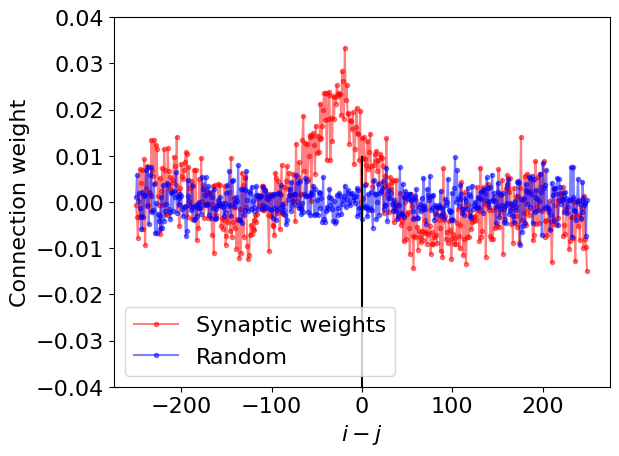

In [51]:
x = np.zeros((500,500))
y = np.zeros((250,500))
y[:,:] = np.nan
matrix_3_1 = matrix_3[100:,100:]
matrix_3_new = np.vstack((y,matrix_3_1))
matrix_3_new = np.vstack((matrix_3_new,y))
print(matrix_3_new.shape)
for i in range(0,500):
    for j in range(-250,250,1):
        x[i][j+250] = matrix_3_new[j+i+250][i]
plt.plot(np.arange(-250,250,1),np.nanmean(x, axis=0)[::-1], color='r', alpha=0.5, marker='.', label='Synaptic weights')

x = np.zeros((500,500))
y = np.zeros((250,500))
y[:,:] = np.nan
matrix_3_1 = 0.2*np.random.rand(500,500) - 0.1
matrix_3_new = np.vstack((y,matrix_3_1))
matrix_3_new = np.vstack((matrix_3_new,y))
for i in range(0,500):
    for j in range(-250,250,1):
        x[i][j+250] = matrix_3_new[j+i+250][i]
plt.plot(np.arange(-250,250,1),np.nanmean(x, axis=0)[::-1],color='b', alpha=0.5, marker='.', label='Random')
plt.vlines(x=0,ymin=-0.04,ymax=0.01, color='k')
plt.ylim([-0.04,0.04])
plt.ylabel('Connection weight',fontsize=16)
plt.xlabel('$i-j$',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.savefig('figure/suppfig2e.svg')
plt.show()

# $\Delta$ hidden_act

4.0 -4.0


  0%|          | 0/4 [00:00<?, ?it/s]

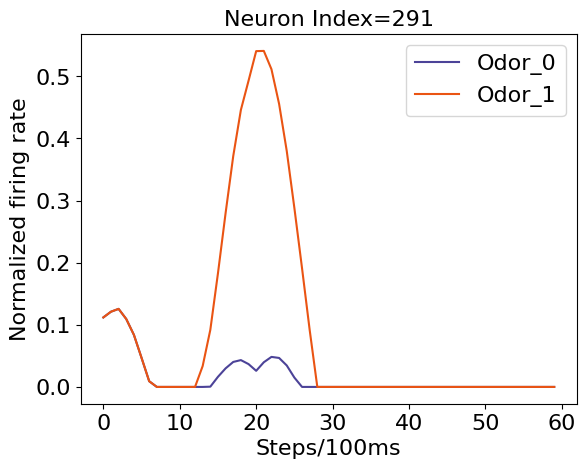

 25%|██▌       | 1/4 [00:00<00:01,  1.89it/s]

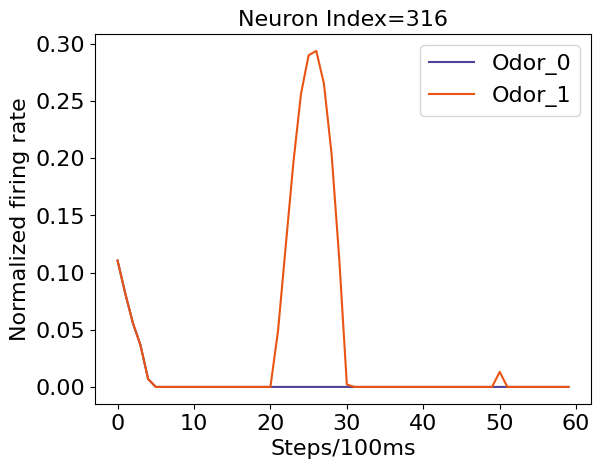

 50%|█████     | 2/4 [00:01<00:01,  1.84it/s]

 75%|███████▌  | 3/4 [00:01<00:00,  1.81it/s]

100%|██████████| 4/4 [00:02<00:00,  1.82it/s]


In [52]:
from cProfile import label
from itertools import count
import numpy as np
from torch import arange
# from parameters import *
import pickle
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

def normalization1(data):
#     data = data - np.mean(data, axis=1)[:,np.newaxis]
    print(data.max(), data.min())
    data = data - np.min(data)#, axis=1)[:,np.newaxis]
    data = data/(np.max(np.abs(data), axis=1)[:,np.newaxis]+0.00001)
    return data

def normalization2(data):
    data = data - np.mean(data, axis=1)[:,np.newaxis]
    data = data/(np.max(np.abs(data), axis=1)[:,np.newaxis]+0.00001)
    return data


def mean_var(A):
    mean = np.mean(A)
    var = np.var(A)
    std = np.std(A)
    return mean, var, std

from scipy.stats import entropy

def relu(inX):
    return np.maximum(0,inX)

def cal_TI(h, start=20, end=80):
    hidden_act = h
    hidden_act = hidden_act.T #600,90
    assert hidden_act.shape[0] == 600
    data = relu(normalization2(hidden_act).T) #90,600
    # data = relu(hidden_act.T[20:80,])
    ts = data.shape[0]  # number of time points
    entrpy_bins = end-start
    window_size = 1
    r_threshold = 0

    # selected_indx = np.nonzero(np.mean(data, axis=0) > r_threshold)[0]
    selected_indx = np.where(np.max(data, axis=0) > r_threshold)[0] # 大于平均发放率的神经元下标
    # selected_indx = np.array(selected_indx).squeeze()
    data = data[:, selected_indx]

    peak_times = np.argmax(data, axis=0) # 峰值时刻
    delay_peak_times = np.argmax(data[start:end,:], axis=0) #延迟时间 最大的发放率的下标
    index1 = np.where(data[start:end,:]>0.4) # 大于0.4的下标
    end_times = np.clip(delay_peak_times + window_size + 1, 0, ts)
    start_times = np.clip(delay_peak_times - window_size, 0, ts)
    # entrpy = entropy(np.histogram(delay_peak_times, entrpy_bins)[0]) 
    entrpy = entropy(np.histogram(delay_peak_times, entrpy_bins)[0]) # 延迟时间的能量
    entrpy_ori = entropy(np.histogram(delay_peak_times, entrpy_bins)[0], base=2)
    entrpy_max = entropy(np.ones(entrpy_bins)*data.shape[1]/entrpy_bins)
    # entrpy = entropy(np.histogram(peak_times, entrpy_bins)[0] + 0.1 * np.ones(entrpy_bins))
    r2b_ratio = np.zeros(len(selected_indx)) # 大于平均发放率的神经元比例
    trans_index = 0
    for nind in range(len(selected_indx)):
        # mask = np.zeros(ts)
        # mask[int(start_times[nind]):int(end_times[nind])] = 1
        data0 = data[start:end, nind]
        # ridge = np.mean(data0[int(start_times[nind]):int(end_times[nind])])
        ridge = np.sum(data0[start_times[nind]:end_times[nind]])
        # backgr = np.mean(np.ma.MaskedArray(data0, mask))
        backgr = np.sum(data0)
        # r2b_ratio[nind] = np.log(ridge) - np.log(backgr)
        if backgr == 0:
            r2b_ratio[nind] = 0
        else:
            r2b_ratio[nind] = ridge/backgr #* (end-start)/(end_times[nind]-start_times[nind]) # 窗口期间发放率
        trace_sum = ridge/(end_times[nind]-start_times[nind])
        trans_index += trace_sum

    trans_index /= len(selected_indx)
    entrpy = entrpy / entrpy_max
    r2b_ratio = np.nanmean(r2b_ratio)

    index1 = np.where(peak_times>=start)
    index2 = np.where(peak_times<end)
    index_delay = np.intersect1d(index1[0], index2[0]) # 延迟期间的下标
    trans_len = len(index_delay)/len(selected_indx)
    # transient_index = np.sum(data)/(60*500)
    SI_trial_vec = r2b_ratio + entrpy
    Total = SI_trial_vec + trans_len
    return round(Total, 3), entrpy_ori, entrpy, r2b_ratio, round(SI_trial_vec, 3), trans_index, trans_len

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/max3000_3s_odor1.pkl'
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,0,:]
hidden_act1 = results.T

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/max3000_3s_odor2.pkl'
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,0,:]
hidden_act2 = results.T

delta_hidden = hidden_act1 - hidden_act2

def c_mass_1(data):
    interval = 5
    mass_max = 0
    mass_loc = 0
    for i in range(len(data)-interval):
        if np.sum(abs(data[i:i+interval])) > mass_max:
            mass_max = np.sum(abs(data[i:i+interval]))
            mass_loc = i + interval/2
    return (mass_loc, mass_max)

def sorting_1(base):
    loc_all_0 = []
    for i in base[:, :]:
        loc, mass = c_mass_1(i)
        loc_all_0.append(loc) 
        # mass_all.append(mass)
    B = np.argsort(loc_all_0)  

    return B, np.sort(loc_all_0)

data0 = delta_hidden
B_mylstm, local_3 = sorting_1(data0)
data0 = data0[B_mylstm,:]
data0[np.where(data0>=0)] = 4 * data0[np.where(data0>=0)]/data0[np.where(data0>=0)].max()
data0[np.where(data0<0)] = -4 * data0[np.where(data0<0)]/data0[np.where(data0<0)].min()
print(data0.max(), data0.min())
fig=plt.imshow(data0, aspect='auto',cmap='bwr')
plt.xlabel('Steps/100ms',fontsize=16)
plt.gca().invert_yaxis()
plt.ylabel('Neuron Index',fontsize=16)
plt.title('Neural activity in trail (abs)',fontsize=16)
cb=plt.colorbar(fig)
cb.set_label("Normalized firing rate", fontdict={'size':16})
cb.ax.tick_params(labelsize=16)
plt.savefig('figure/suppfig1b.svg')
plt.show()

# from tqdm import tqdm
# for i in tqdm(range(600)):
#     fig, ax = plt.subplots()
#     plt.plot(hidden_act1[B_mylstm,:][i], color='#4c4398', label='Odor_0')
#     plt.plot(hidden_act2[B_mylstm,:][i], color='#ea5413', label='Odor_1')
#     plt.title('index={}'.format(i))
#     plt.legend()
#     plt.savefig('./figure2/{}.png'.format(i),dpi=600)
#     plt.close()

from tqdm import tqdm
neurons = [291,316,347,387]
for i in tqdm(range(len(neurons))):
    fig, ax = plt.subplots()
    plt.plot(hidden_act1[B_mylstm,:][neurons[i]], color='#4c4398', label='Odor_0')
    plt.plot(hidden_act2[B_mylstm,:][neurons[i]], color='#ea5413', label='Odor_1')
    plt.title('Neuron Index={}'.format(neurons[i]),fontsize=16)
    plt.legend(fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel("Steps/100ms",fontsize=16)
    plt.ylabel("Normalized firing rate",fontsize=16)
    plt.savefig('figure/suppfig1a_{}.svg'.format(neurons[i]))
    plt.show()
# plt.show()

# Odor

## 3s output

newdata0: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0] 2
newdata1: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 1
newdata2: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 2
newdata3: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 1
newdata4: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0] 2
newdata5: [0 0 0 0 0

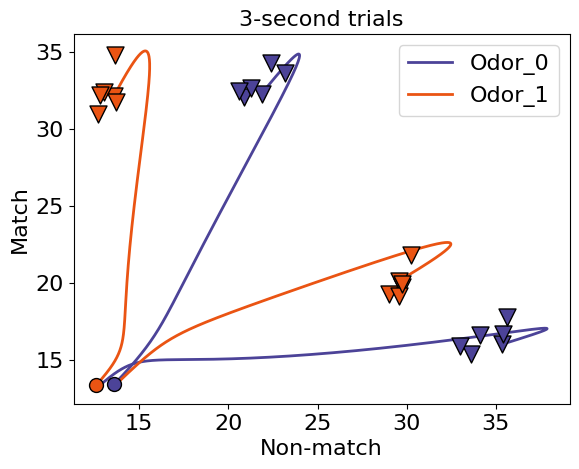

(3, 2160)
(90, 3)


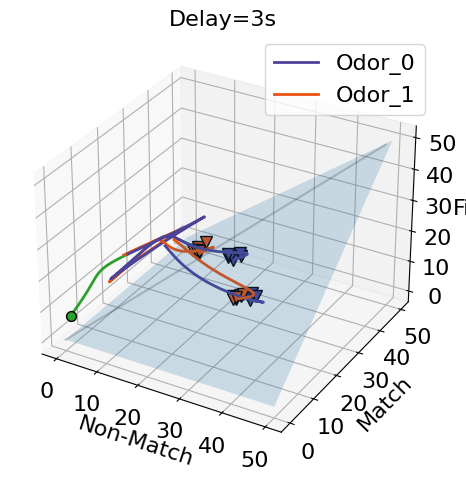

In [53]:

import warnings
warnings.filterwarnings('ignore')
from matplotlib.patches import Polygon
%matplotlib inline
N = 0

with open('/home/jiashuncheng/code/Trasient/ODPA/savedir/w_1output.pkl', 'rb') as handle:
    w_out = pickle.load(handle).detach().cpu().numpy()
with open('/home/jiashuncheng/code/Trasient/ODPA/savedir/b_1output.pkl', 'rb') as handle:
    b_out = pickle.load(handle).detach().cpu().numpy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/3_1test180du_7.pkl' #mathc=1
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,N,:]
results[90:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[80:90]
print('newdata0:',label, 2)
hidden_act = temp.T
# print('output1:', hidden_act[0])
# print('output2:', hidden_act[1])
# print('output3:', hidden_act[2])
data0 = hidden_act
newdata0 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/3_1test180du_8.pkl' #mathc=0
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,N,:]
results[90:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[80:90]
print('newdata1:',label, 1)
hidden_act = temp.T
data0 = hidden_act
TI = cal_TI(data0,1,17)[0]
newdata1 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/3_1test_7.pkl' #mathc=1
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,N,:]
# results[60:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[50:60]
print('newdata2:',label, 2)
hidden_act = temp.T
data0 = hidden_act
TI = cal_TI(data0,1,17)[0]
newdata2 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/3_1test_8.pkl' #mathc=0
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,N,:]
# results[60:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[50:60]
print('newdata3:',label, 1)
hidden_act = temp.T
data0 = hidden_act
TI = cal_TI(data0,1,17)[0]
newdata3 = data0.copy()


netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/3_1test180du_7.pkl' #mathc=1
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,1,:]
results[90:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[80:90]
print('newdata4:',label, 2)
hidden_act = temp.T
data0 = hidden_act
TI = cal_TI(data0,1,17)[0]
newdata4 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/3_1test180du_8.pkl' #mathc=0
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,1,:]
results[90:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[80:90]
print('newdata5:',label, 1)
hidden_act = temp.T
data0 = hidden_act
TI = cal_TI(data0,1,17)[0]
newdata5 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/3_1test_7.pkl' #mathc=1
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,1,:]
# results[60:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[50:60]
print('newdata6:',label, 2)
hidden_act = temp.T
data0 = hidden_act
TI = cal_TI(data0,1,17)[0]
newdata6 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/3_1test_8.pkl' #mathc=0
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,1,:]
# results[60:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[50:60]
print('newdata7:',label, 1)
hidden_act = temp.T
data0 = hidden_act
TI = cal_TI(data0,1,17)[0]
newdata7 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/3_1test180du_7.pkl' #mathc=1
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,2,:]
results[90:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[80:90]
print('newdata8:',label, 2)
hidden_act = temp.T
data0 = hidden_act
TI = cal_TI(data0,1,17)[0]
newdata8 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/3_1test180du_8.pkl' #mathc=0
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,2,:]
results[90:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[80:90]
print('newdata9:',label, 1)
hidden_act = temp.T
data0 = hidden_act
TI = cal_TI(data0,1,17)[0]
newdata9 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/3_1test_7.pkl' #mathc=1
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,2,:]
# results[60:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[50:60]
print('newdata10:',label, 2)
hidden_act = temp.T
data0 = hidden_act
TI = cal_TI(data0,1,17)[0]
newdata10 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/3_1test_8.pkl' #mathc=0
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,2,:]
# results[60:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[50:60]
print('newdata11:',label, 1)
hidden_act = temp.T
data0 = hidden_act
TI = cal_TI(data0,1,17)[0]
newdata11 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/3_1test180du_7.pkl' #mathc=1
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,3,:]
results[90:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[80:90]
print('newdata12:',label, 2)
hidden_act = temp.T
data0 = hidden_act
TI = cal_TI(data0,1,17)[0]
newdata12 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/3_1test180du_8.pkl' #mathc=0
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,3,:]
results[90:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[80:90]
print('newdata13:',label, 1)
hidden_act = temp.T
data0 = hidden_act
TI = cal_TI(data0,1,17)[0]
newdata13 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/3_1test_7.pkl' #mathc=1
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,3,:]
# results[60:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[50:60]
print('newdata14:',label,2)
hidden_act = temp.T
data0 = hidden_act
TI = cal_TI(data0,1,17)[0]
newdata14 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/3_1test_8.pkl' #mathc=0
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,3,:]
# results[60:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[50:60]
print('newdata15:',label,1)
hidden_act = temp.T
data0 = hidden_act
TI = cal_TI(data0,1,17)[0]
newdata15 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/3_1test180du_7.pkl' #mathc=1
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,4,:]
results[90:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[80:90]
print('newdata16:',label,2)
hidden_act = temp.T
data0 = hidden_act
TI = cal_TI(data0,1,17)[0]
newdata16 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/3_1test180du_8.pkl' #mathc=0
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,4,:]
results[90:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[80:90]
print('newdata17:',label,1)
hidden_act = temp.T
data0 = hidden_act
TI = cal_TI(data0,1,17)[0]
newdata17 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/3_1test_7.pkl' #mathc=1
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,4,:]
# results[60:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[50:60]
print('newdata18:',label,2)
hidden_act = temp.T
data0 = hidden_act
TI = cal_TI(data0,1,17)[0]
newdata18 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/3_1test_8.pkl' #mathc=0
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,4,:]
# results[60:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[50:60]
print('newdata19:',label,1)
hidden_act = temp.T
data0 = hidden_act
TI = cal_TI(data0,1,17)[0]
newdata19 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/3_1test180du_7.pkl' #mathc=1
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,5,:]
results[90:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[80:90]
print('newdata20:',label,2)
hidden_act = temp.T
data0 = hidden_act
TI = cal_TI(data0,1,17)[0]
newdata20 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/3_1test180du_8.pkl' #mathc=0
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,5,:]
results[90:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[80:90]
print('newdata21:',label,1)
hidden_act = temp.T
data0 = hidden_act
TI = cal_TI(data0,1,17)[0]
newdata21 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/3_1test_7.pkl' #mathc=1
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,5,:]
# results[60:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[50:60]
print('newdata22:',label,2)
hidden_act = temp.T
data0 = hidden_act
TI = cal_TI(data0,1,17)[0]
newdata22 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/3_1test_8.pkl' #mathc=0
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,5,:]
# results[60:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[50:60]
print('newdata23:',label,1)
hidden_act = temp.T
data0 = hidden_act
TI = cal_TI(data0,1,17)[0]
newdata23 = data0.copy()

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import FactorAnalysis
from sklearn.decomposition import FastICA
from sklearn.decomposition import DictionaryLearning
from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.decomposition import IncrementalPCA
from sklearn.manifold import Isomap
# from dPCA import dPCA

print(newdata0==newdata1)
data = np.hstack((newdata0, newdata1, newdata2, newdata3, newdata4, newdata5, newdata6, newdata7, newdata8, newdata9, newdata10, newdata11, newdata12, newdata13, newdata14, newdata15, newdata16, newdata17, newdata18, newdata19, newdata20, newdata21, newdata22, newdata23))
h_data = data.copy()
print(data.shape)


# N,T,S = 600,2160,6
# noise, n_samples = 0.2, 10
# data = np.expand_dims(data, 1)
# data = np.repeat(data, S, 1)
# data = np.expand_dims(data, 0)
# data = np.repeat(data, n_samples, 0)
# print(data.shape)
# # trial-average data
# R = np.mean(data,0)
# # center data
# R -= np.mean(R.reshape((N,-1)),1)[:,None,None]
# dpca = dPCA.dPCA(labels='st', n_components=2,regularizer='auto')
# dpca.protect = ['t']
# print(R.shape, data.shape)
# Z = dpca.fit_transform(R,data)
# print(Z['st'].shape)
# newdata = Z['st'][:,0,:].T

Model = PCA
pca = Model(n_components=2)
newdata = data.T
print(newdata.shape)
NUM =90
newtrace0 = newdata[:90, :]
newtrace1 = newdata[90:90*2, :]
newtrace2 = newdata[90*2:90*3, :]
newtrace3 = newdata[90*3:90*4, :]
newtrace4 = newdata[90*4:90*5, :]
newtrace5 = newdata[90*5:90*6, :]
newtrace6 = newdata[90*6:90*7, :]
newtrace7 = newdata[90*7:90*8, :]
newtrace8 = newdata[90*8:90*9, :]
newtrace9 = newdata[90*9:90*10, :]
newtrace10 = newdata[90*10:90*11, :]
newtrace11 = newdata[90*11:90*12, :]
newtrace12 = newdata[90*12:90*13, :]
newtrace13 = newdata[90*13:90*14, :]
newtrace14 = newdata[90*14:90*15, :]
newtrace15 = newdata[90*15:90*16, :]
newtrace16 = newdata[90*16:90*17, :]
newtrace17 = newdata[90*17:90*18, :]
newtrace18 = newdata[90*18:90*19, :]
newtrace19 = newdata[90*19:90*20, :]
newtrace20 = newdata[90*20:90*21, :]
newtrace21 = newdata[90*21:90*22, :]
newtrace22 = newdata[90*22:90*23, :]
newtrace23 = newdata[90*23:90*24, :]
print('newtrace0:', newtrace0.shape)
bz0 = Bezier(newtrace0, 1800)
matpi0=bz0.getBezierPoints(0)
bz1 = Bezier(newtrace1, 1800)
matpi1=bz1.getBezierPoints(0)
bz2 = Bezier(newtrace2, 1800)
matpi2=bz2.getBezierPoints(0)
bz3 = Bezier(newtrace3, 1800)
matpi3=bz3.getBezierPoints(0)
bz4 = Bezier(newtrace4, 1800)
matpi4=bz4.getBezierPoints(0)
bz5 = Bezier(newtrace5, 1800)
matpi5=bz5.getBezierPoints(0)
bz6 = Bezier(newtrace6, 1800)
matpi6=bz6.getBezierPoints(0)
bz7 = Bezier(newtrace7, 1800)
matpi7=bz7.getBezierPoints(0)
bz8 = Bezier(newtrace8, 1800)
matpi8=bz8.getBezierPoints(0)
bz9 = Bezier(newtrace9, 1800)
matpi9=bz9.getBezierPoints(0)
bz10 = Bezier(newtrace10, 1800)
matpi10=bz10.getBezierPoints(0)
bz11 = Bezier(newtrace11, 1800)
matpi11=bz11.getBezierPoints(0)
bz8 = Bezier(newtrace12, 1800)
matpi12=bz8.getBezierPoints(0)
bz9 = Bezier(newtrace13, 1800)
matpi13=bz9.getBezierPoints(0)
bz10 = Bezier(newtrace14, 1800)
matpi14=bz10.getBezierPoints(0)
bz11 = Bezier(newtrace15, 1800)
matpi15=bz11.getBezierPoints(0)
bz8 = Bezier(newtrace16, 1800)
matpi16=bz8.getBezierPoints(0)
bz9 = Bezier(newtrace17, 1800)
matpi17=bz9.getBezierPoints(0)
bz10 = Bezier(newtrace18, 1800)
matpi18=bz10.getBezierPoints(0)
bz11 = Bezier(newtrace19, 1800)
matpi19=bz11.getBezierPoints(0)
bz8 = Bezier(newtrace20, 1800)
matpi20=bz8.getBezierPoints(0)
bz9 = Bezier(newtrace21, 1800)
matpi21=bz9.getBezierPoints(0)
bz10 = Bezier(newtrace22, 1800)
matpi22=bz10.getBezierPoints(0)
bz11 = Bezier(newtrace23, 1800)
matpi23=bz11.getBezierPoints(0)


print(matpi0.shape)

fig=plt.figure()
ax = fig.gca()
plt.plot(matpi0[1800*2//3//6*5-200:1800*2//3//6*6,1],matpi0[1800*2//3//6*5-200:1800*2//3//6*6,2], color='#ea5413', linewidth=2,zorder=1)
plt.scatter(matpi0[1800*2//3//6*6,1],matpi0[1800*2//3//6*6,2], c='#ea5413', marker='v', s=150, edgecolors='k')
plt.plot(matpi1[1800*2//3//6*5-200:1800*2//3//6*6,1],matpi1[1800*2//3//6*5-200:1800*2//3//6*6,2], color='#4c4398', linewidth=2,zorder=1)
plt.scatter(matpi1[1800*2//3//6*6,1],matpi1[1800*2//3//6*6,2], c='#4c4398', marker='v', s=150, edgecolors='k')
plt.plot(matpi2[1800*2//3//6*5-200:1800*2//3//6*6,1],matpi2[1800*2//3//6*5-200:1800*2//3//6*6,2], color='#4c4398', linewidth=2, label='Odor_0',zorder=1)
plt.scatter(matpi2[1800*2//3//6*6,1],matpi2[1800*2//3//6*6,2], c='#4c4398', marker='v', s=150, edgecolors='k')
plt.plot(matpi3[1800*2//3//6*5-200:1800*2//3//6*6,1],matpi3[1800*2//3//6*5-200:1800*2//3//6*6,2], color='#ea5413', linewidth=2, label='Odor_1',zorder=1)
plt.scatter(matpi3[1800*2//3//6*6,1],matpi3[1800*2//3//6*6,2], c='#ea5413', marker='v', s=150, edgecolors='k')
plt.scatter(matpi4[1800*2//3//6*6,1],matpi4[1800*2//3//6*6,2], c='#ea5413', marker='v', s=150, edgecolors='k')
plt.scatter(matpi5[1800*2//3//6*6,1],matpi5[1800*2//3//6*6,2], c='#4c4398', marker='v', s=150, edgecolors='k')
plt.scatter(matpi6[1800*2//3//6*6,1],matpi6[1800*2//3//6*6,2], c='#4c4398', marker='v', s=150, edgecolors='k')
plt.scatter(matpi7[1800*2//3//6*6,1],matpi7[1800*2//3//6*6,2], c='#ea5413', marker='v', s=150, edgecolors='k')
plt.scatter(matpi8[1800*2//3//6*6,1],matpi8[1800*2//3//6*6,2], c='#ea5413', marker='v', s=150, edgecolors='k')
plt.scatter(matpi9[1800*2//3//6*6,1],matpi9[1800*2//3//6*6,2], c='#4c4398', marker='v', s=150, edgecolors='k')
plt.scatter(matpi10[1800*2//3//6*6,1],matpi10[1800*2//3//6*6,2], c='#4c4398', marker='v', s=150, edgecolors='k')
plt.scatter(matpi11[1800*2//3//6*6,1],matpi11[1800*2//3//6*6,2], c='#ea5413', marker='v', s=150, edgecolors='k')
plt.scatter(matpi12[1800*2//3//6*6,1],matpi12[1800*2//3//6*6,2], c='#ea5413', marker='v', s=150, edgecolors='k')
plt.scatter(matpi13[1800*2//3//6*6,1],matpi13[1800*2//3//6*6,2], c='#4c4398', marker='v', s=150, edgecolors='k')
plt.scatter(matpi14[1800*2//3//6*6,1],matpi14[1800*2//3//6*6,2], c='#4c4398', marker='v', s=150, edgecolors='k')
plt.scatter(matpi15[1800*2//3//6*6,1],matpi15[1800*2//3//6*6,2], c='#ea5413', marker='v', s=150, edgecolors='k')
plt.scatter(matpi16[1800*2//3//6*6,1],matpi16[1800*2//3//6*6,2], c='#ea5413', marker='v', s=150, edgecolors='k')
plt.scatter(matpi17[1800*2//3//6*6,1],matpi17[1800*2//3//6*6,2], c='#4c4398', marker='v', s=150, edgecolors='k')
plt.scatter(matpi18[1800*2//3//6*6,1],matpi18[1800*2//3//6*6,2], c='#4c4398', marker='v', s=150, edgecolors='k')
plt.scatter(matpi19[1800*2//3//6*6,1],matpi19[1800*2//3//6*6,2], c='#ea5413', marker='v', s=150, edgecolors='k')
plt.scatter(matpi20[1800*2//3//6*6,1],matpi20[1800*2//3//6*6,2], c='#ea5413', marker='v', s=150, edgecolors='k')
plt.scatter(matpi21[1800*2//3//6*6,1],matpi21[1800*2//3//6*6,2], c='#4c4398', marker='v', s=150, edgecolors='k')
plt.scatter(matpi22[1800*2//3//6*6,1],matpi22[1800*2//3//6*6,2], c='#4c4398', marker='v', s=150, edgecolors='k')
plt.scatter(matpi23[1800*2//3//6*6,1],matpi23[1800*2//3//6*6,2], c='#ea5413', marker='v', s=150, edgecolors='k')

plt.scatter(matpi0[1800*2//3//6*5-200,1],matpi0[1800*2//3//6*5-200,2], c='#ea5413', marker='o', s=100, edgecolors='k',zorder=2)
plt.scatter(matpi2[1800*2//3//6*5-200,1],matpi2[1800*2//3//6*5-200,2], c='#4c4398', marker='o', s=100, edgecolors='k',zorder=2)
# plt.plot([0,50], [0,50])
plt.legend()

plt.xlabel('Non-match',fontsize=16)
plt.ylabel('Match',fontsize=16)
plt.title('3-second trials',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.savefig('figure/fig3d1.svg')

plt.show()


data = np.hstack((newdata0, newdata1, newdata2, newdata3, newdata4, newdata5, newdata6, newdata7, newdata8, newdata9, newdata10, newdata11, newdata12, newdata13, newdata14, newdata15, newdata16, newdata17, newdata18, newdata19, newdata20, newdata21, newdata22, newdata23))
h_data = data.copy()
print(data.shape)

# N,T,S = 600,2160,6
# noise, n_samples = 0.2, 10
# data = np.expand_dims(data, 1)
# data = np.repeat(data, S, 1)
# data = np.expand_dims(data, 0)
# data = np.repeat(data, n_samples, 0)
# print(data.shape)
# # trial-average data
# R = np.mean(data,0)
# # center data
# R -= np.mean(R.reshape((N,-1)),1)[:,None,None]
# dpca = dPCA.dPCA(labels='st', n_components=3,regularizer='auto')
# dpca.protect = ['t']
# print(R.shape, data.shape)
# Z = dpca.fit_transform(R,data)
# print(Z['st'].shape)
# newdata = Z['st'][:,0,:].T

pca = Model(n_components=3)
newdata = data.T
NUM =90
newtrace0 = newdata[:90, :]
newtrace1 = newdata[90:90*2, :]
newtrace2 = newdata[90*2:90*3, :]
newtrace3 = newdata[90*3:90*4, :]
newtrace4 = newdata[90*4:90*5, :]
newtrace5 = newdata[90*5:90*6, :]
newtrace6 = newdata[90*6:90*7, :]
newtrace7 = newdata[90*7:90*8, :]
newtrace8 = newdata[90*8:90*9, :]
newtrace9 = newdata[90*9:90*10, :]
newtrace10 = newdata[90*10:90*11, :]
newtrace11 = newdata[90*11:90*12, :]
newtrace12 = newdata[90*12:90*13, :]
newtrace13 = newdata[90*13:90*14, :]
newtrace14 = newdata[90*14:90*15, :]
newtrace15 = newdata[90*15:90*16, :]
newtrace16 = newdata[90*16:90*17, :]
newtrace17 = newdata[90*17:90*18, :]
newtrace18 = newdata[90*18:90*19, :]
newtrace19 = newdata[90*19:90*20, :]
newtrace20 = newdata[90*20:90*21, :]
newtrace21 = newdata[90*21:90*22, :]
newtrace22 = newdata[90*22:90*23, :]
newtrace23 = newdata[90*23:90*24, :]
print(newtrace0.shape)
bz0 = Bezier(newtrace0, 1800)
matpi0=bz0.getBezierPoints(0)
bz1 = Bezier(newtrace1, 1800)
matpi1=bz1.getBezierPoints(0)
bz2 = Bezier(newtrace2, 1800)
matpi2=bz2.getBezierPoints(0)
bz3 = Bezier(newtrace3, 1800)
matpi3=bz3.getBezierPoints(0)
bz4 = Bezier(newtrace4, 1800)
matpi4=bz4.getBezierPoints(0)
bz5 = Bezier(newtrace5, 1800)
matpi5=bz5.getBezierPoints(0)
bz6 = Bezier(newtrace6, 1800)
matpi6=bz6.getBezierPoints(0)
bz7 = Bezier(newtrace7, 1800)
matpi7=bz7.getBezierPoints(0)
bz8 = Bezier(newtrace8, 1800)
matpi8=bz8.getBezierPoints(0)
bz9 = Bezier(newtrace9, 1800)
matpi9=bz9.getBezierPoints(0)
bz10 = Bezier(newtrace10, 1800)
matpi10=bz10.getBezierPoints(0)
bz11 = Bezier(newtrace11, 1800)
matpi11=bz11.getBezierPoints(0)
bz8 = Bezier(newtrace12, 1800)
matpi12=bz8.getBezierPoints(0)
bz9 = Bezier(newtrace13, 1800)
matpi13=bz9.getBezierPoints(0)
bz10 = Bezier(newtrace14, 1800)
matpi14=bz10.getBezierPoints(0)
bz11 = Bezier(newtrace15, 1800)
matpi15=bz11.getBezierPoints(0)
bz8 = Bezier(newtrace16, 1800)
matpi16=bz8.getBezierPoints(0)
bz9 = Bezier(newtrace17, 1800)
matpi17=bz9.getBezierPoints(0)
bz10 = Bezier(newtrace18, 1800)
matpi18=bz10.getBezierPoints(0)
bz11 = Bezier(newtrace19, 1800)
matpi19=bz11.getBezierPoints(0)
bz8 = Bezier(newtrace20, 1800)
matpi20=bz8.getBezierPoints(0)
bz9 = Bezier(newtrace21, 1800)
matpi21=bz9.getBezierPoints(0)
bz10 = Bezier(newtrace22, 1800)
matpi22=bz10.getBezierPoints(0)
bz11 = Bezier(newtrace23, 1800)
matpi23=bz11.getBezierPoints(0)


fig=plt.figure()
ax = fig.add_subplot(projection='3d')
SIZE = 8
ax.plot(matpi0[1800*2//3//6*5-100:1800*2//3//6*6,1],matpi0[1800*2//3//6*5-100:1800*2//3//6*6,2],matpi0[1800*2//3//6*5-100:1800*2//3//6*6,0], color='#ea5413', linewidth=2,zorder=3)
ax.plot(matpi0[1800*2//3//6*6,1],matpi0[1800*2//3//6*6,2],matpi0[1800*2//3//6*6,0], markerfacecolor='#ea5413', marker='v', markersize=SIZE, c='k',zorder=1)
ax.plot(matpi1[1800*2//3//6*5-100:1800*2//3//6*6,1],matpi1[1800*2//3//6*5-100:1800*2//3//6*6,2],matpi1[1800*2//3//6*5-100:1800*2//3//6*6,0], color='#4c4398', linewidth=2,zorder=3)
ax.plot(matpi1[1800*2//3//6*6,1],matpi1[1800*2//3//6*6,2],matpi1[1800*2//3//6*6,0], markerfacecolor='#4c4398', marker='v', markersize=SIZE, c='k',zorder=1)
ax.plot(matpi2[1800*2//3//6*5-100:1800*2//3//6*6,1],matpi2[1800*2//3//6*5-100:1800*2//3//6*6,2],matpi2[1800*2//3//6*5-100:1800*2//3//6*6,0], color='#4c4398', linewidth=2, label='Odor_0',zorder=3)
ax.plot(matpi2[1800*2//3//6*6,1],matpi2[1800*2//3//6*6,2],matpi2[1800*2//3//6*6,0], markerfacecolor='#4c4398', marker='v', markersize=SIZE, c='k',zorder=1)
ax.plot(matpi3[1800*2//3//6*5-100:1800*2//3//6*6,1],matpi3[1800*2//3//6*5-100:1800*2//3//6*6,2],matpi3[1800*2//3//6*5-100:1800*2//3//6*6,0], color='#ea5413', linewidth=2, label='Odor_1',zorder=3)
ax.plot(matpi3[1800*2//3//6*6,1],matpi3[1800*2//3//6*6,2],matpi3[1800*2//3//6*6,0], markerfacecolor='#ea5413', marker='v', markersize=SIZE, c='k',zorder=1)
ax.plot(matpi4[1800*2//3//6*6,1],matpi4[1800*2//3//6*6,2],matpi4[1800*2//3//6*6,0], markerfacecolor='#ea5413', marker='v', markersize=SIZE, c='k',zorder=1)
ax.plot(matpi5[1800*2//3//6*6,1],matpi5[1800*2//3//6*6,2],matpi5[1800*2//3//6*6,0], markerfacecolor='#4c4398', marker='v', markersize=SIZE, c='k',zorder=1)
ax.plot(matpi6[1800*2//3//6*6,1],matpi6[1800*2//3//6*6,2],matpi6[1800*2//3//6*6,0], markerfacecolor='#4c4398', marker='v', markersize=SIZE, c='k',zorder=1)
ax.plot(matpi7[1800*2//3//6*6,1],matpi7[1800*2//3//6*6,2],matpi7[1800*2//3//6*6,0], markerfacecolor='#ea5413', marker='v', markersize=SIZE, c='k',zorder=1)
ax.plot(matpi8[1800*2//3//6*6,1],matpi8[1800*2//3//6*6,2],matpi8[1800*2//3//6*6,0], markerfacecolor='#ea5413', marker='v', markersize=SIZE, c='k',zorder=1)
ax.plot(matpi9[1800*2//3//6*6,1],matpi9[1800*2//3//6*6,2],matpi9[1800*2//3//6*6,0], markerfacecolor='#4c4398', marker='v', markersize=SIZE, c='k',zorder=1)
ax.plot(matpi10[1800*2//3//6*6,1],matpi10[1800*2//3//6*6,2],matpi10[1800*2//3//6*6,0], markerfacecolor='#4c4398', marker='v', markersize=SIZE, c='k',zorder=1)
ax.plot(matpi11[1800*2//3//6*6,1],matpi11[1800*2//3//6*6,2],matpi11[1800*2//3//6*6,0], markerfacecolor='#ea5413', marker='v', markersize=SIZE, c='k',zorder=1)
ax.plot(matpi12[1800*2//3//6*6,1],matpi12[1800*2//3//6*6,2],matpi12[1800*2//3//6*6,0], markerfacecolor='#ea5413', marker='v', markersize=SIZE, c='k',zorder=1)
ax.plot(matpi13[1800*2//3//6*6,1],matpi13[1800*2//3//6*6,2],matpi13[1800*2//3//6*6,0], markerfacecolor='#4c4398', marker='v', markersize=SIZE, c='k',zorder=1)
ax.plot(matpi14[1800*2//3//6*6,1],matpi14[1800*2//3//6*6,2],matpi14[1800*2//3//6*6,0], markerfacecolor='#4c4398', marker='v', markersize=SIZE, c='k',zorder=1)
ax.plot(matpi15[1800*2//3//6*6,1],matpi15[1800*2//3//6*6,2],matpi15[1800*2//3//6*6,0], markerfacecolor='#ea5413', marker='v', markersize=SIZE, c='k',zorder=1)
ax.plot(matpi16[1800*2//3//6*6,1],matpi16[1800*2//3//6*6,2],matpi16[1800*2//3//6*6,0], markerfacecolor='#ea5413', marker='v', markersize=SIZE, c='k',zorder=1)
ax.plot(matpi17[1800*2//3//6*6,1],matpi17[1800*2//3//6*6,2],matpi17[1800*2//3//6*6,0], markerfacecolor='#4c4398', marker='v', markersize=SIZE, c='k',zorder=1)
ax.plot(matpi18[1800*2//3//6*6,1],matpi18[1800*2//3//6*6,2],matpi18[1800*2//3//6*6,0], markerfacecolor='#4c4398', marker='v', markersize=SIZE, c='k',zorder=1)
ax.plot(matpi19[1800*2//3//6*6,1],matpi19[1800*2//3//6*6,2],matpi19[1800*2//3//6*6,0], markerfacecolor='#ea5413', marker='v', markersize=SIZE, c='k',zorder=1)
ax.plot(matpi20[1800*2//3//6*6,1],matpi20[1800*2//3//6*6,2],matpi20[1800*2//3//6*6,0], markerfacecolor='#ea5413', marker='v', markersize=SIZE, c='k',zorder=1)
ax.plot(matpi21[1800*2//3//6*6,1],matpi21[1800*2//3//6*6,2],matpi21[1800*2//3//6*6,0], markerfacecolor='#4c4398', marker='v', markersize=SIZE, c='k',zorder=1)
ax.plot(matpi22[1800*2//3//6*6,1],matpi22[1800*2//3//6*6,2],matpi22[1800*2//3//6*6,0], markerfacecolor='#4c4398', marker='v', markersize=SIZE, c='k',zorder=1)
ax.plot(matpi23[1800*2//3//6*6,1],matpi23[1800*2//3//6*6,2],matpi23[1800*2//3//6*6,0], markerfacecolor='#ea5413', marker='v', markersize=SIZE, c='k',zorder=1)

ax.scatter(matpi3[0,1],matpi3[0,2],matpi3[0,0], c='C2', marker='o', s=50, edgecolors='k')
ax.plot(matpi3[0:1800*2//3//6*1,1],matpi3[0:1800*2//3//6*1,2],matpi3[0:1800*2//3//6*1,0], color='C2', linewidth=2)
ax.plot(matpi0[1800*2//3//6*1:1800*2//3//6*5-100,1],matpi0[1800*2//3//6*1:1800*2//3//6*5-100,2],matpi0[1800*2//3//6*1:1800*2//3//6*5-100,0], color='#ea5413', linewidth=2)
# ax.plot(matpi1[1800*2//3//6*1:1800*2//3//6*5-100,1],matpi1[1800*2//3//6*1:1800*2//3//6*5-100,2],matpi1[1800*2//3//6*1:1800*2//3//6*5-100,0], color='#ea5413', linewidth=2)
ax.plot(matpi2[1800*2//3//6*1:1800*2//3//6*5,1],matpi2[1800*2//3//6*1:1800*2//3//6*5,2],matpi2[1800*2//3//6*1:1800*2//3//6*5,0], color='#4c4398', linewidth=2)
# ax.plot(matpi3[1800*2//3//6*1:1800*2//3//6*5,1],matpi3[1800*2//3//6*1:1800*2//3//6*5,2],matpi3[1800*2//3//6*1:1800*2//3//6*5,0], color='#4c4398', linewidth=2)

ax.plot_trisurf([0,50,50], [0,0,50], [0,0,50], antialiased=True, alpha=0.2, color='C0')
ax.plot_trisurf([0,0,50], [0,50,50], [0,0,50], antialiased=True, alpha=0.2, color='C0')

ax.plot(np.arange(0,50),np.arange(0,50),np.arange(0,50), color='k', alpha=0.2)
ax.set_xlabel('Non-Match',fontsize=16)
ax.set_ylabel('Match',fontsize=16)
ax.set_zlabel('Fix',fontsize=16)
ax.tick_params(axis='x',labelsize=16)
ax.tick_params(axis='y',labelsize=16)
ax.tick_params(axis='z',labelsize=16)
plt.title('Delay=3s',fontsize=16)
plt.legend(fontsize=16)
plt.tight_layout()
plt.savefig('figure/suppfig2d1.svg')
plt.show()

## 6s output

newdata0: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2] 2
newdata1: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 2 1 1 1 1 1 1 1 1 1] 1
newdata2: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2] 2
newdata3: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 2 1 1 1 1 1 1 1 1 1] 1
newdata4: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2] 2
newdata5: [0 0 0 0 0

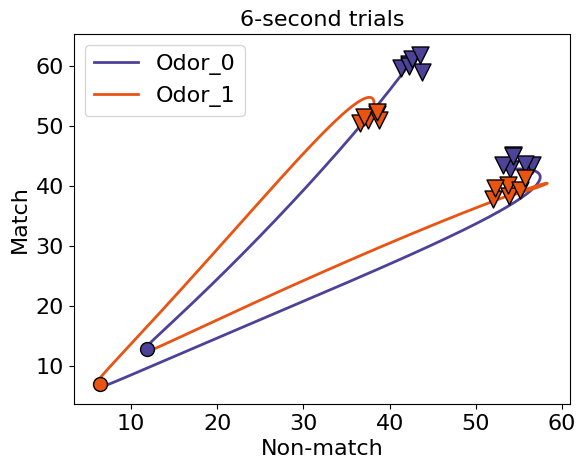

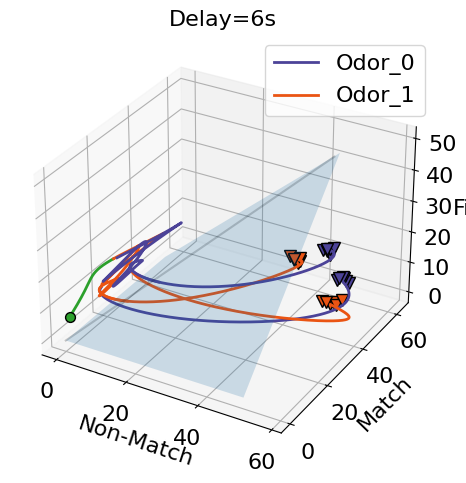

In [54]:

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
N = 0

with open('/home/jiashuncheng/code/Trasient/ODPA/savedir/w_1output.pkl', 'rb') as handle:
    w_out = pickle.load(handle).detach().cpu().numpy()
with open('/home/jiashuncheng/code/Trasient/ODPA/savedir/b_1output.pkl', 'rb') as handle:
    b_out = pickle.load(handle).detach().cpu().numpy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/6_1test180du_7.pkl' #mathc=1
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,N,:]
results[90:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[80:90]
print('newdata0:',label, 2)
hidden_act = temp.T
# print('output1:', hidden_act[0])
# print('output2:', hidden_act[1])
# print('output3:', hidden_act[2])
data0 = hidden_act
newdata0 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/6_1test180du_8.pkl' #mathc=0
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,N,:]
results[90:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[80:90]
print('newdata1:',label, 1)
hidden_act = temp.T
data0 = hidden_act
TI = cal_TI(data0,1,17)[0]
newdata1 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/6_1test_7.pkl' #mathc=1
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,N,:]
# results[60:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[50:60]
print('newdata2:',label, 2)
hidden_act = temp.T
data0 = hidden_act
TI = cal_TI(data0,1,17)[0]
newdata2 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/6_1test_8.pkl' #mathc=0
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,N,:]
# results[60:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[50:60]
print('newdata3:',label, 1)
hidden_act = temp.T
data0 = hidden_act
TI = cal_TI(data0,1,17)[0]
newdata3 = data0.copy()


netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/6_1test180du_7.pkl' #mathc=1
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,1,:]
results[90:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[80:90]
print('newdata4:',label, 2)
hidden_act = temp.T
data0 = hidden_act
TI = cal_TI(data0,1,17)[0]
newdata4 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/6_1test180du_8.pkl' #mathc=0
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,1,:]
results[90:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[80:90]
print('newdata5:',label, 1)
hidden_act = temp.T
data0 = hidden_act
TI = cal_TI(data0,1,17)[0]
newdata5 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/6_1test_7.pkl' #mathc=1
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,1,:]
# results[60:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[50:60]
print('newdata6:',label, 2)
hidden_act = temp.T
data0 = hidden_act
TI = cal_TI(data0,1,17)[0]
newdata6 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/6_1test_8.pkl' #mathc=0
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,1,:]
# results[60:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[50:60]
print('newdata7:',label, 1)
hidden_act = temp.T
data0 = hidden_act
TI = cal_TI(data0,1,17)[0]
newdata7 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/6_1test180du_7.pkl' #mathc=1
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,2,:]
results[90:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[80:90]
print('newdata8:',label, 2)
hidden_act = temp.T
data0 = hidden_act
TI = cal_TI(data0,1,17)[0]
newdata8 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/6_1test180du_8.pkl' #mathc=0
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,2,:]
results[90:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[80:90]
print('newdata9:',label, 1)
hidden_act = temp.T
data0 = hidden_act
TI = cal_TI(data0,1,17)[0]
newdata9 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/6_1test_7.pkl' #mathc=1
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,2,:]
# results[60:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[50:60]
print('newdata10:',label, 2)
hidden_act = temp.T
data0 = hidden_act
TI = cal_TI(data0,1,17)[0]
newdata10 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/6_1test_8.pkl' #mathc=0
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,2,:]
# results[60:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[50:60]
print('newdata11:',label, 1)
hidden_act = temp.T
data0 = hidden_act
TI = cal_TI(data0,1,17)[0]
newdata11 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/6_1test180du_7.pkl' #mathc=1
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,3,:]
results[90:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[80:90]
print('newdata12:',label, 2)
hidden_act = temp.T
data0 = hidden_act
TI = cal_TI(data0,1,17)[0]
newdata12 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/6_1test180du_8.pkl' #mathc=0
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,3,:]
results[90:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[80:90]
print('newdata13:',label, 1)
hidden_act = temp.T
data0 = hidden_act
TI = cal_TI(data0,1,17)[0]
newdata13 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/6_1test_7.pkl' #mathc=1
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,3,:]
# results[60:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[50:60]
print('newdata14:',label,2)
hidden_act = temp.T
data0 = hidden_act
TI = cal_TI(data0,1,17)[0]
newdata14 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/6_1test_8.pkl' #mathc=0
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,3,:]
# results[60:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[50:60]
print('newdata15:',label,1)
hidden_act = temp.T
data0 = hidden_act
TI = cal_TI(data0,1,17)[0]
newdata15 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/6_1test180du_7.pkl' #mathc=1
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,4,:]
results[90:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[80:90]
print('newdata16:',label,2)
hidden_act = temp.T
data0 = hidden_act
TI = cal_TI(data0,1,17)[0]
newdata16 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/6_1test180du_8.pkl' #mathc=0
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,4,:]
results[90:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[80:90]
print('newdata17:',label,1)
hidden_act = temp.T
data0 = hidden_act
TI = cal_TI(data0,1,17)[0]
newdata17 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/6_1test_7.pkl' #mathc=1
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,4,:]
# results[60:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[50:60]
print('newdata18:',label,2)
hidden_act = temp.T
data0 = hidden_act
TI = cal_TI(data0,1,17)[0]
newdata18 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/6_1test_8.pkl' #mathc=0
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,4,:]
# results[60:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[50:60]
print('newdata19:',label,1)
hidden_act = temp.T
data0 = hidden_act
TI = cal_TI(data0,1,17)[0]
newdata19 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/6_1test180du_7.pkl' #mathc=1
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,5,:]
results[90:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[80:90]
print('newdata20:',label,2)
hidden_act = temp.T
data0 = hidden_act
TI = cal_TI(data0,1,17)[0]
newdata20 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/6_1test180du_8.pkl' #mathc=0
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,5,:]
results[90:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[80:90]
print('newdata21:',label,1)
hidden_act = temp.T
data0 = hidden_act
TI = cal_TI(data0,1,17)[0]
newdata21 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/6_1test_7.pkl' #mathc=1
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,5,:]
# results[60:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[50:60]
print('newdata22:',label,2)
hidden_act = temp.T
data0 = hidden_act
TI = cal_TI(data0,1,17)[0]
newdata22 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/6_1test_8.pkl' #mathc=0
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,5,:]
# results[60:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[50:60]
print('newdata23:',label,1)
hidden_act = temp.T
data0 = hidden_act
TI = cal_TI(data0,1,17)[0]
newdata23 = data0.copy()

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import FactorAnalysis
from sklearn.decomposition import FastICA
from sklearn.decomposition import DictionaryLearning
from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.decomposition import IncrementalPCA
from sklearn.manifold import Isomap
# from dPCA import dPCA

data = np.hstack((newdata0, newdata1, newdata2, newdata3, newdata4, newdata5, newdata6, newdata7, newdata8, newdata9, newdata10, newdata11, newdata12, newdata13, newdata14, newdata15, newdata16, newdata17, newdata18, newdata19, newdata20, newdata21, newdata22, newdata23))
h_data = data.copy()
print(data.shape)


# N,T,S = 600,2160,6
# noise, n_samples = 0.2, 10
# data = np.expand_dims(data, 1)
# data = np.repeat(data, S, 1)
# data = np.expand_dims(data, 0)
# data = np.repeat(data, n_samples, 0)
# print(data.shape)
# # trial-average data
# R = np.mean(data,0)
# # center data
# R -= np.mean(R.reshape((N,-1)),1)[:,None,None]
# dpca = dPCA.dPCA(labels='st', n_components=2,regularizer='auto')
# dpca.protect = ['t']
# print(R.shape, data.shape)
# Z = dpca.fit_transform(R,data)
# print(Z['st'].shape)
# newdata = Z['st'][:,0,:].T

Model = PCA
pca = Model(n_components=2)
newdata = data.T
print(newdata.shape)
NUM =90
newtrace0 = newdata[:90, :]
newtrace1 = newdata[90:90*2, :]
newtrace2 = newdata[90*2:90*3, :]
newtrace3 = newdata[90*3:90*4, :]
newtrace4 = newdata[90*4:90*5, :]
newtrace5 = newdata[90*5:90*6, :]
newtrace6 = newdata[90*6:90*7, :]
newtrace7 = newdata[90*7:90*8, :]
newtrace8 = newdata[90*8:90*9, :]
newtrace9 = newdata[90*9:90*10, :]
newtrace10 = newdata[90*10:90*11, :]
newtrace11 = newdata[90*11:90*12, :]
newtrace12 = newdata[90*12:90*13, :]
newtrace13 = newdata[90*13:90*14, :]
newtrace14 = newdata[90*14:90*15, :]
newtrace15 = newdata[90*15:90*16, :]
newtrace16 = newdata[90*16:90*17, :]
newtrace17 = newdata[90*17:90*18, :]
newtrace18 = newdata[90*18:90*19, :]
newtrace19 = newdata[90*19:90*20, :]
newtrace20 = newdata[90*20:90*21, :]
newtrace21 = newdata[90*21:90*22, :]
newtrace22 = newdata[90*22:90*23, :]
newtrace23 = newdata[90*23:90*24, :]
print('newtrace0:', newtrace0.shape)
bz0 = Bezier(newtrace0, 1800)
matpi0=bz0.getBezierPoints(0)
bz1 = Bezier(newtrace1, 1800)
matpi1=bz1.getBezierPoints(0)
bz2 = Bezier(newtrace2, 1800)
matpi2=bz2.getBezierPoints(0)
bz3 = Bezier(newtrace3, 1800)
matpi3=bz3.getBezierPoints(0)
bz4 = Bezier(newtrace4, 1800)
matpi4=bz4.getBezierPoints(0)
bz5 = Bezier(newtrace5, 1800)
matpi5=bz5.getBezierPoints(0)
bz6 = Bezier(newtrace6, 1800)
matpi6=bz6.getBezierPoints(0)
bz7 = Bezier(newtrace7, 1800)
matpi7=bz7.getBezierPoints(0)
bz8 = Bezier(newtrace8, 1800)
matpi8=bz8.getBezierPoints(0)
bz9 = Bezier(newtrace9, 1800)
matpi9=bz9.getBezierPoints(0)
bz10 = Bezier(newtrace10, 1800)
matpi10=bz10.getBezierPoints(0)
bz11 = Bezier(newtrace11, 1800)
matpi11=bz11.getBezierPoints(0)
bz8 = Bezier(newtrace12, 1800)
matpi12=bz8.getBezierPoints(0)
bz9 = Bezier(newtrace13, 1800)
matpi13=bz9.getBezierPoints(0)
bz10 = Bezier(newtrace14, 1800)
matpi14=bz10.getBezierPoints(0)
bz11 = Bezier(newtrace15, 1800)
matpi15=bz11.getBezierPoints(0)
bz8 = Bezier(newtrace16, 1800)
matpi16=bz8.getBezierPoints(0)
bz9 = Bezier(newtrace17, 1800)
matpi17=bz9.getBezierPoints(0)
bz10 = Bezier(newtrace18, 1800)
matpi18=bz10.getBezierPoints(0)
bz11 = Bezier(newtrace19, 1800)
matpi19=bz11.getBezierPoints(0)
bz8 = Bezier(newtrace20, 1800)
matpi20=bz8.getBezierPoints(0)
bz9 = Bezier(newtrace21, 1800)
matpi21=bz9.getBezierPoints(0)
bz10 = Bezier(newtrace22, 1800)
matpi22=bz10.getBezierPoints(0)
bz11 = Bezier(newtrace23, 1800)
matpi23=bz11.getBezierPoints(0)


print(matpi0.shape)

fig=plt.figure()
ax = fig.gca()
plt.plot(matpi0[1800//9*8-100:1800//9*9,1],matpi0[1800//9*8-100:1800//9*9,2], color='#ea5413', linewidth=2,zorder=1)
plt.scatter(matpi0[1800//9*9,1],matpi0[1800//9*9,2], c='#ea5413', marker='v', s=150, edgecolors='k')
plt.plot(matpi1[1800//9*8-100:1800//9*9,1],matpi1[1800//9*8-100:1800//9*9,2], color='#4c4398', linewidth=2,zorder=1)
plt.scatter(matpi1[1800//9*9,1],matpi1[1800//9*9,2], c='#4c4398', marker='v', s=150, edgecolors='k')
plt.plot(matpi2[1800//9*8-100:1800//9*9,1],matpi2[1800//9*8-100:1800//9*9,2], color='#4c4398', linewidth=2,zorder=1, label='Odor_0')
plt.scatter(matpi2[1800//9*9,1],matpi2[1800//9*9,2], c='#4c4398', marker='v', s=150, edgecolors='k')
plt.plot(matpi3[1800//9*8-100:1800//9*9,1],matpi3[1800//9*8-100:1800//9*9,2], color='#ea5413', linewidth=2,zorder=1, label='Odor_1')
plt.scatter(matpi3[1800//9*9,1],matpi3[1800//9*9,2], c='#ea5413', marker='v', s=150, edgecolors='k')
plt.scatter(matpi4[1800//9*9,1],matpi4[1800//9*9,2], c='#ea5413', marker='v', s=150, edgecolors='k')
plt.scatter(matpi5[1800//9*9,1],matpi5[1800//9*9,2], c='#4c4398', marker='v', s=150, edgecolors='k')
plt.scatter(matpi6[1800//9*9,1],matpi6[1800//9*9,2], c='#4c4398', marker='v', s=150, edgecolors='k')
plt.scatter(matpi7[1800//9*9,1],matpi7[1800//9*9,2], c='#ea5413', marker='v', s=150, edgecolors='k')
plt.scatter(matpi8[1800//9*9,1],matpi8[1800//9*9,2], c='#ea5413', marker='v', s=150, edgecolors='k')
plt.scatter(matpi9[1800//9*9,1],matpi9[1800//9*9,2], c='#4c4398', marker='v', s=150, edgecolors='k')
plt.scatter(matpi10[1800//9*9,1],matpi10[1800//9*9,2], c='#4c4398', marker='v', s=150, edgecolors='k')
plt.scatter(matpi11[1800//9*9,1],matpi11[1800//9*9,2], c='#ea5413', marker='v', s=150, edgecolors='k')
plt.scatter(matpi12[1800//9*9,1],matpi12[1800//9*9,2], c='#ea5413', marker='v', s=150, edgecolors='k')
plt.scatter(matpi13[1800//9*9,1],matpi13[1800//9*9,2], c='#4c4398', marker='v', s=150, edgecolors='k')
plt.scatter(matpi14[1800//9*9,1],matpi14[1800//9*9,2], c='#4c4398', marker='v', s=150, edgecolors='k')
plt.scatter(matpi15[1800//9*9,1],matpi15[1800//9*9,2], c='#ea5413', marker='v', s=150, edgecolors='k')
plt.scatter(matpi16[1800//9*9,1],matpi16[1800//9*9,2], c='#ea5413', marker='v', s=150, edgecolors='k')
plt.scatter(matpi17[1800//9*9,1],matpi17[1800//9*9,2], c='#4c4398', marker='v', s=150, edgecolors='k')
plt.scatter(matpi18[1800//9*9,1],matpi18[1800//9*9,2], c='#4c4398', marker='v', s=150, edgecolors='k')
plt.scatter(matpi19[1800//9*9,1],matpi19[1800//9*9,2], c='#ea5413', marker='v', s=150, edgecolors='k')
plt.scatter(matpi20[1800//9*9,1],matpi20[1800//9*9,2], c='#ea5413', marker='v', s=150, edgecolors='k')
plt.scatter(matpi21[1800//9*9,1],matpi21[1800//9*9,2], c='#4c4398', marker='v', s=150, edgecolors='k')
plt.scatter(matpi22[1800//9*9,1],matpi22[1800//9*9,2], c='#4c4398', marker='v', s=150, edgecolors='k')
plt.scatter(matpi23[1800//9*9,1],matpi23[1800//9*9,2], c='#ea5413', marker='v', s=150, edgecolors='k')

plt.scatter(matpi0[1800//9*8-100,1],matpi0[1800//9*8-100,2], c='#ea5413', marker='o', s=100, edgecolors='k',zorder=2)
plt.scatter(matpi2[1800//9*8-100,1],matpi2[1800//9*8-100,2], c='#4c4398', marker='o', s=100, edgecolors='k',zorder=2)

plt.legend()

plt.xlabel('Non-match',fontsize=16)
plt.ylabel('Match',fontsize=16)
plt.title('6-second trials',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.savefig('figure/fig3d2.svg')


data = np.hstack((newdata0, newdata1, newdata2, newdata3, newdata4, newdata5, newdata6, newdata7, newdata8, newdata9, newdata10, newdata11, newdata12, newdata13, newdata14, newdata15, newdata16, newdata17, newdata18, newdata19, newdata20, newdata21, newdata22, newdata23))
h_data = data.copy()
print(data.shape)

# N,T,S = 600,2160,6
# noise, n_samples = 0.2, 10
# data = np.expand_dims(data, 1)
# data = np.repeat(data, S, 1)
# data = np.expand_dims(data, 0)
# data = np.repeat(data, n_samples, 0)
# print(data.shape)
# # trial-average data
# R = np.mean(data,0)
# # center data
# R -= np.mean(R.reshape((N,-1)),1)[:,None,None]
# dpca = dPCA.dPCA(labels='st', n_components=3,regularizer='auto')
# dpca.protect = ['t']
# print(R.shape, data.shape)
# Z = dpca.fit_transform(R,data)
# print(Z['st'].shape)
# newdata = Z['st'][:,0,:].T

pca = Model(n_components=3)
newdata = data.T
NUM =90
newtrace0 = newdata[:90, :]
newtrace1 = newdata[90:90*2, :]
newtrace2 = newdata[90*2:90*3, :]
newtrace3 = newdata[90*3:90*4, :]
newtrace4 = newdata[90*4:90*5, :]
newtrace5 = newdata[90*5:90*6, :]
newtrace6 = newdata[90*6:90*7, :]
newtrace7 = newdata[90*7:90*8, :]
newtrace8 = newdata[90*8:90*9, :]
newtrace9 = newdata[90*9:90*10, :]
newtrace10 = newdata[90*10:90*11, :]
newtrace11 = newdata[90*11:90*12, :]
newtrace12 = newdata[90*12:90*13, :]
newtrace13 = newdata[90*13:90*14, :]
newtrace14 = newdata[90*14:90*15, :]
newtrace15 = newdata[90*15:90*16, :]
newtrace16 = newdata[90*16:90*17, :]
newtrace17 = newdata[90*17:90*18, :]
newtrace18 = newdata[90*18:90*19, :]
newtrace19 = newdata[90*19:90*20, :]
newtrace20 = newdata[90*20:90*21, :]
newtrace21 = newdata[90*21:90*22, :]
newtrace22 = newdata[90*22:90*23, :]
newtrace23 = newdata[90*23:90*24, :]
print(newtrace0.shape)
bz0 = Bezier(newtrace0, 1800)
matpi0=bz0.getBezierPoints(0)
bz1 = Bezier(newtrace1, 1800)
matpi1=bz1.getBezierPoints(0)
bz2 = Bezier(newtrace2, 1800)
matpi2=bz2.getBezierPoints(0)
bz3 = Bezier(newtrace3, 1800)
matpi3=bz3.getBezierPoints(0)
bz4 = Bezier(newtrace4, 1800)
matpi4=bz4.getBezierPoints(0)
bz5 = Bezier(newtrace5, 1800)
matpi5=bz5.getBezierPoints(0)
bz6 = Bezier(newtrace6, 1800)
matpi6=bz6.getBezierPoints(0)
bz7 = Bezier(newtrace7, 1800)
matpi7=bz7.getBezierPoints(0)
bz8 = Bezier(newtrace8, 1800)
matpi8=bz8.getBezierPoints(0)
bz9 = Bezier(newtrace9, 1800)
matpi9=bz9.getBezierPoints(0)
bz10 = Bezier(newtrace10, 1800)
matpi10=bz10.getBezierPoints(0)
bz11 = Bezier(newtrace11, 1800)
matpi11=bz11.getBezierPoints(0)
bz8 = Bezier(newtrace12, 1800)
matpi12=bz8.getBezierPoints(0)
bz9 = Bezier(newtrace13, 1800)
matpi13=bz9.getBezierPoints(0)
bz10 = Bezier(newtrace14, 1800)
matpi14=bz10.getBezierPoints(0)
bz11 = Bezier(newtrace15, 1800)
matpi15=bz11.getBezierPoints(0)
bz8 = Bezier(newtrace16, 1800)
matpi16=bz8.getBezierPoints(0)
bz9 = Bezier(newtrace17, 1800)
matpi17=bz9.getBezierPoints(0)
bz10 = Bezier(newtrace18, 1800)
matpi18=bz10.getBezierPoints(0)
bz11 = Bezier(newtrace19, 1800)
matpi19=bz11.getBezierPoints(0)
bz8 = Bezier(newtrace20, 1800)
matpi20=bz8.getBezierPoints(0)
bz9 = Bezier(newtrace21, 1800)
matpi21=bz9.getBezierPoints(0)
bz10 = Bezier(newtrace22, 1800)
matpi22=bz10.getBezierPoints(0)
bz11 = Bezier(newtrace23, 1800)
matpi23=bz11.getBezierPoints(0)


fig=plt.figure()
ax = fig.add_subplot(projection='3d')
SIZE = 8
ax.plot(matpi0[1800//9*8-100:1800//9*9,1],matpi0[1800//9*8-100:1800//9*9,2],matpi0[1800//9*8-100:1800//9*9,0], color='#ea5413', linewidth=2,zorder=2)
ax.plot(matpi0[1800//9*9,1],matpi0[1800//9*9,2],matpi0[1800//9*9,0], markerfacecolor='#ea5413', marker='v', markersize=SIZE, color='k')
ax.plot(matpi1[1800//9*8-100:1800//9*9,1],matpi1[1800//9*8-100:1800//9*9,2],matpi1[1800//9*8-100:1800//9*9,0], color='#4c4398', linewidth=2,zorder=2)
ax.plot(matpi1[1800//9*9,1],matpi1[1800//9*9,2],matpi1[1800//9*9,0], markerfacecolor='#4c4398', marker='v', markersize=SIZE, color='k')
ax.plot(matpi2[1800//9*8-100:1800//9*9,1],matpi2[1800//9*8-100:1800//9*9,2],matpi2[1800//9*8-100:1800//9*9,0], color='#4c4398', linewidth=2,zorder=2, label='Odor_0')
ax.plot(matpi2[1800//9*9,1],matpi2[1800//9*9,2],matpi2[1800//9*9,0], markerfacecolor='#4c4398', marker='v', markersize=SIZE, color='k')
ax.plot(matpi3[1800//9*8-100:1800//9*9,1],matpi3[1800//9*8-100:1800//9*9,2],matpi3[1800//9*8-100:1800//9*9,0], color='#ea5413', linewidth=2,zorder=2, label='Odor_1')
ax.plot(matpi3[1800//9*9,1],matpi3[1800//9*9,2],matpi3[1800//9*9,0], markerfacecolor='#ea5413', marker='v', markersize=SIZE, color='k',zorder=1)
ax.plot(matpi4[1800//9*9,1],matpi4[1800//9*9,2],matpi4[1800//9*9,0], markerfacecolor='#ea5413', marker='v', markersize=SIZE, color='k',zorder=1)
ax.plot(matpi5[1800//9*9,1],matpi5[1800//9*9,2],matpi5[1800//9*9,0], markerfacecolor='#4c4398', marker='v', markersize=SIZE, color='k',zorder=1)
ax.plot(matpi6[1800//9*9,1],matpi6[1800//9*9,2],matpi6[1800//9*9,0], markerfacecolor='#4c4398', marker='v', markersize=SIZE, color='k',zorder=1)
ax.plot(matpi7[1800//9*9,1],matpi7[1800//9*9,2],matpi7[1800//9*9,0], markerfacecolor='#ea5413', marker='v', markersize=SIZE, color='k',zorder=1)
ax.plot(matpi8[1800//9*9,1],matpi8[1800//9*9,2],matpi8[1800//9*9,0], markerfacecolor='#ea5413', marker='v', markersize=SIZE, color='k',zorder=1)
ax.plot(matpi9[1800//9*9,1],matpi9[1800//9*9,2],matpi9[1800//9*9,0], markerfacecolor='#4c4398', marker='v', markersize=SIZE, color='k',zorder=1)
ax.plot(matpi10[1800//9*9,1],matpi10[1800//9*9,2],matpi10[1800//9*9,0], markerfacecolor='#4c4398', marker='v', markersize=SIZE, color='k',zorder=1)
ax.plot(matpi11[1800//9*9,1],matpi11[1800//9*9,2],matpi11[1800//9*9,0], markerfacecolor='#ea5413', marker='v', markersize=SIZE, color='k',zorder=1)
ax.plot(matpi12[1800//9*9,1],matpi12[1800//9*9,2],matpi12[1800//9*9,0], markerfacecolor='#ea5413', marker='v', markersize=SIZE, color='k',zorder=1)
ax.plot(matpi13[1800//9*9,1],matpi13[1800//9*9,2],matpi13[1800//9*9,0], markerfacecolor='#4c4398', marker='v', markersize=SIZE, color='k',zorder=1)
ax.plot(matpi14[1800//9*9,1],matpi14[1800//9*9,2],matpi14[1800//9*9,0], markerfacecolor='#4c4398', marker='v', markersize=SIZE, color='k',zorder=1)
ax.plot(matpi15[1800//9*9,1],matpi15[1800//9*9,2],matpi15[1800//9*9,0], markerfacecolor='#ea5413', marker='v', markersize=SIZE, color='k',zorder=1)
ax.plot(matpi16[1800//9*9,1],matpi16[1800//9*9,2],matpi16[1800//9*9,0], markerfacecolor='#ea5413', marker='v', markersize=SIZE, color='k',zorder=1)
ax.plot(matpi17[1800//9*9,1],matpi17[1800//9*9,2],matpi17[1800//9*9,0], markerfacecolor='#4c4398', marker='v', markersize=SIZE, color='k',zorder=1)
ax.plot(matpi18[1800//9*9,1],matpi18[1800//9*9,2],matpi18[1800//9*9,0], markerfacecolor='#4c4398', marker='v', markersize=SIZE, color='k',zorder=1)
ax.plot(matpi19[1800//9*9,1],matpi19[1800//9*9,2],matpi19[1800//9*9,0], markerfacecolor='#ea5413', marker='v', markersize=SIZE, color='k',zorder=1)
ax.plot(matpi20[1800//9*9,1],matpi20[1800//9*9,2],matpi20[1800//9*9,0], markerfacecolor='#ea5413', marker='v', markersize=SIZE, color='k',zorder=1)
ax.plot(matpi21[1800//9*9,1],matpi21[1800//9*9,2],matpi21[1800//9*9,0], markerfacecolor='#4c4398', marker='v', markersize=SIZE, color='k',zorder=1)
ax.plot(matpi22[1800//9*9,1],matpi22[1800//9*9,2],matpi22[1800//9*9,0], markerfacecolor='#4c4398', marker='v', markersize=SIZE, color='k',zorder=1)
ax.plot(matpi23[1800//9*9,1],matpi23[1800//9*9,2],matpi23[1800//9*9,0], markerfacecolor='#ea5413', marker='v', markersize=SIZE, color='k',zorder=1)

ax.scatter(matpi0[0,1],matpi0[0,2],matpi0[0,0], c='C2', marker='o', s=50, edgecolors='k',zorder=1)
ax.plot(matpi0[0:1800//9*1,1],matpi0[0:1800//9*1,2],matpi0[0:1800//9*1,0], color='C2', linewidth=2,zorder=2)
ax.plot(matpi0[1800//9*1:1800//9*8,1],matpi0[1800//9*1:1800//9*8,2],matpi0[1800//9*1:1800//9*8,0], color='#ea5413', linewidth=2,zorder=2)
ax.plot(matpi2[1800//9*1:1800//9*8,1],matpi2[1800//9*1:1800//9*8,2],matpi2[1800//9*1:1800//9*8,0], color='#4c4398', linewidth=2,zorder=2)


ax.plot_trisurf([0,50,50], [0,0,50], [0,0,50], antialiased=True, alpha=0.2, color='C0')
ax.plot_trisurf([0,0,50], [0,50,50], [0,0,50], antialiased=True, alpha=0.2, color='C0')

ax.plot(np.arange(0,50),np.arange(0,50),np.arange(0,50), color='k', alpha=0.2)
ax.set_xlabel('Non-Match',fontsize=16)
ax.set_ylabel('Match',fontsize=16)
ax.set_zlabel('Fix',fontsize=16)
ax.tick_params(axis='x',labelsize=16)
ax.tick_params(axis='y',labelsize=16)
ax.tick_params(axis='z',labelsize=16)
plt.title('Delay=6s',fontsize=16)
plt.legend(fontsize=16)
plt.tight_layout()
plt.savefig('figure/suppfig2d2.svg')
plt.show()

## 3s & 6s hidden

### Load data (NSTD)

In [3]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
N = 0

with open('/home/jiashuncheng/code/Trasient/ODPA/savedir/w_1output.pkl', 'rb') as handle:
    w_out = pickle.load(handle).detach().cpu().numpy()
with open('/home/jiashuncheng/code/Trasient/ODPA/savedir/b_1output.pkl', 'rb') as handle:
    b_out = pickle.load(handle).detach().cpu().numpy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/3_1test180du_7.pkl' #mathc=1
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,N,:]
results[90:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[80:90]
print('newdata0:',label, 2)
hidden_act = results.T
# print('output1:', hidden_act[0])
# print('output2:', hidden_act[1])
# print('output3:', hidden_act[2])
data0 = hidden_act
newdata0 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/3_1test180du_8.pkl' #mathc=0
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,N,:]
results[90:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[80:90]
print('newdata1:',label, 1)
hidden_act = results.T
data0 = hidden_act
newdata1 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/3_1test_7.pkl' #mathc=1
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,N,:]
# results[60:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[50:60]
print('newdata2:',label, 2)
hidden_act = results.T
data0 = hidden_act
newdata2 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/3_1test_8.pkl' #mathc=0
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,N,:]
# results[60:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[50:60]
print('newdata3:',label, 1)
hidden_act = results.T
data0 = hidden_act

newdata3 = data0.copy()


netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/3_1test180du_7.pkl' #mathc=1
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,1,:]
results[90:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[80:90]
print('newdata4:',label, 2)
hidden_act = results.T
data0 = hidden_act

newdata4 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/3_1test180du_8.pkl' #mathc=0
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,1,:]
results[90:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[80:90]
print('newdata5:',label, 1)
hidden_act = results.T
data0 = hidden_act

newdata5 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/3_1test_7.pkl' #mathc=1
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,1,:]
# results[60:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[50:60]
print('newdata6:',label, 2)
hidden_act = results.T
data0 = hidden_act

newdata6 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/3_1test_8.pkl' #mathc=0
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,1,:]
# results[60:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[50:60]
print('newdata7:',label, 1)
hidden_act = results.T
data0 = hidden_act

newdata7 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/3_1test180du_7.pkl' #mathc=1
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,2,:]
results[90:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[80:90]
print('newdata8:',label, 2)
hidden_act = results.T
data0 = hidden_act

newdata8 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/3_1test180du_8.pkl' #mathc=0
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,2,:]
results[90:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[80:90]
print('newdata9:',label, 1)
hidden_act = results.T
data0 = hidden_act

newdata9 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/3_1test_7.pkl' #mathc=1
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,2,:]
# results[60:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[50:60]
print('newdata10:',label, 2)
hidden_act = results.T
data0 = hidden_act

newdata10 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/3_1test_8.pkl' #mathc=0
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,2,:]
# results[60:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[50:60]
print('newdata11:',label, 1)
hidden_act = results.T
data0 = hidden_act

newdata11 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/3_1test180du_7.pkl' #mathc=1
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,3,:]
results[90:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[80:90]
print('newdata12:',label, 2)
hidden_act = results.T
data0 = hidden_act

newdata12 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/3_1test180du_8.pkl' #mathc=0
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,3,:]
results[90:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[80:90]
print('newdata13:',label, 1)
hidden_act = results.T
data0 = hidden_act

newdata13 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/3_1test_7.pkl' #mathc=1
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,3,:]
# results[60:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[50:60]
print('newdata14:',label,2)
hidden_act = results.T
data0 = hidden_act

newdata14 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/3_1test_8.pkl' #mathc=0
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,3,:]
# results[60:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[50:60]
print('newdata15:',label,1)
hidden_act = results.T
data0 = hidden_act

newdata15 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/3_1test180du_7.pkl' #mathc=1
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,4,:]
results[90:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[80:90]
print('newdata16:',label,2)
hidden_act = results.T
data0 = hidden_act

newdata16 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/3_1test180du_8.pkl' #mathc=0
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,4,:]
results[90:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[80:90]
print('newdata17:',label,1)
hidden_act = results.T
data0 = hidden_act

newdata17 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/3_1test_7.pkl' #mathc=1
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,4,:]
# results[60:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[50:60]
print('newdata18:',label,2)
hidden_act = results.T
data0 = hidden_act

newdata18 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/3_1test_8.pkl' #mathc=0
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,4,:]
# results[60:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[50:60]
print('newdata19:',label,1)
hidden_act = results.T
data0 = hidden_act

newdata19 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/3_1test180du_7.pkl' #mathc=1
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,5,:]
results[90:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[80:90]
print('newdata20:',label,2)
hidden_act = results.T
data0 = hidden_act

newdata20 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/3_1test180du_8.pkl' #mathc=0
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,5,:]
results[90:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[80:90]
print('newdata21:',label,1)
hidden_act = results.T
data0 = hidden_act

newdata21 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/3_1test_7.pkl' #mathc=1
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,5,:]
# results[60:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[50:60]
print('newdata22:',label,2)
hidden_act = results.T
data0 = hidden_act

newdata22 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/3_1test_8.pkl' #mathc=0
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,5,:]
# results[60:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[50:60]
print('newdata23:',label,1)
hidden_act = results.T
data0 = hidden_act

newdata23 = data0.copy()

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import FactorAnalysis
from sklearn.decomposition import FastICA
from sklearn.decomposition import DictionaryLearning
from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.decomposition import IncrementalPCA
from sklearn.manifold import Isomap
from dPCA import dPCA

data = np.hstack((newdata0, newdata1, newdata2, newdata3, newdata4, newdata5, newdata6, newdata7, newdata8, newdata9, newdata10, newdata11, newdata12, newdata13, newdata14, newdata15, newdata16, newdata17, newdata18, newdata19, newdata20, newdata21, newdata22, newdata23))
h_data = data.copy()
print(data.shape)


N,T,S,D = 600,90,2,2
noise, n_samples = 0.2, 6
data = np.zeros((n_samples,N,S,D,T))
print(data.shape)
data[0,:,0,0,:] = newdata0
data[0,:,1,0,:] = newdata2
data[0,:,0,1,:] = newdata1
data[0,:,1,1,:] = newdata3
data[1,:,0,0,:] = newdata4
data[1,:,1,0,:] = newdata6
data[1,:,0,1,:] = newdata5
data[1,:,1,1,:] = newdata7
data[2,:,0,0,:] = newdata8
data[2,:,1,0,:] = newdata10
data[2,:,0,1,:] = newdata9
data[2,:,1,1,:] = newdata11
data[3,:,0,0,:] = newdata12
data[3,:,1,0,:] = newdata14
data[3,:,0,1,:] = newdata13
data[3,:,1,1,:] = newdata15
data[4,:,0,0,:] = newdata16
data[4,:,1,0,:] = newdata18
data[4,:,0,1,:] = newdata17
data[4,:,1,1,:] = newdata19
data[5,:,0,0,:] = newdata20
data[5,:,1,0,:] = newdata22
data[5,:,0,1,:] = newdata21
data[5,:,1,1,:] = newdata23

data3 = data.copy()


import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
N = 0

with open('/home/jiashuncheng/code/Trasient/ODPA/savedir/w_1output.pkl', 'rb') as handle:
    w_out = pickle.load(handle).detach().cpu().numpy()
with open('/home/jiashuncheng/code/Trasient/ODPA/savedir/b_1output.pkl', 'rb') as handle:
    b_out = pickle.load(handle).detach().cpu().numpy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/6_1test180du_7.pkl' #mathc=1
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,8,:]
results[90:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[80:90]
print('newdata0:',label, 2)
hidden_act = results.T
# print('output1:', hidden_act[0])
# print('output2:', hidden_act[1])
# print('output3:', hidden_act[2])
data0 = hidden_act
newdata0 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/6_1test180du_8.pkl' #mathc=0
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,8,:]
results[90:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[80:90]
print('newdata1:',label, 1)
hidden_act = results.T
data0 = hidden_act

newdata1 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/6_1test_7.pkl' #mathc=1
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,8,:]
# results[60:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[50:60]
print('newdata2:',label, 2)
hidden_act = results.T
data0 = hidden_act

newdata2 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/6_1test_8.pkl' #mathc=0
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,8,:]
# results[60:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[50:60]
print('newdata3:',label, 1)
hidden_act = results.T
data0 = hidden_act

newdata3 = data0.copy()


netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/6_1test180du_7.pkl' #mathc=1
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,1,:]
results[90:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[80:90]
print('newdata4:',label, 2)
hidden_act = results.T
data0 = hidden_act

newdata4 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/6_1test180du_8.pkl' #mathc=0
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,1,:]
results[90:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[80:90]
print('newdata5:',label, 1)
hidden_act = results.T
data0 = hidden_act

newdata5 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/6_1test_7.pkl' #mathc=1
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,1,:]
# results[60:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[50:60]
print('newdata6:',label, 2)
hidden_act = results.T
data0 = hidden_act

newdata6 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/6_1test_8.pkl' #mathc=0
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,1,:]
# results[60:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[50:60]
print('newdata7:',label, 1)
hidden_act = results.T
data0 = hidden_act

newdata7 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/6_1test180du_7.pkl' #mathc=1
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,9,:]
results[90:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[80:90]
print('newdata8:',label, 2)
hidden_act = results.T
data0 = hidden_act

newdata8 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/6_1test180du_8.pkl' #mathc=0
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,9,:]
results[90:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[80:90]
print('newdata9:',label, 1)
hidden_act = results.T
data0 = hidden_act

newdata9 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/6_1test_7.pkl' #mathc=1
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,9,:]
# results[60:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[50:60]
print('newdata10:',label, 2)
hidden_act = results.T
data0 = hidden_act

newdata10 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/6_1test_8.pkl' #mathc=0
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,9,:]
# results[60:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[50:60]
print('newdata11:',label, 1)
hidden_act = results.T
data0 = hidden_act

newdata11 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/6_1test180du_7.pkl' #mathc=1
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,3,:]
results[90:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[80:90]
print('newdata12:',label, 2)
hidden_act = results.T
data0 = hidden_act

newdata12 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/6_1test180du_8.pkl' #mathc=0
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,3,:]
results[90:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[80:90]
print('newdata13:',label, 1)
hidden_act = results.T
data0 = hidden_act

newdata13 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/6_1test_7.pkl' #mathc=1
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,3,:]
# results[60:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[50:60]
print('newdata14:',label,2)
hidden_act = results.T
data0 = hidden_act

newdata14 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/6_1test_8.pkl' #mathc=0
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,3,:]
# results[60:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[50:60]
print('newdata15:',label,1)
hidden_act = results.T
data0 = hidden_act

newdata15 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/6_1test180du_7.pkl' #mathc=1
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,4,:]
results[90:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[80:90]
print('newdata16:',label,2)
hidden_act = results.T
data0 = hidden_act

newdata16 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/6_1test180du_8.pkl' #mathc=0
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,4,:]
results[90:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[80:90]
print('newdata17:',label,1)
hidden_act = results.T
data0 = hidden_act

newdata17 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/6_1test_7.pkl' #mathc=1
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,4,:]
# results[60:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[50:60]
print('newdata18:',label,2)
hidden_act = results.T
data0 = hidden_act

newdata18 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/6_1test_8.pkl' #mathc=0
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,4,:]
# results[60:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[50:60]
print('newdata19:',label,1)
hidden_act = results.T
data0 = hidden_act

newdata19 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/6_1test180du_7.pkl' #mathc=1
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,5,:]
results[90:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[80:90]
print('newdata20:',label,2)
hidden_act = results.T
data0 = hidden_act

newdata20 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/6_1test180du_8.pkl' #mathc=0
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,5,:]
results[90:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[80:90]
print('newdata21:',label,1)
hidden_act = results.T
data0 = hidden_act

newdata21 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/6_1test_7.pkl' #mathc=1
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,5,:]
# results[60:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[50:60]
print('newdata22:',label,2)
hidden_act = results.T
data0 = hidden_act

newdata22 = data0.copy()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/6_1test_8.pkl' #mathc=0
results = pickle.load(open(netdir, 'rb'))['hidden_act'][0][:,5,:]
# results[60:] = 0
temp = np.zeros((90,3))
for i in range(temp.shape[0]):
    temp[i] = np.maximum(0,results[i][np.newaxis, :] @ w_out) + b_out
label = np.argmax(temp, axis=1)#[50:60]
print('newdata23:',label,1)
hidden_act = results.T
data0 = hidden_act

newdata23 = data0.copy()

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import FactorAnalysis
from sklearn.decomposition import FastICA
from sklearn.decomposition import DictionaryLearning
from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.decomposition import IncrementalPCA
from sklearn.manifold import Isomap
from dPCA import dPCA


N,T,S,D = 600,90,2,2
noise, n_samples = 0.2, 6
data = np.zeros((n_samples,N,S,D,T))
print(data.shape)
data[0,:,0,0,:] = newdata0
data[0,:,1,0,:] = newdata2
data[0,:,0,1,:] = newdata1
data[0,:,1,1,:] = newdata3
data[1,:,0,0,:] = newdata4
data[1,:,1,0,:] = newdata6
data[1,:,0,1,:] = newdata5
data[1,:,1,1,:] = newdata7
data[2,:,0,0,:] = newdata8
data[2,:,1,0,:] = newdata10
data[2,:,0,1,:] = newdata9
data[2,:,1,1,:] = newdata11
data[3,:,0,0,:] = newdata12
data[3,:,1,0,:] = newdata14
data[3,:,0,1,:] = newdata13
data[3,:,1,1,:] = newdata15
data[4,:,0,0,:] = newdata16
data[4,:,1,0,:] = newdata18
data[4,:,0,1,:] = newdata17
data[4,:,1,1,:] = newdata19
data[5,:,0,0,:] = newdata20
data[5,:,1,0,:] = newdata22
data[5,:,0,1,:] = newdata21
data[5,:,1,1,:] = newdata23

data6 = data.copy()

newdata0: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0] 2
newdata1: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 1
newdata2: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 2
newdata3: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 1
newdata4: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0] 2
newdata5: [0 0 0 0 0

### Draw

#### dpca (3s) mean

In [58]:
data = data3
# abc
# trial-average data
R = np.mean(data,0)
# center data
R -= np.mean(R.reshape((N,-1)),1)[:,None,None,None]
dpca = dPCA.dPCA(labels='sdt',n_components=1,regularizer='auto',join =[{'s': ['s', 'st']}, {'d': ['d', 'dt']}, {'t'}, {'sd': ['sdt']}])
dpca.protect = ['t']
print(R.shape, data.shape)
Z = dpca.fit_transform(R,data)

You chose to determine the regularization parameter automatically. This can
                    take substantial time and grows linearly with the number of crossvalidation
                    folds. The latter can be set by changing self.n_trials (default = 3). Similarly,
                    use self.protect to set the list of axes that are not supposed to get to get shuffled
                    (e.g. upon splitting the data into test- and training, time-points should always
                    be drawn from the same trial, i.e. self.protect = ['t']). This can significantly
                    speed up the code.
(600, 2, 2, 90) (6, 600, 2, 2, 90)
Start optimizing regularization.
Starting trial  1 / 3
Starting trial  2 / 3
Starting trial  3 / 3
Optimized regularization, optimal lambda =  8.366825542528468e-05
Regularization will be fixed; to compute the optimal                    parameter again on the next fit, please                    set opt_regularizer_flag to True.


##### st (3s)

(1, 2, 2, 90)
(90, 2, 2, 2)
newtrace0: (90, 2)
(1802, 2)


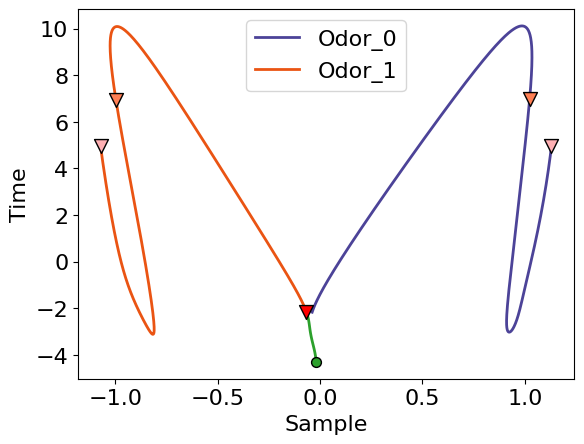

In [59]:

print(Z['sdt'].shape)
temp1 = Z['s']
temp2 = Z['t']
newdata = np.vstack((temp1, temp2))
newdata = newdata.transpose(3,1,2,0)

# Model = PCA
# pca = Model(n_components=2)
# newdata = data.T
print(newdata.shape)
NUM =90
newtrace0 = newdata[:,0,0,:]
newtrace1 = newdata[:,1,0,:]
newtrace2 = newdata[:,0,1,:]
newtrace3 = newdata[:,1,1,:]
print('newtrace0:', newtrace0.shape)
bz0 = Bezier(newtrace0, 1800)
matpi0=bz0.getBezierPoints(0)
bz1 = Bezier(newtrace1, 1800)
matpi1=bz1.getBezierPoints(0)
bz2 = Bezier(newtrace2, 1800)
matpi2=bz2.getBezierPoints(0)
bz3 = Bezier(newtrace3, 1800)
matpi3=bz3.getBezierPoints(0)


print(matpi0.shape)

fig=plt.figure()
ax = fig.gca()

plt.scatter(matpi0[0,0],matpi0[0,1], c='C2', marker='o', s=50, edgecolors='k',zorder=2)

plt.plot(matpi0[0:1800*2//3//6*1-100,0],matpi0[0:1800*2//3//6*1-100,1], color='C2', linewidth=2,zorder=1)

plt.scatter(matpi0[1800*2//3//6*1-100,0],matpi0[1800*2//3//6*1-100,1], c='#FF0000', marker='v', s=100, edgecolors='k',zorder=2)
plt.scatter(matpi0[1800*2//3//6*2,0],matpi0[1800*2//3//6*2,1], c='#ff7f54', marker='v', s=100, edgecolors='k',zorder=2)
plt.scatter(matpi1[1800*2//3//6*2,0],matpi1[1800*2//3//6*2,1], c='#ff7f54', marker='v', s=100, edgecolors='k',zorder=2)

plt.plot(matpi1[1800*2//3//6*1-100:1800*2//3//6*5,0],matpi1[1800*2//3//6*1-100:1800*2//3//6*5,1], color='#4c4398', linewidth=2,zorder=1, label='Odor_0')
plt.plot(matpi0[1800*2//3//6*1-100:1800*2//3//6*5,0],matpi0[1800*2//3//6*1-100:1800*2//3//6*5,1], color='#ea5413', linewidth=2,zorder=1, label='Odor_1')

plt.scatter(matpi0[1800*2//3//6*5,0],matpi0[1800*2//3//6*5,1], c='#ffb0b3', marker='v', s=100, edgecolors='k',zorder=2)
plt.scatter(matpi1[1800*2//3//6*5,0],matpi1[1800*2//3//6*5,1], c='#ffb0b3', marker='v', s=100, edgecolors='k',zorder=2)

plt.yticks(fontsize=16)
plt.xticks(fontsize=16)

plt.xlabel('Sample',fontsize=16)
plt.ylabel('Time',fontsize=16)

plt.legend(fontsize=16)
plt.savefig('figure/fig3c.svg')
plt.show()

#### dpca (3s) single

In [ ]:
data = data3
# abc
# trial-average data
R = np.mean(data,0)
# center data
R -= np.mean(R.reshape((N,-1)),1)[:,None,None,None]
dpca = dPCA.dPCA(labels='sdt',n_components=1,regularizer='auto',join =[{'s': ['s', 'st']}, {'d': ['d', 'dt']}, {'t'}, {'sd': ['sdt']}])
dpca.protect = ['t']
print(R.shape, data.shape)
Z = []
for i in range(data.shape[0]):
    Z.append(dpca.fit_transform(data[i],data))

##### dt (3s)

6
(1, 2, 2, 90)
(90, 2, 2, 2)
newtrace0: (90, 2)
(1802, 2)
(90, 2, 2, 2)
newtrace0: (90, 2)
(90, 2, 2, 2)
newtrace0: (90, 2)
(90, 2, 2, 2)
newtrace0: (90, 2)
(90, 2, 2, 2)
newtrace0: (90, 2)
(90, 2, 2, 2)
newtrace0: (90, 2)


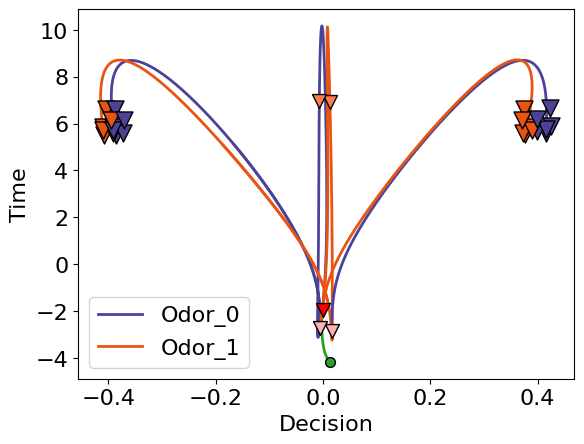

In [61]:
print(len(Z))
print(Z[0]['sdt'].shape)
temp1 = Z[0]['d']
temp2 = Z[0]['t']
newdata = np.vstack((temp1, temp2))
newdata = newdata.transpose(3,1,2,0)

# Model = PCA
# pca = Model(n_components=2)
# newdata = data.T
print(newdata.shape)
NUM =90
newtrace0 = newdata[:,0,0,:] # odor1 odor1 match
newtrace1 = newdata[:,1,0,:] # odor0 odor0 match
newtrace2 = newdata[:,0,1,:] # odor1 odor0 non-match
newtrace3 = newdata[:,1,1,:] # odor0 odor1 non-match
print('newtrace0:', newtrace0.shape)
bz0 = Bezier(newtrace0, 1800)
matpi0=bz0.getBezierPoints(0)
bz1 = Bezier(newtrace1, 1800)
matpi1=bz1.getBezierPoints(0)
bz2 = Bezier(newtrace2, 1800)
matpi2=bz2.getBezierPoints(0)
bz3 = Bezier(newtrace3, 1800)
matpi3=bz3.getBezierPoints(0)


print(matpi0.shape)

fig=plt.figure()
ax = fig.gca()

plt.scatter(matpi0[0,0],matpi0[0,1], c='C2', marker='o', s=50, edgecolors='k',zorder=2)

plt.plot(matpi0[0:1800*2//3//6*1-100,0],matpi0[0:1800*2//3//6*1-100,1], color='C2', linewidth=2,zorder=1)

plt.scatter(matpi0[1800*2//3//6*1-100,0],matpi0[1800*2//3//6*1-100,1], c='#FF0000', marker='v', s=100, edgecolors='k',zorder=2)
plt.scatter(matpi0[1800*2//3//6*2,0],matpi0[1800*2//3//6*2,1], c='#ff7f54', marker='v', s=100, edgecolors='k',zorder=2)
plt.scatter(matpi1[1800*2//3//6*2,0],matpi1[1800*2//3//6*2,1], c='#ff7f54', marker='v', s=100, edgecolors='k',zorder=2)

plt.plot(matpi1[1800*2//3//6*1-100:1800*2//3//6*5,0],matpi1[1800*2//3//6*1-100:1800*2//3//6*5,1], color='#4c4398', linewidth=2,zorder=1)
plt.plot(matpi0[1800*2//3//6*1-100:1800*2//3//6*5,0],matpi0[1800*2//3//6*1-100:1800*2//3//6*5,1], color='#ea5413', linewidth=2,zorder=1)

plt.scatter(matpi0[1800*2//3//6*5-280,0],matpi0[1800*2//3//6*5-280,1], c='#ffb0b3', marker='v', s=100, edgecolors='k',zorder=2)
plt.scatter(matpi1[1800*2//3//6*5-280,0],matpi1[1800*2//3//6*5-280,1], c='#ffb0b3', marker='v', s=100, edgecolors='k',zorder=2)

plt.plot(matpi1[1800*2//3//6*5-200:1800*2//3//6*6,0],matpi1[1800*2//3//6*5-200:1800*2//3//6*6,1], color='#4c4398', linewidth=2, label='Odor_0',zorder=1)
plt.plot(matpi0[1800*2//3//6*5-200:1800*2//3//6*6,0],matpi0[1800*2//3//6*5-200:1800*2//3//6*6,1], color='#ea5413', linewidth=2, label='Odor_1',zorder=1)

plt.plot(matpi2[1800*2//3//6*5-250:1800*2//3//6*6,0],matpi2[1800*2//3//6*5-250:1800*2//3//6*6,1], color='#4c4398', linewidth=2,zorder=1)
plt.plot(matpi3[1800*2//3//6*5-250:1800*2//3//6*6,0],matpi3[1800*2//3//6*5-250:1800*2//3//6*6,1], color='#ea5413', linewidth=2,zorder=1)

plt.scatter(matpi0[1800*2//3//6*6,0],matpi0[1800*2//3//6*6,1], c='#ea5413', marker='v', s=150, edgecolors='k',zorder=2)
plt.scatter(matpi1[1800*2//3//6*6,0],matpi1[1800*2//3//6*6,1], c='#4c4398', marker='v', s=150, edgecolors='k',zorder=2)
plt.scatter(matpi2[1800*2//3//6*6,0],matpi2[1800*2//3//6*6,1], c='#4c4398', marker='v', s=150, edgecolors='k',zorder=2)
plt.scatter(matpi3[1800*2//3//6*6,0],matpi3[1800*2//3//6*6,1], c='#ea5413', marker='v', s=150, edgecolors='k',zorder=2)

for i in range(1, len(Z)):
    temp1 = Z[i]['d']
    temp2 = Z[i]['t']
    newdata = np.vstack((temp1, temp2))
    newdata = newdata.transpose(3,1,2,0)

    # Model = PCA
    # pca = Model(n_components=2)
    # newdata = data.T
    print(newdata.shape)
    NUM =90
    newtrace0 = newdata[:,0,0,:] # odor1 odor1 match
    newtrace1 = newdata[:,1,0,:] # odor0 odor0 match
    newtrace2 = newdata[:,0,1,:] # odor1 odor0 non-match
    newtrace3 = newdata[:,1,1,:] # odor0 odor1 non-match
    print('newtrace0:', newtrace0.shape)
    bz0 = Bezier(newtrace0, 1800)
    matpi0=bz0.getBezierPoints(0)
    bz1 = Bezier(newtrace1, 1800)
    matpi1=bz1.getBezierPoints(0)
    bz2 = Bezier(newtrace2, 1800)
    matpi2=bz2.getBezierPoints(0)
    bz3 = Bezier(newtrace3, 1800)
    matpi3=bz3.getBezierPoints(0)

    plt.scatter(matpi0[1800*2//3//6*6,0],matpi0[1800*2//3//6*6,1], c='#ea5413', marker='v', s=150, edgecolors='k',zorder=2)
    plt.scatter(matpi1[1800*2//3//6*6,0],matpi1[1800*2//3//6*6,1], c='#4c4398', marker='v', s=150, edgecolors='k',zorder=2)
    plt.scatter(matpi2[1800*2//3//6*6,0],matpi2[1800*2//3//6*6,1], c='#4c4398', marker='v', s=150, edgecolors='k',zorder=2)
    plt.scatter(matpi3[1800*2//3//6*6,0],matpi3[1800*2//3//6*6,1], c='#ea5413', marker='v', s=150, edgecolors='k',zorder=2)

plt.yticks(fontsize=16)
plt.xticks(fontsize=16)

plt.xlabel('Decision',fontsize=16)
plt.ylabel('Time',fontsize=16)

plt.legend(fontsize=16)
plt.savefig('figure/suppfig2_1.svg')
plt.show()

##### sd (3s)

(1, 2, 2, 90)
(90, 2, 2, 2)
newtrace0: (90, 2)
(1802, 2)
(90, 2, 2, 2)
newtrace0: (90, 2)
(90, 2, 2, 2)
newtrace0: (90, 2)
(90, 2, 2, 2)
newtrace0: (90, 2)
(90, 2, 2, 2)
newtrace0: (90, 2)
(90, 2, 2, 2)
newtrace0: (90, 2)


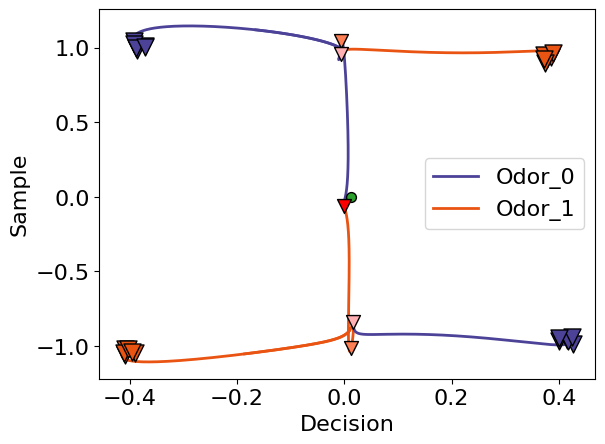

In [11]:
print(Z[0]['sdt'].shape)
temp1 = Z[0]['s']
temp2 = Z[0]['d']
newdata = np.vstack((temp1, temp2))
newdata = newdata.transpose(3,1,2,0)

# Model = PCA
# pca = Model(n_components=2)
# newdata = data.T
print(newdata.shape)
NUM =90
newtrace0 = newdata[:,0,0,:]
newtrace1 = newdata[:,1,0,:]
newtrace2 = newdata[:,0,1,:]
newtrace3 = newdata[:,1,1,:]
print('newtrace0:', newtrace0.shape)
bz0 = Bezier(newtrace0, 1800)
matpi0=bz0.getBezierPoints(0)
bz1 = Bezier(newtrace1, 1800)
matpi1=bz1.getBezierPoints(0)
bz2 = Bezier(newtrace2, 1800)
matpi2=bz2.getBezierPoints(0)
bz3 = Bezier(newtrace3, 1800)
matpi3=bz3.getBezierPoints(0)

matpi0 = matpi0[:,[1,0]]
matpi1 = matpi1[:,[1,0]]
matpi2 = matpi2[:,[1,0]]
matpi3 = matpi3[:,[1,0]]

print(matpi0.shape)

fig=plt.figure()
ax = fig.gca()

plt.scatter(matpi0[0,0],matpi0[0,1], c='C2', marker='o', s=50, edgecolors='k',zorder=2)

plt.plot(matpi0[0:1800*2//3//6*1-100,0],matpi0[0:1800*2//3//6*1-100,1], color='C2', linewidth=2,zorder=1)

plt.scatter(matpi0[1800*2//3//6*1-100,0],matpi0[1800*2//3//6*1-100,1], c='#FF0000', marker='v', s=100, edgecolors='k',zorder=2)
plt.scatter(matpi0[1800*2//3//6*2,0],matpi0[1800*2//3//6*2,1], c='#ff7f54', marker='v', s=100, edgecolors='k',zorder=2)
plt.scatter(matpi1[1800*2//3//6*2,0],matpi1[1800*2//3//6*2,1], c='#ff7f54', marker='v', s=100, edgecolors='k',zorder=2)

plt.plot(matpi1[1800*2//3//6*1-100:1800*2//3//6*5,0],matpi1[1800*2//3//6*1-100:1800*2//3//6*5,1], color='#4c4398', linewidth=2,zorder=1)
plt.plot(matpi0[1800*2//3//6*1-100:1800*2//3//6*5,0],matpi0[1800*2//3//6*1-100:1800*2//3//6*5,1], color='#ea5413', linewidth=2,zorder=1)

plt.scatter(matpi0[1800*2//3//6*5-280,0],matpi0[1800*2//3//6*5-280,1], c='#ffb0b3', marker='v', s=100, edgecolors='k',zorder=2)
plt.scatter(matpi1[1800*2//3//6*5-280,0],matpi1[1800*2//3//6*5-280,1], c='#ffb0b3', marker='v', s=100, edgecolors='k',zorder=2)

plt.plot(matpi1[1800*2//3//6*5-200:1800*2//3//6*6,0],matpi1[1800*2//3//6*5-200:1800*2//3//6*6,1], color='#4c4398', linewidth=2, label='Odor_0',zorder=1)
plt.plot(matpi0[1800*2//3//6*5-200:1800*2//3//6*6,0],matpi0[1800*2//3//6*5-200:1800*2//3//6*6,1], color='#ea5413', linewidth=2, label='Odor_1',zorder=1)

plt.plot(matpi2[1800*2//3//6*5-250:1800*2//3//6*6,0],matpi2[1800*2//3//6*5-250:1800*2//3//6*6,1], color='#4c4398', linewidth=2,zorder=1)
plt.plot(matpi3[1800*2//3//6*5-250:1800*2//3//6*6,0],matpi3[1800*2//3//6*5-250:1800*2//3//6*6,1], color='#ea5413', linewidth=2,zorder=1)

plt.scatter(matpi0[1800*2//3//6*6,0],matpi0[1800*2//3//6*6,1], c='#ea5413', marker='v', s=150, edgecolors='k',zorder=2)
plt.scatter(matpi1[1800*2//3//6*6,0],matpi1[1800*2//3//6*6,1], c='#4c4398', marker='v', s=150, edgecolors='k',zorder=2)
plt.scatter(matpi2[1800*2//3//6*6,0],matpi2[1800*2//3//6*6,1], c='#4c4398', marker='v', s=150, edgecolors='k',zorder=2)
plt.scatter(matpi3[1800*2//3//6*6,0],matpi3[1800*2//3//6*6,1], c='#ea5413', marker='v', s=150, edgecolors='k',zorder=2)

for i in range(1, len(Z)):
    temp1 = Z[i]['s']
    temp2 = Z[i]['d']
    newdata = np.vstack((temp1, temp2))
    newdata = newdata.transpose(3,1,2,0)

    # Model = PCA
    # pca = Model(n_components=2)
    # newdata = data.T
    print(newdata.shape)
    NUM =90
    newtrace0 = newdata[:,0,0,:] # odor1 odor1 match
    newtrace1 = newdata[:,1,0,:] # odor0 odor0 match
    newtrace2 = newdata[:,0,1,:] # odor1 odor0 non-match
    newtrace3 = newdata[:,1,1,:] # odor0 odor1 non-match
    print('newtrace0:', newtrace0.shape)
    bz0 = Bezier(newtrace0, 1800)
    matpi0=bz0.getBezierPoints(0)
    bz1 = Bezier(newtrace1, 1800)
    matpi1=bz1.getBezierPoints(0)
    bz2 = Bezier(newtrace2, 1800)
    matpi2=bz2.getBezierPoints(0)
    bz3 = Bezier(newtrace3, 1800)
    matpi3=bz3.getBezierPoints(0)

    matpi0 = matpi0[:,[1,0]]
    matpi1 = matpi1[:,[1,0]]
    matpi2 = matpi2[:,[1,0]]
    matpi3 = matpi3[:,[1,0]]

    plt.scatter(matpi0[1800*2//3//6*6,0],matpi0[1800*2//3//6*6,1], c='#ea5413', marker='v', s=150, edgecolors='k',zorder=2)
    plt.scatter(matpi1[1800*2//3//6*6,0],matpi1[1800*2//3//6*6,1], c='#4c4398', marker='v', s=150, edgecolors='k',zorder=2)
    plt.scatter(matpi2[1800*2//3//6*6,0],matpi2[1800*2//3//6*6,1], c='#4c4398', marker='v', s=150, edgecolors='k',zorder=2)
    plt.scatter(matpi3[1800*2//3//6*6,0],matpi3[1800*2//3//6*6,1], c='#ea5413', marker='v', s=150, edgecolors='k',zorder=2)

plt.yticks(fontsize=16)
plt.xticks(fontsize=16)

plt.xlabel('Decision',fontsize=16)
plt.ylabel('Sample',fontsize=16)

plt.legend(fontsize=16)
plt.savefig('figure/suppfig2_2.svg')
plt.show()

#### dpca (6s) mean

In [ ]:
data = data6
# abc
# trial-average data
R = np.mean(data,0)
# center data
R -= np.mean(R.reshape((N,-1)),1)[:,None,None,None]
dpca = dPCA.dPCA(labels='sdt',n_components=1,regularizer='auto',join =[{'s': ['s', 'st']}, {'d': ['d', 'dt']}, {'t'}, {'sd': ['sdt']}])
dpca.protect = ['t']
print(R.shape, data.shape)
Z6 = dpca.fit_transform(R,data)

##### st (6s)

(1, 2, 2, 90)
(90, 2, 2, 2)
newtrace0: (90, 2)
(1802, 2)


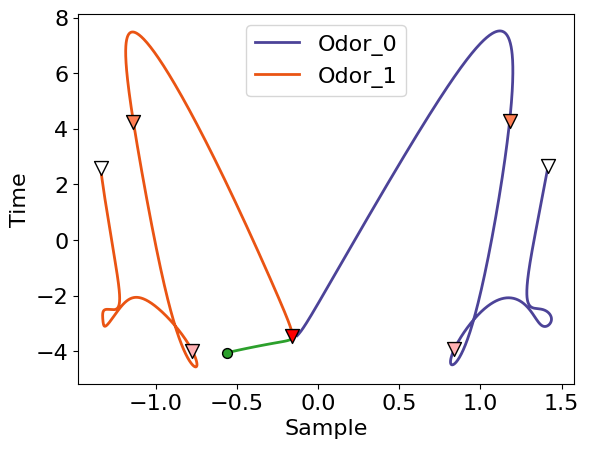

In [65]:

print(Z6['sdt'].shape)
temp1 = Z6['s']
temp2 = Z6['t']
newdata = np.vstack((temp1, temp2))
newdata = newdata.transpose(3,1,2,0)

# Model = PCA
# pca = Model(n_components=2)
# newdata = data.T
print(newdata.shape)
NUM =90
newtrace0 = newdata[:,0,0,:] # odor1 odor1 match
newtrace1 = newdata[:,1,0,:] # odor0 odor0 match
newtrace2 = newdata[:,0,1,:] # odor1 odor0 non-match
newtrace3 = newdata[:,1,1,:] # odor0 odor1 non-match
print('newtrace0:', newtrace0.shape)
bz0 = Bezier(newtrace0, 1800)
matpi0=bz0.getBezierPoints(0)
bz1 = Bezier(newtrace1, 1800)
matpi1=bz1.getBezierPoints(0)
bz2 = Bezier(newtrace2, 1800)
matpi2=bz2.getBezierPoints(0)
bz3 = Bezier(newtrace3, 1800)
matpi3=bz3.getBezierPoints(0)


print(matpi0.shape)

fig=plt.figure()
ax = fig.gca()

plt.scatter(matpi0[0,0],matpi0[0,1], c='C2', marker='o', s=50, edgecolors='k',zorder=2)

plt.plot(matpi0[0:1800//9*1-100,0],matpi0[0:1800//9*1-100,1], color='C2', linewidth=2,zorder=1)

plt.scatter(matpi0[1800//9*1-100,0],matpi0[1800//9*1-100,1], c='#FF0000', marker='v', s=100, edgecolors='k',zorder=2)
plt.scatter(matpi0[1800//9*2,0],matpi0[1800//9*2,1], c='#ff7f54', marker='v', s=100, edgecolors='k',zorder=2)
plt.scatter(matpi1[1800//9*2,0],matpi1[1800//9*2,1], c='#ff7f54', marker='v', s=100, edgecolors='k',zorder=2)

plt.plot(matpi1[1800//9*1-100:1800//9*8,0],matpi1[1800//9*1-100:1800//9*8,1], color='#4c4398', linewidth=2,zorder=1,label="Odor_0")
plt.plot(matpi0[1800//9*1-100:1800//9*8,0],matpi0[1800//9*1-100:1800//9*8,1], color='#ea5413', linewidth=2,zorder=1,label="Odor_1")

plt.scatter(matpi0[1800//9*5-280,0],matpi0[1800//9*5-280,1], c='#ffb0b3', marker='v', s=100, edgecolors='k',zorder=2)
plt.scatter(matpi1[1800//9*5-280,0],matpi1[1800//9*5-280,1], c='#ffb0b3', marker='v', s=100, edgecolors='k',zorder=2)

plt.scatter(matpi0[1800//9*8,0],matpi0[1800//9*8,1], c='#FFFFFF', marker='v', s=100, edgecolors='k',zorder=2)
plt.scatter(matpi1[1800//9*8,0],matpi1[1800//9*8,1], c='#FFFFFF', marker='v', s=100, edgecolors='k',zorder=2)

plt.yticks(fontsize=16)
plt.xticks(fontsize=16)

plt.xlabel('Sample',fontsize=16)
plt.ylabel('Time',fontsize=16)

plt.legend(fontsize=16)
plt.savefig('figure/fig3c.svg')
plt.show()

#### dpca (6s) single

In [12]:
data = data6
# abc
# trial-average data
R = np.mean(data,0)
# center data
R -= np.mean(R.reshape((N,-1)),1)[:,None,None,None]
dpca = dPCA.dPCA(labels='sdt',n_components=1,regularizer='auto',join =[{'s': ['s', 'st']}, {'d': ['d', 'dt']}, {'t'}, {'sd': ['sdt']}])
dpca.protect = ['t']
print(R.shape, data.shape)
Z6 = []
for i in range(data.shape[0]):
    Z6.append(dpca.fit_transform(data[i],data))

You chose to determine the regularization parameter automatically. This can
                    take substantial time and grows linearly with the number of crossvalidation
                    folds. The latter can be set by changing self.n_trials (default = 3). Similarly,
                    use self.protect to set the list of axes that are not supposed to get to get shuffled
                    (e.g. upon splitting the data into test- and training, time-points should always
                    be drawn from the same trial, i.e. self.protect = ['t']). This can significantly
                    speed up the code.
(600, 2, 2, 90) (6, 600, 2, 2, 90)
Start optimizing regularization.
Starting trial  1 / 3
Starting trial  2 / 3
Starting trial  3 / 3
Optimized regularization, optimal lambda =  8.366825542528468e-05
Regularization will be fixed; to compute the optimal                    parameter again on the next fit, please                    set opt_regularizer_flag to True.


##### dt (6s)

(1, 2, 2, 90)
(90, 2, 2, 2)
newtrace0: (90, 2)
(1802, 2)
(90, 2, 2, 2)
newtrace0: (90, 2)
(90, 2, 2, 2)
newtrace0: (90, 2)
(90, 2, 2, 2)
newtrace0: (90, 2)
(90, 2, 2, 2)
newtrace0: (90, 2)
(90, 2, 2, 2)
newtrace0: (90, 2)


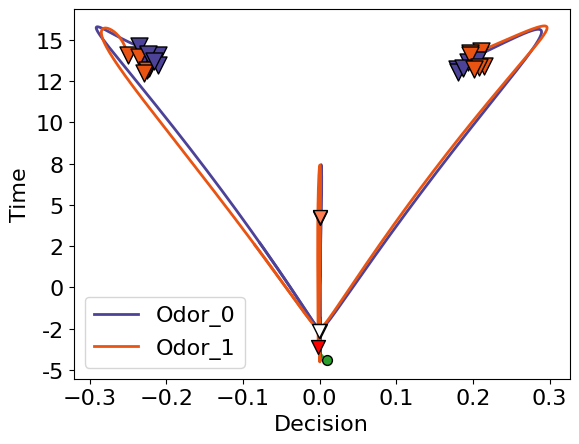

In [81]:
print(Z6[0]['sdt'].shape)
temp1 = Z6[0]['d']
temp2 = Z6[0]['t']
newdata = np.vstack((temp1, temp2))
newdata = newdata.transpose(3,1,2,0)

# Model = PCA
# pca = Model(n_components=2)
# newdata = data.T
print(newdata.shape)
NUM =90
newtrace0 = newdata[:,0,0,:] # odor1 odor1 match
newtrace1 = newdata[:,1,0,:] # odor0 odor0 match
newtrace2 = newdata[:,0,1,:] # odor1 odor0 non-match
newtrace3 = newdata[:,1,1,:] # odor0 odor1 non-match
print('newtrace0:', newtrace0.shape)
bz0 = Bezier(newtrace0, 1800)
matpi0=bz0.getBezierPoints(0)
bz1 = Bezier(newtrace1, 1800)
matpi1=bz1.getBezierPoints(0)
bz2 = Bezier(newtrace2, 1800)
matpi2=bz2.getBezierPoints(0)
bz3 = Bezier(newtrace3, 1800)
matpi3=bz3.getBezierPoints(0)


print(matpi0.shape)

fig=plt.figure()
ax = fig.gca()

plt.scatter(matpi0[0,0],matpi0[0,1], c='C2', marker='o', s=50, edgecolors='k',zorder=2)

plt.plot(matpi0[0:1800//9*1-100,0],matpi0[0:1800//9*1-100,1], color='C2', linewidth=2,zorder=1)

plt.scatter(matpi0[1800//9*1-100,0],matpi0[1800//9*1-100,1], c='#FF0000', marker='v', s=100, edgecolors='k',zorder=2)
plt.scatter(matpi0[1800//9*2,0],matpi0[1800//9*2,1], c='#ff7f54', marker='v', s=100, edgecolors='k',zorder=2)
plt.scatter(matpi1[1800//9*2,0],matpi1[1800//9*2,1], c='#ff7f54', marker='v', s=100, edgecolors='k',zorder=2)

plt.plot(matpi1[1800//9*1-100:1800//9*8,0],matpi1[1800//9*1-100:1800//9*8,1], color='#4c4398', linewidth=2,zorder=1)
plt.plot(matpi0[1800//9*1-100:1800//9*8,0],matpi0[1800//9*1-100:1800//9*8,1], color='#ea5413', linewidth=2,zorder=1)

plt.plot(matpi1[1800//9*8-200:1800//9*9,0],matpi1[1800//9*8-200:1800//9*9,1], color='#4c4398', linewidth=2, label='Odor_0',zorder=1)
plt.plot(matpi0[1800//9*8-200:1800//9*9,0],matpi0[1800//9*8-200:1800//9*9,1], color='#ea5413', linewidth=2, label='Odor_1',zorder=1)

plt.plot(matpi2[1800//9*8-250:1800//9*9,0],matpi2[1800//9*8-250:1800//9*9,1], color='#4c4398', linewidth=2,zorder=1)
plt.plot(matpi3[1800//9*8-250:1800//9*9,0],matpi3[1800//9*8-250:1800//9*9,1], color='#ea5413', linewidth=2,zorder=1)

plt.scatter(matpi0[1800//9*8-200,0],matpi0[1800//9*8-200,1], c='#FFFFFF', marker='v', s=100, edgecolors='k',zorder=2)
plt.scatter(matpi1[1800//9*8-200,0],matpi1[1800//9*8-200,1], c='#FFFFFF', marker='v', s=100, edgecolors='k',zorder=2)
plt.scatter(matpi0[1800//9*9,0],matpi0[1800//9*9,1], c='#ea5413', marker='v', s=150, edgecolors='k',zorder=2)
plt.scatter(matpi1[1800//9*9,0],matpi1[1800//9*9,1], c='#4c4398', marker='v', s=150, edgecolors='k',zorder=2)
plt.scatter(matpi2[1800//9*9,0],matpi2[1800//9*9,1], c='#4c4398', marker='v', s=150, edgecolors='k',zorder=2)
plt.scatter(matpi3[1800//9*9,0],matpi3[1800//9*9,1], c='#ea5413', marker='v', s=150, edgecolors='k',zorder=2)

for i in range(1, len(Z6)):
    temp1 = Z6[i]['d']
    temp2 = Z6[i]['t']
    newdata = np.vstack((temp1, temp2))
    newdata = newdata.transpose(3,1,2,0)

    # Model = PCA
    # pca = Model(n_components=2)
    # newdata = data.T
    print(newdata.shape)
    NUM =90
    newtrace0 = newdata[:,0,0,:] # odor1 odor1 match
    newtrace1 = newdata[:,1,0,:] # odor0 odor0 match
    newtrace2 = newdata[:,0,1,:] # odor1 odor0 non-match
    newtrace3 = newdata[:,1,1,:] # odor0 odor1 non-match
    print('newtrace0:', newtrace0.shape)
    bz0 = Bezier(newtrace0, 1800)
    matpi0=bz0.getBezierPoints(0)
    bz1 = Bezier(newtrace1, 1800)
    matpi1=bz1.getBezierPoints(0)
    bz2 = Bezier(newtrace2, 1800)
    matpi2=bz2.getBezierPoints(0)
    bz3 = Bezier(newtrace3, 1800)
    matpi3=bz3.getBezierPoints(0)

    plt.scatter(matpi0[1800//9*9,0],matpi0[1800//9*9,1], c='#ea5413', marker='v', s=150, edgecolors='k',zorder=2)
    plt.scatter(matpi1[1800//9*9,0],matpi1[1800//9*9,1], c='#4c4398', marker='v', s=150, edgecolors='k',zorder=2)
    plt.scatter(matpi2[1800//9*9,0],matpi2[1800//9*9,1], c='#4c4398', marker='v', s=150, edgecolors='k',zorder=2)
    plt.scatter(matpi3[1800//9*9,0],matpi3[1800//9*9,1], c='#ea5413', marker='v', s=150, edgecolors='k',zorder=2)

plt.yticks(fontsize=16)
plt.xticks(fontsize=16)

plt.xlabel('Decision',fontsize=16)
plt.ylabel('Time',fontsize=16)
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter("%.0f"))
plt.legend(fontsize=16)
plt.savefig('figure/suppfig2_3.svg')
plt.show()

##### sd (6s)

In [13]:
print(Z6[0]['sdt'].shape)
temp1 = Z6[0]['s']
temp2 = Z6[0]['d']
newdata = np.vstack((temp1, temp2))
newdata = newdata.transpose(3,1,2,0)

# Model = PCA
# pca = Model(n_components=2)
# newdata = data.T
print(newdata.shape)
NUM =90
newtrace0 = newdata[:,0,0,:] # odor1 odor1 match
newtrace1 = newdata[:,1,0,:] # odor0 odor0 match
newtrace2 = newdata[:,0,1,:] # odor1 odor0 non-match
newtrace3 = newdata[:,1,1,:] # odor0 odor1 non-match
print('newtrace0:', newtrace0.shape)
bz0 = Bezier(newtrace0, 1800)
matpi0=bz0.getBezierPoints(0)
bz1 = Bezier(newtrace1, 1800)
matpi1=bz1.getBezierPoints(0)
bz2 = Bezier(newtrace2, 1800)
matpi2=bz2.getBezierPoints(0)
bz3 = Bezier(newtrace3, 1800)
matpi3=bz3.getBezierPoints(0)

matpi0 = matpi0[:,[1,0]]
matpi1 = matpi1[:,[1,0]]
matpi2 = matpi2[:,[1,0]]
matpi3 = matpi3[:,[1,0]]

print(matpi0.shape)

fig=plt.figure()
ax = fig.gca()

plt.scatter(matpi0[0,0],matpi0[0,1], c='C2', marker='o', s=50, edgecolors='k',zorder=2)

plt.plot(matpi0[0:1800//9*1-100,0],matpi0[0:1800//9*1-100,1], color='C2', linewidth=2,zorder=1)

plt.scatter(matpi0[1800//9*1-100,0],matpi0[1800//9*1-100,1], c='#FF0000', marker='v', s=100, edgecolors='k',zorder=2)
plt.scatter(matpi0[1800//9*2,0],matpi0[1800//9*2,1], c='#ff7f54', marker='v', s=100, edgecolors='k',zorder=2)
plt.scatter(matpi1[1800//9*2,0],matpi1[1800//9*2,1], c='#ff7f54', marker='v', s=100, edgecolors='k',zorder=2)

plt.plot(matpi1[1800//9*1-100:1800//9*8,0],matpi1[1800//9*1-100:1800//9*8,1], color='#4c4398', linewidth=2,zorder=1)
plt.plot(matpi0[1800//9*1-100:1800//9*8,0],matpi0[1800//9*1-100:1800//9*8,1], color='#ea5413', linewidth=2,zorder=1)

plt.plot(matpi1[1800//9*8-200:1800//9*9,0],matpi1[1800//9*8-200:1800//9*9,1], color='#4c4398', linewidth=2, label='Odor_0',zorder=1)
plt.plot(matpi0[1800//9*8-200:1800//9*9,0],matpi0[1800//9*8-200:1800//9*9,1], color='#ea5413', linewidth=2, label='Odor_1',zorder=1)

plt.plot(matpi2[1800//9*8-250:1800//9*9,0],matpi2[1800//9*8-250:1800//9*9,1], color='#4c4398', linewidth=2,zorder=1)
plt.plot(matpi3[1800//9*8-250:1800//9*9,0],matpi3[1800//9*8-250:1800//9*9,1], color='#ea5413', linewidth=2,zorder=1)

plt.scatter(matpi0[1800//9*8-200,0],matpi0[1800//9*8-200,1], c='#FFFFFF', marker='v', s=100, edgecolors='k',zorder=2)
plt.scatter(matpi1[1800//9*8-200,0],matpi1[1800//9*8-200,1], c='#FFFFFF', marker='v', s=100, edgecolors='k',zorder=2)
plt.scatter(matpi0[1800//9*9,0],matpi0[1800//9*9,1], c='#ea5413', marker='v', s=150, edgecolors='k',zorder=2)
plt.scatter(matpi1[1800//9*9,0],matpi1[1800//9*9,1], c='#4c4398', marker='v', s=150, edgecolors='k',zorder=2)
plt.scatter(matpi2[1800//9*9,0],matpi2[1800//9*9,1], c='#4c4398', marker='v', s=150, edgecolors='k',zorder=2)
plt.scatter(matpi3[1800//9*9,0],matpi3[1800//9*9,1], c='#ea5413', marker='v', s=150, edgecolors='k',zorder=2)

for i in range(1, len(Z6)):
    temp1 = Z6[i]['s']
    temp2 = Z6[i]['d']
    newdata = np.vstack((temp1, temp2))
    newdata = newdata.transpose(3,1,2,0)

    # Model = PCA
    # pca = Model(n_components=2)
    # newdata = data.T
    print(newdata.shape)
    NUM =90
    newtrace0 = newdata[:,0,0,:] # odor1 odor1 match
    newtrace1 = newdata[:,1,0,:] # odor0 odor0 match
    newtrace2 = newdata[:,0,1,:] # odor1 odor0 non-match
    newtrace3 = newdata[:,1,1,:] # odor0 odor1 non-match
    print('newtrace0:', newtrace0.shape)
    bz0 = Bezier(newtrace0, 1800)
    matpi0=bz0.getBezierPoints(0)
    bz1 = Bezier(newtrace1, 1800)
    matpi1=bz1.getBezierPoints(0)
    bz2 = Bezier(newtrace2, 1800)
    matpi2=bz2.getBezierPoints(0)
    bz3 = Bezier(newtrace3, 1800)
    matpi3=bz3.getBezierPoints(0)

    matpi0 = matpi0[:,[1,0]]
    matpi1 = matpi1[:,[1,0]]
    matpi2 = matpi2[:,[1,0]]
    matpi3 = matpi3[:,[1,0]]

    plt.scatter(matpi0[1800//9*9,0],matpi0[1800//9*9,1], c='#ea5413', marker='v', s=150, edgecolors='k',zorder=2)
    plt.scatter(matpi1[1800//9*9,0],matpi1[1800//9*9,1], c='#4c4398', marker='v', s=150, edgecolors='k',zorder=2)
    plt.scatter(matpi2[1800//9*9,0],matpi2[1800//9*9,1], c='#4c4398', marker='v', s=150, edgecolors='k',zorder=2)
    plt.scatter(matpi3[1800//9*9,0],matpi3[1800//9*9,1], c='#ea5413', marker='v', s=150, edgecolors='k',zorder=2)
    
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)

plt.xlabel('Decision',fontsize=16)
plt.ylabel('Sample',fontsize=16)

plt.legend(fontsize=16)
plt.savefig('figure/suppfig2_4.svg')
plt.show()

(1, 2, 2, 90)
(90, 2, 2, 2)
newtrace0: (90, 2)


(1802, 2)
(90, 2, 2, 2)
newtrace0: (90, 2)
(90, 2, 2, 2)
newtrace0: (90, 2)
(90, 2, 2, 2)
newtrace0: (90, 2)
(90, 2, 2, 2)
newtrace0: (90, 2)
(90, 2, 2, 2)
newtrace0: (90, 2)


## 9 TI

Sparsity: 0.9679166666666666
2.618766 -2.7255585
True
(1.401, 2.8239913927299654, 0.5755154588645874, 0.5886556169501057, 1.164, 0.3012603828794096, 0.2366255144032922)
10.317278 0.0
True


True
(1.867, 3.63262459353182, 0.7403109001009482, 0.680096006363022, 1.42, 0.4267619049897312, 0.44693877551020406)
5.0805693 0.0
True


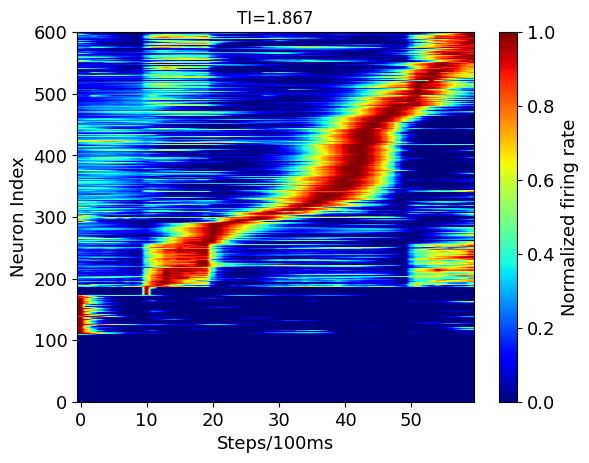

True
(1.955, 3.958008163084136, 0.8066224599803395, 0.6965992962004468, 1.503, 0.4205259574819901, 0.4517453798767967)
4.3882513 0.0
True


In [99]:
netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/max_delay_3000_delay_3_seed_0_L20.01_m0.0'
results = pickle.load(open(netdir+'.pkl', 'rb'))['hidden_act'][-1][:,0,:]
import sys
sys.path.insert(0, "/home/jiashuncheng/code/Trasient/ODPA/")
from model_torch import Model
A = torch.load(netdir+'.pth').w_rnn.cpu().detach().numpy()
print("Sparsity:", A.nonzero()[0].shape[0]/(A.shape[0]*A.shape[1]))
print(A.max(), A.min())
hidden_act = results.T
# print(pickle.load(open(netdir, 'rb'))['m'][-1])
data0 = hidden_act
print(cal_TI(results,20,50))
newdata0 = data0.copy()
data0 = normalization1(data0)
B_mylstm= sorting(data0)
data0 = data0[B_mylstm,:]
fig=plt.imshow(data0, aspect='auto',cmap='jet')
# plt.vlines(x=10,ymin=0,ymax=600,linewidth=2,color='white')
# plt.vlines(x=20,ymin=0,ymax=600,linewidth=2,color='white')
# plt.vlines(x=50,ymin=0,ymax=600,linewidth=2,color='white')
plt.xlabel('Steps/100ms', fontsize=13)
plt.gca().invert_yaxis()
plt.ylabel('Neuron Index', fontsize=13)
plt.title('TI={}'.format(cal_TI(results,20,50)[0]))
font = {"size":13}
cb = plt.colorbar(fig)
cb.set_label('Normalized firing rate',fontdict=font)
cb.set_ticks([0,0.2,0.4,0.6,0.8,1])
cb.ax.tick_params(labelsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylim(0,600)
# plt.savefig('figure/fig3a1.svg')
plt.show()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/max_delay_3000_delay_3_seed_0_L20.01_m0.1.pkl'
results = pickle.load(open(netdir, 'rb'))['hidden_act'][-1][:,0,:]
hidden_act = results.T
# print(pickle.load(open(netdir, 'rb'))['m'][-1])
data0 = hidden_act
print(cal_TI(results,20,50))
newdata0 = data0.copy()
data0 = normalization1(data0)
B_mylstm= sorting(data0)
data0 = data0[B_mylstm,:]
fig=plt.imshow(data0, aspect='auto',cmap='jet')
# plt.vlines(x=10,ymin=0,ymax=600,linewidth=2,color='white')
# plt.vlines(x=20,ymin=0,ymax=600,linewidth=2,color='white')
# plt.vlines(x=50,ymin=0,ymax=600,linewidth=2,color='white')
plt.xlabel('Steps/100ms', fontsize=13)
plt.gca().invert_yaxis()
plt.ylabel('Neuron Index', fontsize=13)
plt.title('TI={}'.format(cal_TI(results,20,50)[0]))
font = {"size":13}
cb = plt.colorbar(fig)
cb.set_label('Normalized firing rate',fontdict=font)
cb.set_ticks([0,0.2,0.4,0.6,0.8,1])
cb.ax.tick_params(labelsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylim(0,600)
# plt.savefig('figure/fig3a1.svg')
plt.show()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/max_delay_3000_delay_3_seed_0_L20.01_m0.2.pkl'
results = pickle.load(open(netdir, 'rb'))['hidden_act'][-1][:,0,:]
hidden_act = results.T
# print(pickle.load(open(netdir, 'rb'))['m'][-1])
data0 = hidden_act
print(cal_TI(results,20,50))
newdata0 = data0.copy()
data0 = normalization1(data0)
B_mylstm= sorting(data0)
data0 = data0[B_mylstm,:]
fig=plt.imshow(data0, aspect='auto',cmap='jet')
# plt.vlines(x=10,ymin=0,ymax=600,linewidth=2,color='white')
# plt.vlines(x=20,ymin=0,ymax=600,linewidth=2,color='white')
# plt.vlines(x=50,ymin=0,ymax=600,linewidth=2,color='white')
plt.xlabel('Steps/100ms', fontsize=13)
plt.gca().invert_yaxis()
plt.ylabel('Neuron Index', fontsize=13)
plt.title('TI={}'.format(cal_TI(results,20,50)[0]))
font = {"size":13}
cb = plt.colorbar(fig)
cb.set_label('Normalized firing rate',fontdict=font)
cb.set_ticks([0,0.2,0.4,0.6,0.8,1])
cb.ax.tick_params(labelsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylim(0,600)
# plt.savefig('figure/fig3a1.svg')
plt.show()

In [100]:
netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/max_delay_3000_delay_3_seed_0_L20.1_m0.0.pkl'
print(len(pickle.load(open(netdir, 'rb'))['hidden_act']))
results = pickle.load(open(netdir, 'rb'))['hidden_act'][-1][:,0,:]
hidden_act = results.T
# print(pickle.load(open(netdir, 'rb'))['m'][-1])
data0 = hidden_act
print(cal_TI(results,20,50))
newdata0 = data0.copy()
data0 = normalization1(data0)
B_mylstm= sorting(data0)
data0 = data0[B_mylstm,:]
fig=plt.imshow(data0, aspect='auto',cmap='jet')
# plt.vlines(x=10,ymin=0,ymax=600,linewidth=2,color='white')
# plt.vlines(x=20,ymin=0,ymax=600,linewidth=2,color='white')
# plt.vlines(x=50,ymin=0,ymax=600,linewidth=2,color='white')
plt.xlabel('Steps/100ms', fontsize=13)
plt.gca().invert_yaxis()
plt.ylabel('Neuron Index', fontsize=13)
plt.title('TI={}'.format(cal_TI(results,20,50)[0]))
font = {"size":13}
cb = plt.colorbar(fig)
cb.set_label('Normalized firing rate',fontdict=font)
cb.set_ticks([0,0.2,0.4,0.6,0.8,1])
cb.ax.tick_params(labelsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylim(0,600)
# plt.savefig('figure/fig3a1.svg')
plt.show()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/max_delay_3000_delay_3_seed_0_L20.1_m0.1.pkl'
print(len(pickle.load(open(netdir, 'rb'))['hidden_act']))
results = pickle.load(open(netdir, 'rb'))['hidden_act'][-1][:,0,:]
hidden_act = results.T
# print(pickle.load(open(netdir, 'rb'))['m'][-1])
data0 = hidden_act
print(cal_TI(results,20,50))
newdata0 = data0.copy()
data0 = normalization1(data0)
B_mylstm= sorting(data0)
data0 = data0[B_mylstm,:]
fig=plt.imshow(data0, aspect='auto',cmap='jet')
# plt.vlines(x=10,ymin=0,ymax=600,linewidth=2,color='white')
# plt.vlines(x=20,ymin=0,ymax=600,linewidth=2,color='white')
# plt.vlines(x=50,ymin=0,ymax=600,linewidth=2,color='white')
plt.xlabel('Steps/100ms', fontsize=13)
plt.gca().invert_yaxis()
plt.ylabel('Neuron Index', fontsize=13)
plt.title('TI={}'.format(cal_TI(results,20,50)[0]))
font = {"size":13}
cb = plt.colorbar(fig)
cb.set_label('Normalized firing rate',fontdict=font)
cb.set_ticks([0,0.2,0.4,0.6,0.8,1])
cb.ax.tick_params(labelsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylim(0,600)
# plt.savefig('figure/fig3a1.svg')
plt.show()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/max_delay_3000_delay_3_seed_0_L20.1_m0.2.pkl'
print(len(pickle.load(open(netdir, 'rb'))['hidden_act']))
results = pickle.load(open(netdir, 'rb'))['hidden_act'][-1][:,0,:]
hidden_act = results.T
# print(pickle.load(open(netdir, 'rb'))['m'][-1])
data0 = hidden_act
print(cal_TI(results,20,50))
newdata0 = data0.copy()
data0 = normalization1(data0)
B_mylstm= sorting(data0)
data0 = data0[B_mylstm,:]
fig=plt.imshow(data0, aspect='auto',cmap='jet')
# plt.vlines(x=10,ymin=0,ymax=600,linewidth=2,color='white')
# plt.vlines(x=20,ymin=0,ymax=600,linewidth=2,color='white')
# plt.vlines(x=50,ymin=0,ymax=600,linewidth=2,color='white')
plt.xlabel('Steps/100ms', fontsize=13)
plt.gca().invert_yaxis()
plt.ylabel('Neuron Index', fontsize=13)
plt.title('TI={}'.format(cal_TI(results,20,50)[0]))
font = {"size":13}
cb = plt.colorbar(fig)
cb.set_label('Normalized firing rate',fontdict=font)
cb.set_ticks([0,0.2,0.4,0.6,0.8,1])
cb.ax.tick_params(labelsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylim(0,600)
# plt.savefig('figure/fig3a1.svg')
plt.show()

250
True
(1.368, 2.729444110825891, 0.5562471910966675, 0.5902590116546038, 1.147, 0.28168018491462443, 0.2217741935483871)
9.425003 0.0
True


250
True
(1.835, 3.5632217134562185, 0.7261669368877245, 0.693409777036117, 1.42, 0.39844709966528064, 0.4153225806451613)
3.6830637 0.0
True


250
True
(1.885, 3.8268949233649, 0.7799022311175691, 0.6135283026785131, 1.393, 0.44549957144946317, 0.49206349206349204)
5.2304163 0.0
True


250
Sparsity: 0.969025
2.5943186 -2.690254
True
(1.16, 2.2967625241134604, 0.46806882675741257, 0.48075996563444295, 0.949, 0.2657503345831008, 0.21138211382113822)
10.657034 0.0
True


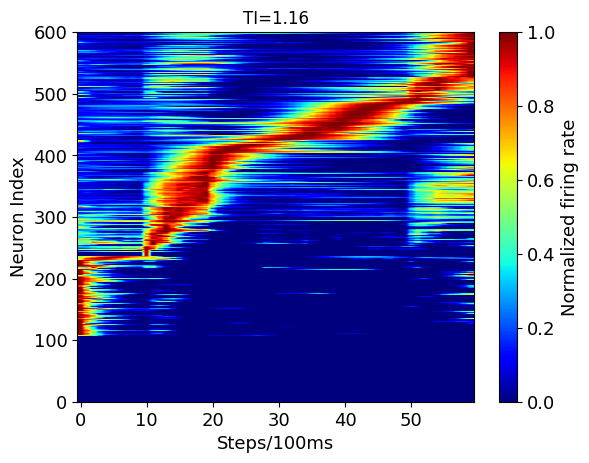

250
True
(1.685, 3.3592632578644492, 0.6846012138258927, 0.6076135350099163, 1.292, 0.39012814575403243, 0.39307535641547864)
4.74579 0.0
True


250
True
(1.864, 3.690521214005238, 0.7521099445967098, 0.6422417883070246, 1.394, 0.4289565743857019, 0.46975806451612906)
5.47719 0.0
True


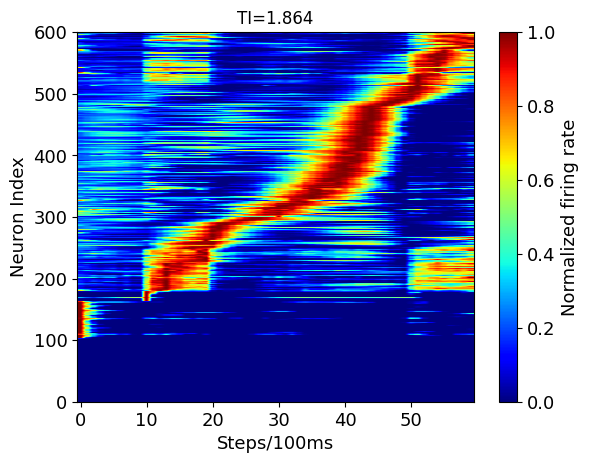

In [101]:
netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/max_delay_3000_delay_3_seed_0_L21.0_m0.0'
print(len(pickle.load(open(netdir+'.pkl', 'rb'))['hidden_act']))
import sys
sys.path.insert(0, "/home/jiashuncheng/code/Trasient/ODPA/")
from model_torch import Model
A = torch.load(netdir+'.pth').w_rnn.cpu().detach().numpy()
print("Sparsity:", A.nonzero()[0].shape[0]/(A.shape[0]*A.shape[1]))
print(A.max(), A.min())
results = pickle.load(open(netdir+'.pkl', 'rb'))['hidden_act'][-1][:,0,:]
hidden_act = results.T
# print(pickle.load(open(netdir, 'rb'))['m'][-1])
data0 = hidden_act
print(cal_TI(results,20,50))
newdata0 = data0.copy()
data0 = normalization1(data0)
B_mylstm= sorting(data0)
data0 = data0[B_mylstm,:]
fig=plt.imshow(data0, aspect='auto',cmap='jet')
# plt.vlines(x=10,ymin=0,ymax=600,linewidth=2,color='white')
# plt.vlines(x=20,ymin=0,ymax=600,linewidth=2,color='white')
# plt.vlines(x=50,ymin=0,ymax=600,linewidth=2,color='white')
plt.xlabel('Steps/100ms', fontsize=13)
plt.gca().invert_yaxis()
plt.ylabel('Neuron Index', fontsize=13)
plt.title('TI={}'.format(cal_TI(results,20,50)[0]))
font = {"size":13}
cb = plt.colorbar(fig)
cb.set_label('Normalized firing rate',fontdict=font)
cb.set_ticks([0,0.2,0.4,0.6,0.8,1])
cb.ax.tick_params(labelsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylim(0,600)
# plt.savefig('figure/fig3a1.svg')
plt.show()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/max_delay_3000_delay_3_seed_0_L21.0_m0.1.pkl'
print(len(pickle.load(open(netdir, 'rb'))['hidden_act']))
results = pickle.load(open(netdir, 'rb'))['hidden_act'][-1][:,0,:]
hidden_act = results.T
# print(pickle.load(open(netdir, 'rb'))['m'][-1])
data0 = hidden_act
print(cal_TI(results,20,50))
newdata0 = data0.copy()
data0 = normalization1(data0)
B_mylstm= sorting(data0)
data0 = data0[B_mylstm,:]
fig=plt.imshow(data0, aspect='auto',cmap='jet')
# plt.vlines(x=10,ymin=0,ymax=600,linewidth=2,color='white')
# plt.vlines(x=20,ymin=0,ymax=600,linewidth=2,color='white')
# plt.vlines(x=50,ymin=0,ymax=600,linewidth=2,color='white')
plt.xlabel('Steps/100ms', fontsize=13)
plt.gca().invert_yaxis()
plt.ylabel('Neuron Index', fontsize=13)
plt.title('TI={}'.format(cal_TI(results,20,50)[0]))
font = {"size":13}
cb = plt.colorbar(fig)
cb.set_label('Normalized firing rate',fontdict=font)
cb.set_ticks([0,0.2,0.4,0.6,0.8,1])
cb.ax.tick_params(labelsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylim(0,600)
# plt.savefig('figure/fig3a1.svg')
plt.show()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/max_delay_3000_delay_3_seed_0_L21.0_m0.2.pkl'
print(len(pickle.load(open(netdir, 'rb'))['hidden_act']))
results = pickle.load(open(netdir, 'rb'))['hidden_act'][-1][:,0,:]
hidden_act = results.T
# print(pickle.load(open(netdir, 'rb'))['m'][-1])
data0 = hidden_act
print(cal_TI(results,20,50))
newdata0 = data0.copy()
data0 = normalization1(data0)
B_mylstm= sorting(data0)
data0 = data0[B_mylstm,:]
fig=plt.imshow(data0, aspect='auto',cmap='jet')
# plt.vlines(x=10,ymin=0,ymax=600,linewidth=2,color='white')
# plt.vlines(x=20,ymin=0,ymax=600,linewidth=2,color='white')
# plt.vlines(x=50,ymin=0,ymax=600,linewidth=2,color='white')
plt.xlabel('Steps/100ms', fontsize=13)
plt.gca().invert_yaxis()
plt.ylabel('Neuron Index', fontsize=13)
plt.title('TI={}'.format(cal_TI(results,20,50)[0]))
font = {"size":13}
cb = plt.colorbar(fig)
cb.set_label('Normalized firing rate',fontdict=font)
cb.set_ticks([0,0.2,0.4,0.6,0.8,1])
cb.ax.tick_params(labelsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylim(0,600)
# plt.savefig('figure/fig3a1.svg')
plt.show()

250
True
(1.345, 3.0592232456336492, 0.6234545454042808, 0.39873973741129976, 1.022, 0.4540623506486096, 0.3225152129817444)
6.4155574 0.0
True


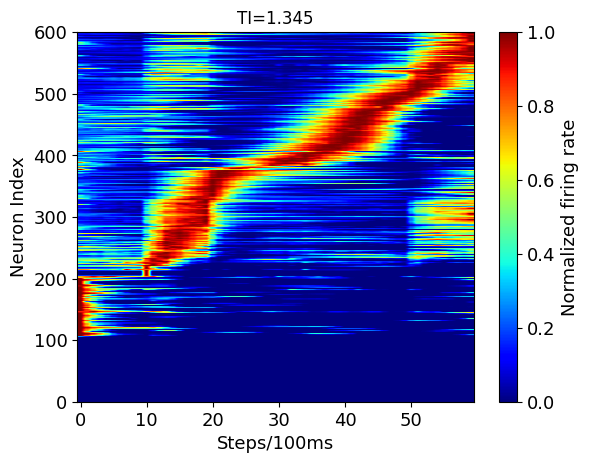

250
True
(1.548, 3.5004815397713736, 0.7133808002371549, 0.4230537101924419, 1.136, 0.534114172814647, 0.412)
4.3179646 0.0
True


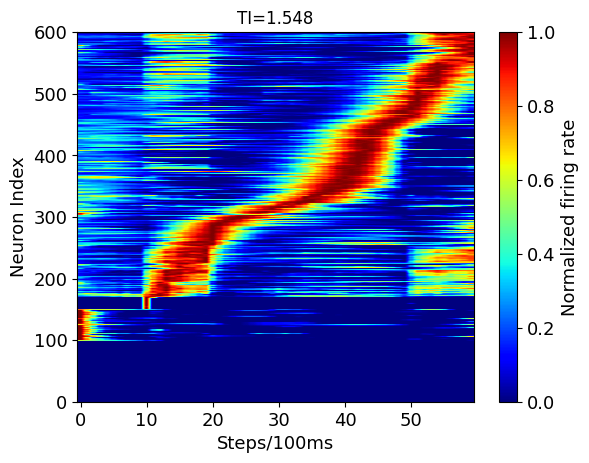

250
True
(1.595, 3.7278137701547105, 0.7597099828333167, 0.4066439467764092, 1.166, 0.5350589214662149, 0.4288577154308617)
4.156237 0.0
True


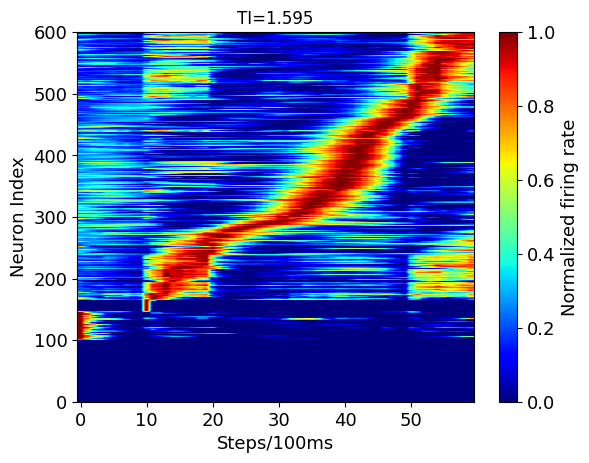

In [76]:
netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/max_delay_3000_delay_3_seed_0_L20.0_m0.0.pkl'
print(len(pickle.load(open(netdir, 'rb'))['hidden_act']))
results = pickle.load(open(netdir, 'rb'))['hidden_act'][-1][:,0,:]
hidden_act = results.T
# print(pickle.load(open(netdir, 'rb'))['m'][-1])
data0 = hidden_act
print(cal_TI(results,20,50))
newdata0 = data0.copy()
data0 = normalization1(data0)
B_mylstm= sorting(data0)
data0 = data0[B_mylstm,:]
fig=plt.imshow(data0, aspect='auto',cmap='jet')
# plt.vlines(x=10,ymin=0,ymax=600,linewidth=2,color='white')
# plt.vlines(x=20,ymin=0,ymax=600,linewidth=2,color='white')
# plt.vlines(x=50,ymin=0,ymax=600,linewidth=2,color='white')
plt.xlabel('Steps/100ms', fontsize=13)
plt.gca().invert_yaxis()
plt.ylabel('Neuron Index', fontsize=13)
plt.title('TI={}'.format(cal_TI(results,20,50)[0]))
font = {"size":13}
cb = plt.colorbar(fig)
cb.set_label('Normalized firing rate',fontdict=font)
cb.set_ticks([0,0.2,0.4,0.6,0.8,1])
cb.ax.tick_params(labelsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylim(0,600)
# plt.savefig('figure/fig3a1.svg')
plt.show()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/max_delay_3000_delay_3_seed_0_L20.0_m0.1.pkl'
print(len(pickle.load(open(netdir, 'rb'))['hidden_act']))
results = pickle.load(open(netdir, 'rb'))['hidden_act'][-1][:,0,:]
hidden_act = results.T
# print(pickle.load(open(netdir, 'rb'))['m'][-1])
data0 = hidden_act
print(cal_TI(results,20,50))
newdata0 = data0.copy()
data0 = normalization1(data0)
B_mylstm= sorting(data0)
data0 = data0[B_mylstm,:]
fig=plt.imshow(data0, aspect='auto',cmap='jet')
# plt.vlines(x=10,ymin=0,ymax=600,linewidth=2,color='white')
# plt.vlines(x=20,ymin=0,ymax=600,linewidth=2,color='white')
# plt.vlines(x=50,ymin=0,ymax=600,linewidth=2,color='white')
plt.xlabel('Steps/100ms', fontsize=13)
plt.gca().invert_yaxis()
plt.ylabel('Neuron Index', fontsize=13)
plt.title('TI={}'.format(cal_TI(results,20,50)[0]))
font = {"size":13}
cb = plt.colorbar(fig)
cb.set_label('Normalized firing rate',fontdict=font)
cb.set_ticks([0,0.2,0.4,0.6,0.8,1])
cb.ax.tick_params(labelsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylim(0,600)
# plt.savefig('figure/fig3a1.svg')
plt.show()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/max_delay_3000_delay_3_seed_0_L20.0_m0.2.pkl'
print(len(pickle.load(open(netdir, 'rb'))['hidden_act']))
results = pickle.load(open(netdir, 'rb'))['hidden_act'][-1][:,0,:]
hidden_act = results.T
# print(pickle.load(open(netdir, 'rb'))['m'][-1])
data0 = hidden_act
print(cal_TI(results,20,50))
newdata0 = data0.copy()
data0 = normalization1(data0)
B_mylstm= sorting(data0)
data0 = data0[B_mylstm,:]
fig=plt.imshow(data0, aspect='auto',cmap='jet')
# plt.vlines(x=10,ymin=0,ymax=600,linewidth=2,color='white')
# plt.vlines(x=20,ymin=0,ymax=600,linewidth=2,color='white')
# plt.vlines(x=50,ymin=0,ymax=600,linewidth=2,color='white')
plt.xlabel('Steps/100ms', fontsize=13)
plt.gca().invert_yaxis()
plt.ylabel('Neuron Index', fontsize=13)
plt.title('TI={}'.format(cal_TI(results,20,50)[0]))
font = {"size":13}
cb = plt.colorbar(fig)
cb.set_label('Normalized firing rate',fontdict=font)
cb.set_ticks([0,0.2,0.4,0.6,0.8,1])
cb.ax.tick_params(labelsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylim(0,600)
# plt.savefig('figure/fig3a1.svg')
plt.show()

# Grid search

(1.788, 4.4676837425292195, 0.7563511919199457, 0.5644483971643736, 1.321, 0.5116134228396578, 0.46680080482897385)


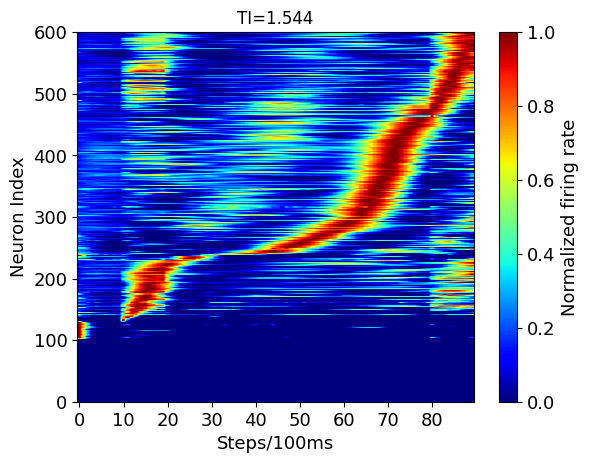

(0.038, 0.0, 0.0, 0.03780353148251969, 0.038, 0.02410081561334085, 0.0)


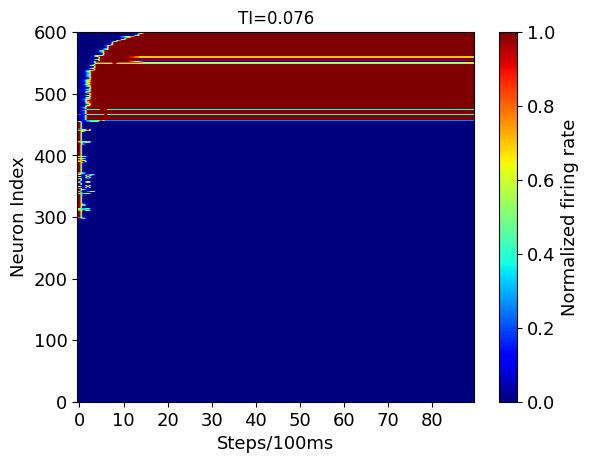

(1.215, 2.9247898767562206, 0.4951488146624314, 0.3489584056222999, 0.844, 0.2801337410838855, 0.37080536912751677)


In [67]:
netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/train/trasient_sparse_heirachical_v5.pkl'
results = pickle.load(open(netdir, 'rb'))['hidden_act'][-1][:,0,:]
hidden_act = results.T
# print(pickle.load(open(netdir, 'rb'))['m'][-1])
data0 = hidden_act
print(cal_TI(results))
newdata0 = data0.copy()
data0 = normalization1(data0)
B_mylstm= sorting(data0)
data0 = data0[B_mylstm,:]
fig=plt.imshow(data0, aspect='auto',cmap='jet')
# plt.vlines(x=10,ymin=0,ymax=600,linewidth=2,color='white')
# plt.vlines(x=20,ymin=0,ymax=600,linewidth=2,color='white')
# plt.vlines(x=50,ymin=0,ymax=600,linewidth=2,color='white')
plt.xlabel('Steps/100ms', fontsize=13)
plt.gca().invert_yaxis()
plt.ylabel('Neuron Index', fontsize=13)
plt.title('TI={}'.format(cal_TI(results,20,50)[0]))
font = {"size":13}
cb = plt.colorbar(fig)
cb.set_label('Normalized firing rate',fontdict=font)
cb.set_ticks([0,0.2,0.4,0.6,0.8,1])
cb.ax.tick_params(labelsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylim(0,600)
# plt.savefig('figure/fig3a1.svg')
plt.show()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/savedir/train/control_v2.pkl'
results = pickle.load(open(netdir, 'rb'))['hidden_act'][-1][:,0,:]
hidden_act = results.T
# print(pickle.load(open(netdir, 'rb'))['m'][-1])
data0 = hidden_act
print(cal_TI(results))
newdata0 = data0.copy()
data0 = normalization1(data0)
B_mylstm= sorting(data0)
data0 = data0[B_mylstm,:]
fig=plt.imshow(data0, aspect='auto',cmap='jet')
# plt.vlines(x=10,ymin=0,ymax=600,linewidth=2,color='white')
# plt.vlines(x=20,ymin=0,ymax=600,linewidth=2,color='white')
# plt.vlines(x=50,ymin=0,ymax=600,linewidth=2,color='white')
plt.xlabel('Steps/100ms', fontsize=13)
plt.gca().invert_yaxis()
plt.ylabel('Neuron Index', fontsize=13)
plt.title('TI={}'.format(cal_TI(results,20,50)[0]))
font = {"size":13}
cb = plt.colorbar(fig)
cb.set_label('Normalized firing rate',fontdict=font)
cb.set_ticks([0,0.2,0.4,0.6,0.8,1])
cb.ax.tick_params(labelsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylim(0,600)
# plt.savefig('figure/fig3a1.svg')
plt.show()

netdir  = '/home/jiashuncheng/code/Trasient/ODPA/old/savedir/trasient_sparse_v6.pkl'
results = pickle.load(open(netdir, 'rb'))['hidden_act'][-1][:,0,:]
hidden_act = results.T
# print(pickle.load(open(netdir, 'rb'))['m'][-1])
data0 = hidden_act
print(cal_TI(results))
newdata0 = data0.copy()
data0 = normalization1(data0)
B_mylstm= sorting(data0)
data0 = data0[B_mylstm,:]
fig=plt.imshow(data0, aspect='auto',cmap='jet')
# plt.vlines(x=10,ymin=0,ymax=600,linewidth=2,color='white')
# plt.vlines(x=20,ymin=0,ymax=600,linewidth=2,color='white')
# plt.vlines(x=50,ymin=0,ymax=600,linewidth=2,color='white')
plt.xlabel('Steps/100ms', fontsize=13)
plt.gca().invert_yaxis()
plt.ylabel('Neuron Index', fontsize=13)
plt.title('TI={}'.format(cal_TI(results,20,80)[0]))
font = {"size":13}
cb = plt.colorbar(fig)
cb.set_label('Normalized firing rate',fontdict=font)
cb.set_ticks([0,0.2,0.4,0.6,0.8,1])
cb.ax.tick_params(labelsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylim(0,600)
# plt.savefig('figure/fig3a1.svg')
plt.show()

0
{'0.2 0.5:': 2.127}


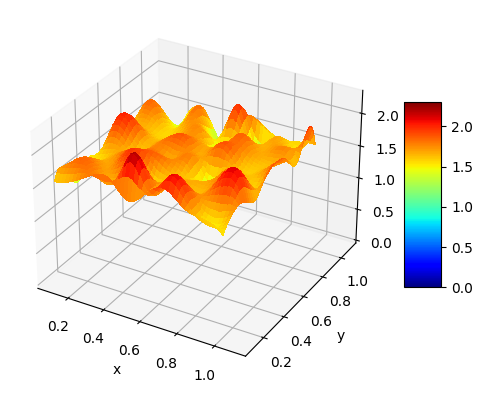

In [7]:
max_ = {" ":0}
z = np.zeros((10,10))
print(list(max_.values())[0])
for i in range(1,11):
    for j in range(1,11):
        netdir  = '/home/jiashuncheng/code/Trasient/ODPA/old/savedir/0.2_seed_1_old_auto_trasient_sparse_heirachical_con_{:.1f}_m_{:.1f}.pkl'.format(i*0.1, j*0.1)
        results = pickle.load(open(netdir, 'rb'))['hidden_act'][-1][:,0,:]
        hidden_act = results.T
        # print(pickle.load(open(netdir, 'rb'))['m'][-1])
        data0 = hidden_act
        TI = cal_TI(results)[0]
        z[i-1,j-1]=TI
        # print('{:.1f} {:.1f}:'.format(i*0.1, j*0.1), TI)
        if TI > list(max_.values())[0]:
            max_ = {'{:.1f} {:.1f}:'.format(i*0.1, j*0.1): TI}
print(max_)

x = np.arange(0.1, 1.1, 0.1)
y = np.arange(0.1, 1.1, 0.1)
X, Y = np.meshgrid(x, y)
Z = z
plt.imshow(Z, vmin=0, vmax=2.2)
# plt.zlim(0,2.2)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
x1 = np.arange(0.1, 1.1, 0.01)
y1 = np.arange(0.1, 1.1, 0.01)
X1, Y1 = np.meshgrid(x1,y1)
f1 = RGI((x, y), Z.T, method='cubic',bounds_error=False)
Z1 = f1((X1, Y1))
surf = ax.plot_surface(X1, Y1, Z1, cmap=cm.jet, linewidth=0, antialiased=False, vmin=0, vmax=2.3)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlim([0,2.3])
plt.show()

0
{'0.4 0.5:': 2.051}
0.065


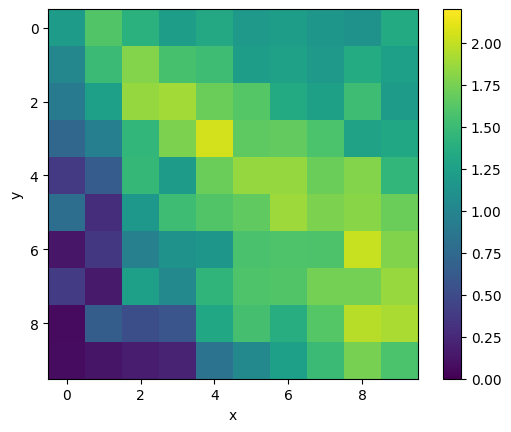

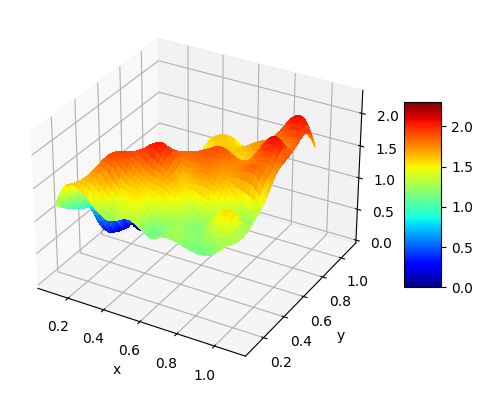

In [8]:
max_ = {" ":0}
z = np.zeros((10,10))
print(list(max_.values())[0])
for i in range(1,11):
    for j in range(1,11):
        netdir  = '/home/jiashuncheng/code/Trasient/ODPA/old/savedir/0.2_seed_1_old_auto_trasient_sparse_con_{:.1f}_m_{:.1f}.pkl'.format(i*0.1, j*0.1)
        results = pickle.load(open(netdir, 'rb'))['hidden_act'][-1][:,0,:]
        hidden_act = results.T
        # print(pickle.load(open(netdir, 'rb'))['m'][-1])
        data0 = hidden_act
        TI = cal_TI(results)[0]
        z[i-1,j-1]=TI
        # print('{:.1f} {:.1f}:'.format(i*0.1, j*0.1), TI)
        if TI > list(max_.values())[0]:
            max_ = {'{:.1f} {:.1f}:'.format(i*0.1, j*0.1): TI}
print(max_)

x = np.arange(0.1, 1.1, 0.1)
y = np.arange(0.1, 1.1, 0.1)
X, Y = np.meshgrid(x, y)
Z = z
print(Z.min())
plt.imshow(Z, vmin=0, vmax=2.2)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
x1 = np.arange(0.1, 1.1, 0.01)
y1 = np.arange(0.1, 1.1, 0.01)
X1, Y1 = np.meshgrid(x1,y1)
f1 = RGI((x, y), Z.T, method='cubic',bounds_error=False)
Z1 = f1((X1, Y1))
surf = ax.plot_surface(X1, Y1, Z1, cmap=cm.jet, linewidth=0, antialiased=False, vmin=0, vmax=2.3)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlim([0,2.3])
plt.show()

1.0 0.5: 0.834
12:


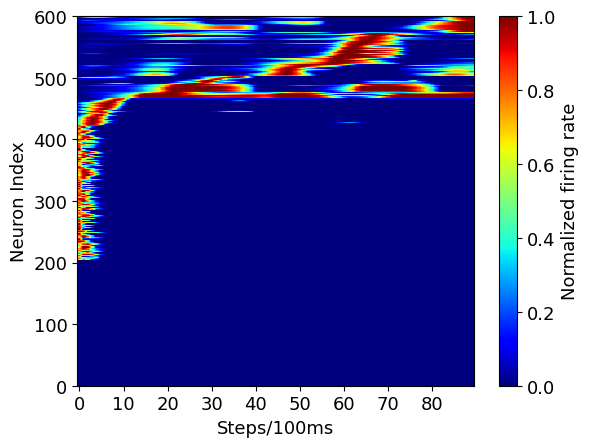

In [18]:
i=10
j=5
netdir  = '/home/jiashuncheng/code/Trasient/ODPA/old/savedir/0.2_seed_1_old_auto_trasient_sparse_con_{:.1f}_m_{:.1f}.pkl'.format(i*0.1, j*0.1)
results = pickle.load(open(netdir, 'rb'))['hidden_act'][-1][:,0,:]
hidden_act = results.T
# print(pickle.load(open(netdir, 'rb'))['m'][-1])
data0 = hidden_act
TI = cal_TI(results)[0]
print('{:.1f} {:.1f}:'.format(i*0.1, j*0.1), TI)
newdata0 = data0.copy()
data0 = normalization1(data0)
B_mylstm= sorting(data0)
data0 = data0[B_mylstm,:]
fig=plt.imshow(data0, aspect='auto',cmap='jet')
# plt.vlines(x=10,ymin=0,ymax=600,linewidth=2,color='white')
# plt.vlines(x=20,ymin=0,ymax=600,linewidth=2,color='white')
# plt.vlines(x=50,ymin=0,ymax=600,linewidth=2,color='white')
plt.xlabel('Steps/100ms', fontsize=13)
plt.gca().invert_yaxis()
plt.ylabel('Neuron Index', fontsize=13)
font = {"size":13}
cb = plt.colorbar(fig)
cb.set_label('Normalized firing rate',fontdict=font)
cb.set_ticks([0,0.2,0.4,0.6,0.8,1])
cb.ax.tick_params(labelsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylim(0,600)
# plt.savefig('figure/fig3a1.svg')
print('12:')
plt.show()

0.2 0.5: 1.516


12:


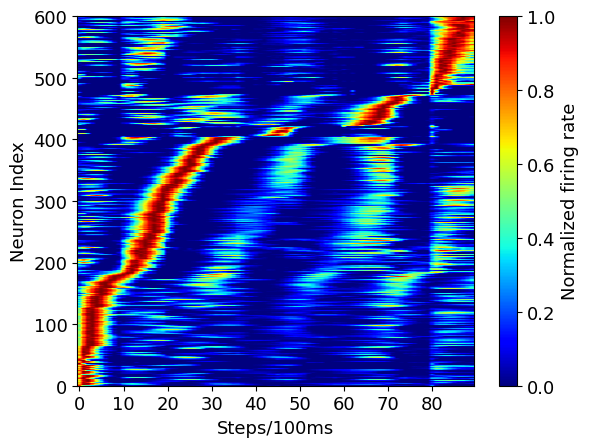

In [17]:
i=2
j=5
netdir  = '/home/jiashuncheng/code/Trasient/ODPA/old/savedir/0.2_seed_1_old_auto_trasient_sparse_con_{:.1f}_m_{:.1f}.pkl'.format(i*0.1, j*0.1)
results = pickle.load(open(netdir, 'rb'))['hidden_act'][-1][:,0,:]
hidden_act = results.T
# print(pickle.load(open(netdir, 'rb'))['m'][-1])
data0 = hidden_act
TI = cal_TI(results)[0]
print('{:.1f} {:.1f}:'.format(i*0.1, j*0.1), TI)
newdata0 = data0.copy()
data0 = normalization1(data0)
B_mylstm= sorting(data0)
data0 = data0[B_mylstm,:]
fig=plt.imshow(data0, aspect='auto',cmap='jet')
# plt.vlines(x=10,ymin=0,ymax=600,linewidth=2,color='white')
# plt.vlines(x=20,ymin=0,ymax=600,linewidth=2,color='white')
# plt.vlines(x=50,ymin=0,ymax=600,linewidth=2,color='white')
plt.xlabel('Steps/100ms', fontsize=13)
plt.gca().invert_yaxis()
plt.ylabel('Neuron Index', fontsize=13)
font = {"size":13}
cb = plt.colorbar(fig)
cb.set_label('Normalized firing rate',fontdict=font)
cb.set_ticks([0,0.2,0.4,0.6,0.8,1])
cb.ax.tick_params(labelsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylim(0,600)
# plt.savefig('figure/fig3a1.svg')
print('12:')
plt.show()

0.2 0.5: 2.127
123:


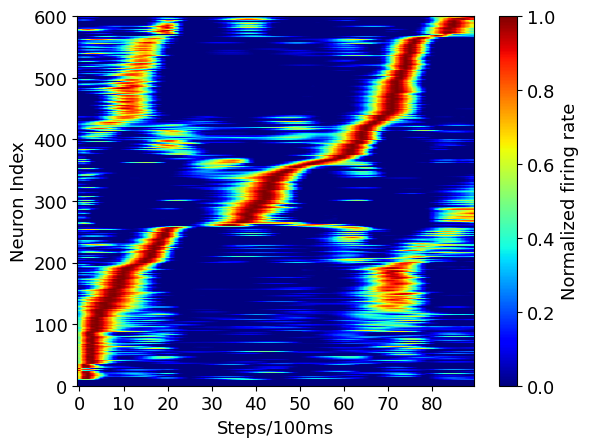

In [16]:
i=2
j=5
netdir  = '/home/jiashuncheng/code/Trasient/ODPA/old/savedir/0.2_seed_1_old_auto_trasient_sparse_heirachical_con_{:.1f}_m_{:.1f}.pkl'.format(i*0.1, j*0.1)
results = pickle.load(open(netdir, 'rb'))['hidden_act'][-1][:,0,:]
hidden_act = results.T
# print(pickle.load(open(netdir, 'rb'))['m'][-1])
data0 = hidden_act
TI = cal_TI(results)[0]
print('{:.1f} {:.1f}:'.format(i*0.1, j*0.1), TI)
newdata0 = data0.copy()
data0 = normalization1(data0)
B_mylstm= sorting(data0)
data0 = data0[B_mylstm,:]
fig=plt.imshow(data0, aspect='auto',cmap='jet')
# plt.vlines(x=10,ymin=0,ymax=600,linewidth=2,color='white')
# plt.vlines(x=20,ymin=0,ymax=600,linewidth=2,color='white')
# plt.vlines(x=50,ymin=0,ymax=600,linewidth=2,color='white')
plt.xlabel('Steps/100ms', fontsize=13)
plt.gca().invert_yaxis()
plt.ylabel('Neuron Index', fontsize=13)
font = {"size":13}
cb = plt.colorbar(fig)
cb.set_label('Normalized firing rate',fontdict=font)
cb.set_ticks([0,0.2,0.4,0.6,0.8,1])
cb.ax.tick_params(labelsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylim(0,600)
# plt.savefig('figure/fig3a1.svg')
print('123:')
plt.show()

In [11]:
np.arange(0,360,360/2)

array([  0., 180.])

In [ ]:
{'0.3 1.0:': 2.181}

In [52]:
import numpy as np
import torch
s = np.random.poisson(size=(4, 3))
s.shape

torch.arange(3).tolist()

s[[2, 3, 0], np.arange(3)] = 9
b = torch.zeros((4,3))
b[([[2,3,0],[1,2,0]], [[0,1,2], [0,1,2]])] = 9
a = torch.ones((1,3))
a.type(torch.int)
torch.tensor((1))
torch.inf

x = 1
b = {}
b[0] = x
b[0] = 2
print(x)
a = [x]
a[0] = 2
import ctypes
# ctypes.cast(a[0], ctypes.py_object) = 1
print(id(x))
print(id(a[0]))

1
7618240
7618272


In [56]:
a = 1
b = [a]
b[0] = 2
print(b[0] is a)



False


In [67]:
# a = torch.nn.Module()
# b = a
# a = 2
# print(id(a))


from ctypes import *
x = 0
a = c_int(x)
b = pointer(a)
b.contents.value = 1
print(x)

0


In [2]:
import torch
b = 2
a = {}
a[0] = b
b = 1
print(a[0])

index = torch.arange(10).unsqueeze(0).unsqueeze(0)
index.repeat(2,3,1).shape

torch.arange(3).unsqueeze(1).unsqueeze(0).repeat(3,1,1)

import torch

# 创建一个2x3的张量
x = torch.tensor([[[1, 2, 3], [4, 5, 6], [7,8,9]], [[1, 2, 3], [4, 5, 6], [7,8,2]]])
print("Original tensor:")
print(x)

# 使用torch.index_select()函数获取第0行（索引为0）
row_0 = torch.index_select(x, 0, torch.tensor([0]))
print("Row 0 with same dimension:")
print(row_0.shape)

from torch.autograd import Function, Variable

torch.tensor(2, dtype=torch.float)
Variable(torch.zeros(0)).grad

2
Original tensor:
tensor([[[1, 2, 3],
         [4, 5, 6],
         [7, 8, 9]],

        [[1, 2, 3],
         [4, 5, 6],
         [7, 8, 2]]])
Row 0 with same dimension:
torch.Size([1, 3, 3])


TypeError: tensor() got an unexpected keyword argument 'type'

In [120]:
import torch
import torch.nn as nn
import torch.optim as optim

class ActionFun(Function):
	@staticmethod
	def forward(ctx, v):
		ctx.save_for_backward(v)
		return v.gt(5)

	@staticmethod
	def backward(ctx, grad_output):
		v = ctx.saved_tensors
		grad_input = grad_output.clone()
		temp = abs(v - 5) < 5
		return grad_input * temp.float()

# 定义一个简单的线性模型
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.linear = nn.Linear(1, 1)

    def forward(self, x):
        X = []
        for i in range(2):
            X.append(self.linear(x[i]))
        X = torch.stack(X, dim=0)
        return X

# 创建模型、损失函数和优化器
model = SimpleModel()
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# 输入数据和目标值
input_data = torch.rand((2,2,1))
target_data = torch.rand((2, 1))

# 前向传播
output = model(input_data)

# 计算损失
print(output.shape, target_data.shape)
loss = criterion(output.mean(0), target_data)

# 反向传播
loss.backward()
print(model.linear.weight.grad)
# 更新模型参数
# optimizer.step()

# 清空梯度
optimizer.zero_grad()


torch.Size([2, 2, 1]) torch.Size([2, 1])
tensor([[-0.8714]])


In [6]:
eval("1,2")

(1, 2)